In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

from tqdm import tqdm
import swifter

from osgeo import ogr, osr
from joblib import Parallel, delayed

tqdm.pandas()
import xarray as xr
from global_land_mask import globe
import geopandas as gpd
import geoplot

from datetime import date
today_date = date.today().strftime("%b_%d").lower()
import os

from convertbng.util import convert_bng, convert_lonlat
import utm

import shapefile as shp
from shapely.geometry import Point, Polygon, MultiPolygon

In [2]:
# Keep only Duplicates

# loc_df_duplicates = loc_df[loc_df.duplicated(subset=['lat_long'], keep=False)]
# loc_df_duplicates.sort_values(by=['latitude', 'longitude'], inplace=True)
# print(len(loc_df_duplicates))
# loc_df_duplicates.tail(50)

In [3]:
# Species dictionay

species_name_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv')

dict_species_name = species_name_df.set_index('common_name').to_dict()['scientific_name']

In [76]:
shapefilename = '/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp'
# shapefilename = '/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroRIVERS_v10_na_shp/HydroRIVERS_v10_na.shp'
# shapefilename = '/mnt/c/Users/imrit/Downloads/Shapefiles/Canada_provinces/lpr_000b16a_e.shp'

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

ds = ogr.Open(shapefilename)
layer = ds.GetLayer()
srs = layer.GetSpatialRef()

def get_zone(lat,lon):
    """
    Calculates local zone (1-60) based on longitude
    """
    lon180 = (lon + 180) % 360 - 180
    zone = int(np.ceil((lon180 + 180) / 6))
    return zone

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def convert_to_utm(lat,lon, zone=None, ellps='WGS84',inverse=False,**kwargs):
    """
    Converts from lat, lon to local UTM projection in metres
    zone (optional) : integer (between 1 and 60)
    Returns tuple of x,y coordinate
    """    

    if zone is None:
        zone = get_zone(lat,lon)

    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)
    
    target = osr.SpatialReference()
    if lat >= 0:
#         target.ImportFromEPSG(int('326{}'.format(zone)))
#         target.ImportFromEPSG(int(‘326{:02d}’.format(zone)))
        target.ImportFromEPSG(int(f"326{zone:02d}"))
    else:
#         target.ImportFromEPSG(int('327{}'.format(zone)))
#         target.ImportFromEPSG(int(‘327{:02d}’.format(zone)))
        target.ImportFromEPSG(int(f"327{zone:02d}"))

    if inverse:
        transform = osr.CoordinateTransformation(target, source)
    #    point = ogr.CreateGeometryFromWkt("POINT ({} {})".format(lon,lat))
    else:
        transform = osr.CoordinateTransformation(source, target)

    # Note that proper conversion here expects POINT as lat,lon
    point = ogr.CreateGeometryFromWkt("POINT ({} {})".format(lat,lon))
        
    point.Transform(transform)

    return point.GetX(),point.GetY()

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def draw_circle(lat,lon, radius=1, polygon=True): # km):
    zone = get_zone(lat,lon)

    # convert to local UTM (in metres)
    x0, y0 = convert_to_utm(lat,lon,zone=zone)

    # find radius of circle in metres
    r = radius * 1000
    phi = np.linspace(0, np.pi * 2,20)
    x = x0 + r * np.cos(phi)
    y = y0 + r * np.sin(phi)
    
    # convert back to latitude and longitude
    result = [convert_to_utm(i, j, zone = zone, inverse = True) for i,j in zip(x, y)]
    # return in Longitude, Latitude order to match HydroLAKES order of coordinates
    if polygon:
        result = 'POLYGON (({}))'.format(','.join(['{} {}'.format(j,i) for i, j in result]))
        return result
    else:
        return result

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def match2hydrolakes(lat,lon,dtol=1, displayOn=False, get_field = 'HYRIV_ID'):

# dtol is distance tolerance in km.
#    algorithm looks for any lakes that overlap with a circle of radius dtol drawn around point at (lat,lon)

# HydroLAKES coordinates are presented as (Lon,Lat) pairs
# coordinates must be (Lon, Lat) for HydroLAKES comparison
# Transform generally expects (lat, lon) order
# added setaxismapping to correct this

    wkt = 'POINT ({} {})'.format(lon,lat)
    point = ogr.CreateGeometryFromWkt(wkt)

    # create a circle around the point (these coordinate pairs are in lon,lat order)
    wkt = draw_circle(lat,lon,radius=dtol)
    
    # filter based on this circle
    layer.SetSpatialFilter(ogr.CreateGeometryFromWkt(wkt))

    # now calculate distance in metres =======
    #    Read in (lon, lat)
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)
    # This line reverses the expected input from (lat,lon) to (lon,lat) as appears in the HydroLAKES
    source.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)

    target = osr.SpatialReference()
#     if lat >= 0:
#         target.ImportFromEPSG(int('326{}'.format(get_zone(lat,lon))))
#     else:
#         target.ImportFromEPSG(int('327{}'.format(get_zone(lat,lon))))
    
    if lat >= 0:
#         target.ImportFromEPSG(int('326{}'.format(get_zone(lat,lon))))
#         target.ImportFromEPSG(int(‘326{:02d}’.format(get_zone(lat,lon))))
        target.ImportFromEPSG(int(f"326{get_zone(lat,lon):02d}"))
    else:
#         target.ImportFromEPSG(int('327{}'.format(get_zone(lat,lon))))
#         target.ImportFromEPSG(int(‘327{:02d}’.format(get_zone(lat,lon))))
        target.ImportFromEPSG(int(f"327{get_zone(lat,lon):02d}"))

    transform = osr.CoordinateTransformation(source, target)
    
    # transform point to new coordinate
    point.Transform(transform)
    
    hylak_dist = []
    hylak_id = []
    for feat in layer:
        geo = feat.GetGeometryRef()
        geo.Transform(transform)
        distance_to_lake = geo.Distance(point)
        hylak_id.append(feat.GetField('HYLAK_ID'))
#         hylak_id.append(feat.GetField(get_field))
        hylak_dist.append(distance_to_lake)
        if distance_to_lake == 0:
            break

    # now find minimum distance
    result = [[i,j] for [i,j] in zip(hylak_dist, hylak_id)]

    # clean up 
    ds = None
    
    if len(result) == 0:
        return [np.nan, np.nan]
    else:
        return min(result)

In [77]:
match2hydrolakes(51.111111, -73.363889)

[202.94595732217104, 54]

In [ ]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/fish_community_ontario_1957_2017_v3_feb_9.csv')
loc_df = df[['waterbody_name', 'site_description', 'year', 'latitude', 'longitude', 'lat_long', 'surface_area', 
             'depth_max', 'secchi_depth', 'depth_mean']]
loc_df.head()

In [ ]:
loc_df_only = loc_df[['latitude', 'longitude', 'surface_area', 'depth_max', 'secchi_depth', 'depth_mean']]
print(len(loc_df_only))
loc_df_only.drop_duplicates(subset=['latitude', 'longitude'], inplace=True)
print(len(loc_df_only))
loc_df_only.head()

In [ ]:
sample_df = loc_df_only.sample(15)

In [ ]:
%%time
loc_df_only['hydro_dist'] = loc_df_only.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), axis=1)

In [ ]:
# loc_df_only['hylak_id'] = loc_df_only['hydro_dist'].split(',')[1]
display(loc_df_only.sample(10))

In [ ]:
%%time
sample_df['hydro_match'] = sample_df.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                           axis=1)
sample_df[['hydro_dist','hydro_id']] = pd.DataFrame(sample_df['hydro_match'].tolist(), index= sample_df.index)
display(sample_df)

In [ ]:
sample_df[['hydro_dist','hydro_id']] = pd.DataFrame(sample_df['hydro_match'].tolist(), index= sample_df.index)
display(sample_df)

# All locations - Canada + USA

In [3]:
all_loc_df = pd.read_csv('/mnt/c/Users/imrit/Desktop/merged_dfs_actinopt_location_apr_14_2021.csv')
all_loc_df = all_loc_df[['latitude', 'longitude']]
all_loc_df = all_loc_df.loc[all_loc_df['longitude'] != all_loc_df['latitude']]
all_loc_df = all_loc_df.loc[(all_loc_df['latitude'] > 10) & (all_loc_df['latitude'] < 90) & 
                            (all_loc_df['longitude'] > -180) & (all_loc_df['longitude'] < -30)]
all_loc_df.drop_duplicates(inplace=True)
all_loc_df.reset_index(inplace=True)
print(len(all_loc_df))
display(all_loc_df.tail())

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,3,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


949809


index  latitude  longitude
949804  1885679  61.25564  -150.2909
949805  1885687  60.05600  -151.6631
949806  1885704  61.53409  -149.2670
949807  1885720  59.45795  -139.5714
949808  1885767  61.52089  -148.9544

In [ ]:
%%time
all_loc_df['hydro_dist'] = all_loc_df.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)

# all_loc_df['hydro_dist'] = all_loc_df.swifter.progress_apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
#                                                      axis=1)

In [7]:
def df_match_hydrolakes(df):
    df['hydro_dist'] = df.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), axis=1)
    return df

In [4]:
all_loc_1, all_loc_2, all_loc_3, all_loc_4 = np.array_split(all_loc_df, 4)

In [5]:
%%time
all_loc_1['hydro_dist'] = all_loc_1.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)

KeyboardInterrupt: 

In [6]:
%%time
all_loc_2['hydro_dist'] = all_loc_2.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)

KeyboardInterrupt: 

In [ ]:
%%time
all_loc_3['hydro_dist'] = all_loc_3.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)

In [ ]:
%%time
all_loc_4['hydro_dist'] = all_loc_4.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)

In [17]:
new_loc_dfs = pd.concat([all_loc_1, all_loc_2, all_loc_3, all_loc_4])
new_loc_dfs.rename(columns = {'hydro_dist': 'hydro_match'}, inplace=True)
new_loc_dfs[['hydro_dist', 'hydro_id']] = pd.DataFrame(new_loc_dfs['hydro_match'].tolist(), index= new_loc_dfs.index)
print(len(new_loc_dfs))
display(new_loc_dfs)

949809


index   latitude   longitude               hydro_match  hydro_dist  \
0             0  45.095566  -74.434094                [0.0, 754]    0.000000   
1             1  45.029876  -73.332214  [17.286849159692334, 64]   17.286849   
2             2  45.015270  -71.632880             [0.0, 109510]    0.000000   
3             3  45.098055  -71.656944            [0.0, 1040479]    0.000000   
4             4  45.029304  -71.907721             [0.0, 109483]    0.000000   
...         ...        ...         ...                       ...         ...   
949804  1885679  61.255640 -150.290900                [nan, nan]         NaN   
949805  1885687  60.056000 -151.663100                [nan, nan]         NaN   
949806  1885704  61.534090 -149.267000                [nan, nan]         NaN   
949807  1885720  59.457950 -139.571400                [nan, nan]         NaN   
949808  1885767  61.520890 -148.954400                [nan, nan]         NaN   

         hydro_id  
0           754.0  
1            64.0  
2        109510.0  
3       1040479.0  
4        109483.0  
...           ...  
949804        NaN  
949805        NaN  
949806        NaN  
949807        NaN  
949808        NaN  

[949809 rows x 6 columns]

In [19]:
new_loc_dfs.to_csv('/mnt/c/Users/imrit/Desktop/apr_15_fish_locs_hydro.csv', index=False)

# Hydro ids

# Nhi Alberta Hydro ID

In [40]:
nhi_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Homogenization/Data/alberta_lakes_resampled_max_5_species_cru.csv')
nhi_df.head()

waterbody_name  year  grouped_lat  grouped_long         lat_long  \
0   BOURQUE LAKE  1979    54.673285   -110.546206  54.673_-110.546   
1   BOURQUE LAKE  1989    54.673285   -110.546206  54.673_-110.546   
2   BOURQUE LAKE  2000    54.673285   -110.546206  54.673_-110.546   
3   BOURQUE LAKE  2006    54.673285   -110.546206  54.673_-110.546   
4   BOURQUE LAKE  2016    54.673285   -110.546206  54.673_-110.546   

   esox_lucius  couesius_plumbeus  culaea_inconstans  catostomus_commersonii  \
0          1.0                NaN                NaN                     1.0   
1          1.0                NaN                NaN                     1.0   
2          1.0                NaN                NaN                     1.0   
3          1.0                NaN                NaN                     1.0   
4          1.0                NaN                NaN                     1.0   

   chrosomus_neogaeus  ...  mean_temp_dec  mean_temp_feb  mean_temp_jan  \
0                 NaN  ...     -12.200000     -26.000000     -20.400000   
1                 NaN  ...     -13.800000     -17.200001     -15.400001   
2                 NaN  ...     -18.900000     -12.100000     -18.900000   
3                 NaN  ...     -10.700000     -12.600000     -10.800000   
4                 NaN  ...     -16.300001      -9.600000     -13.600000   

   mean_temp_jul  mean_temp_jun  mean_temp_mar  mean_temp_may  mean_temp_nov  \
0      17.300001      13.400001           -7.4       7.400000      -4.300000   
1      17.300001      13.900001          -13.0       9.300000      -7.700000   
2      16.200001      12.100000           -4.9       7.900000      -7.200000   
3      17.400000      15.200000           -7.5      10.400001     -11.900001   
4      16.400000      14.700000           -4.1      11.000000      -1.200000   

   mean_temp_oct  mean_temp_sep  
0            5.1      10.500000  
1            3.1       9.400001  
2            3.5       8.700000  
3            1.4      10.500000  
4            1.6       9.600000  

[5 rows x 51 columns]

In [ ]:
new_loc_dfs[['hydro_dist', 'hydro_id']] = pd.DataFrame(new_loc_dfs['hydro_match'].tolist(), index= new_loc_dfs.index)
print(len(new_loc_dfs))

In [41]:
nhi_df['hydro_match'] = nhi_df.apply(lambda row: match2hydrolakes(row['grouped_lat'], row['grouped_long']), axis=1)

In [45]:
nhi_df[['hydro_dist', 'hydro_id']] = pd.DataFrame(nhi_df['hydro_match'].tolist(), index= nhi_df.index)
nhi_df.drop(columns=['hydro_dist'], inplace=True)
display(nhi_df.head())

waterbody_name  year  grouped_lat  grouped_long         lat_long  \
0   BOURQUE LAKE  1979    54.673285   -110.546206  54.673_-110.546   
1   BOURQUE LAKE  1989    54.673285   -110.546206  54.673_-110.546   
2   BOURQUE LAKE  2000    54.673285   -110.546206  54.673_-110.546   
3   BOURQUE LAKE  2006    54.673285   -110.546206  54.673_-110.546   
4   BOURQUE LAKE  2016    54.673285   -110.546206  54.673_-110.546   

   esox_lucius  couesius_plumbeus  culaea_inconstans  catostomus_commersonii  \
0          1.0                NaN                NaN                     1.0   
1          1.0                NaN                NaN                     1.0   
2          1.0                NaN                NaN                     1.0   
3          1.0                NaN                NaN                     1.0   
4          1.0                NaN                NaN                     1.0   

   chrosomus_neogaeus  ...  mean_temp_jan  mean_temp_jul  mean_temp_jun  \
0                 NaN  ...     -20.400000      17.300001      13.400001   
1                 NaN  ...     -15.400001      17.300001      13.900001   
2                 NaN  ...     -18.900000      16.200001      12.100000   
3                 NaN  ...     -10.800000      17.400000      15.200000   
4                 NaN  ...     -13.600000      16.400000      14.700000   

   mean_temp_mar  mean_temp_may  mean_temp_nov  mean_temp_oct  mean_temp_sep  \
0           -7.4       7.400000      -4.300000            5.1      10.500000   
1          -13.0       9.300000      -7.700000            3.1       9.400001   
2           -4.9       7.900000      -7.200000            3.5       8.700000   
3           -7.5      10.400001     -11.900001            1.4      10.500000   
4           -4.1      11.000000      -1.200000            1.6       9.600000   

    hydro_match  hydro_id  
0  [0.0, 81935]   81935.0  
1  [0.0, 81935]   81935.0  
2  [0.0, 81935]   81935.0  
3  [0.0, 81935]   81935.0  
4  [0.0, 81935]   81935.0  

[5 rows x 53 columns]

In [50]:
nhi_cru_hydro = nhi_df.merge(hydrolakes_df, left_on=['hydro_id'], 
                       right_on=['Hylak_id'], how='left').drop(columns=['geometry'], axis=1)

display(nhi_cru_hydro.head())

waterbody_name  year  grouped_lat  grouped_long         lat_long  \
0   BOURQUE LAKE  1979    54.673285   -110.546206  54.673_-110.546   
1   BOURQUE LAKE  1989    54.673285   -110.546206  54.673_-110.546   
2   BOURQUE LAKE  2000    54.673285   -110.546206  54.673_-110.546   
3   BOURQUE LAKE  2006    54.673285   -110.546206  54.673_-110.546   
4   BOURQUE LAKE  2016    54.673285   -110.546206  54.673_-110.546   

   esox_lucius  couesius_plumbeus  culaea_inconstans  catostomus_commersonii  \
0          1.0                NaN                NaN                     1.0   
1          1.0                NaN                NaN                     1.0   
2          1.0                NaN                NaN                     1.0   
3          1.0                NaN                NaN                     1.0   
4          1.0                NaN                NaN                     1.0   

   chrosomus_neogaeus  ...  Vol_res  Vol_src  Depth_avg  Dis_avg  Res_time  \
0                 NaN  ...      0.0      3.0        7.8      0.1    4647.5   
1                 NaN  ...      0.0      3.0        7.8      0.1    4647.5   
2                 NaN  ...      0.0      3.0        7.8      0.1    4647.5   
3                 NaN  ...      0.0      3.0        7.8      0.1    4647.5   
4                 NaN  ...      0.0      3.0        7.8      0.1    4647.5   

   Elevation  Slope_100  Wshd_area   Pour_long  Pour_lat  
0      601.0       3.15      135.5 -110.542317  54.65604  
1      601.0       3.15      135.5 -110.542317  54.65604  
2      601.0       3.15      135.5 -110.542317  54.65604  
3      601.0       3.15      135.5 -110.542317  54.65604  
4      601.0       3.15      135.5 -110.542317  54.65604  

[5 rows x 74 columns]

In [51]:
nhi_cru_hydro.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Homogenization/Data/alberta_lakes_resampled_max_5_species_cru_hydrolakes.csv', 
                     index=False)

# Hydro ID

In [7]:
%%time
hydrolakes_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/hydrolakes_v10.csv')
print(len(hydrolakes_df))
display(hydrolakes_df.head())

<string>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


1427688


Hylak_id    Lake_name                   Country      Continent Poly_src  \
0         1  Caspian Sea                    Russia         Europe     SWBD   
1         2   Great Bear                    Canada  North America   CanVec   
2         3  Great Slave                    Canada  North America   CanVec   
3         4     Winnipeg                    Canada  North America   CanVec   
4         5     Superior  United States of America  North America     SWBD   

   Lake_type  Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_res  \
0          1         0  377001.91   15829.37       7.27  ...      0.0   
1          1         0   30450.64    5331.72       8.62  ...      0.0   
2          1         0   26734.29    9814.16      16.93  ...      0.0   
3          3       709   23923.04    4018.32       7.33  ...  31790.0   
4          1         0   81843.92    5248.36       5.18  ...      0.0   

   Vol_src  Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  \
0        1      200.5  8110.642  107883.0        -29       -1.0  1404108.0   
1        1       72.2   535.187   47577.7        145       -1.0   147665.4   
2        1       59.1  4350.692    4203.2        148       -1.0   995312.3   
3        1       11.9  2244.727    1464.3        215       -1.0   919611.5   
4        1      146.7  2869.953   48410.3        179       -1.0   209219.5   

    Pour_long   Pour_lat  
0   47.717708  45.591934  
1 -123.505546  65.138384  
2 -117.617115  61.311727  
3  -97.863542  53.696359  
4  -84.460547  46.468593  

[5 rows x 21 columns]

CPU times: user 2.28 s, sys: 688 ms, total: 2.97 s
Wall time: 2.94 s


In [18]:
%%time
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/apr_23_fish_locs_hydro.csv')
# df['ocean'] = np.where(globe.is_ocean(df['latitude'], df['longitude']), 'YES', 'NO')
# df['hydro_id'] = np.where(df['hydro_dist'] > 1000, np.nan, df['hydro_id'])
display(df.head())

latitude  longitude               hydro_match  hydro_dist   hydro_id  \
0  45.095566 -74.434094                [0.0, 754]    0.000000      754.0   
1  45.029876 -73.332214  [17.286849159692334, 64]   17.286849       64.0   
2  45.015270 -71.632880             [0.0, 109510]    0.000000   109510.0   
3  45.098055 -71.656944            [0.0, 1040479]    0.000000  1040479.0   
4  45.029304 -71.907721             [0.0, 109483]    0.000000   109483.0   

  ocean match2river  river_hydro_dist  river_hydro_id hydro_waterbody  
0    NO         NaN               NaN             NaN            lake  
1    NO         NaN               NaN             NaN            lake  
2    NO         NaN               NaN             NaN            lake  
3    NO         NaN               NaN             NaN            lake  
4    NO         NaN               NaN             NaN            lake

CPU times: user 719 ms, sys: 219 ms, total: 938 ms
Wall time: 939 ms


In [19]:
df_hydro_id_only = df[['latitude', 'longitude', 'hydro_id', 'ocean', 'hydro_dist']]
df_hydro_id_only.drop_duplicates(inplace=True)
print(len(df_hydro_id_only))

df_hydro_id_only = df_hydro_id_only.merge(hydrolakes_df, left_on='hydro_id', right_on=['Hylak_id'], how='left')
display(df_hydro_id_only.head())

print(df_hydro_id_only['Country'].value_counts())

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


949809


latitude  longitude   hydro_id ocean  hydro_dist   Hylak_id    Lake_name  \
0  45.095566 -74.434094      754.0    NO    0.000000      754.0  St. Francis   
1  45.029876 -73.332214       64.0    NO   17.286849       64.0    Champlain   
2  45.015270 -71.632880   109510.0    NO    0.000000   109510.0          NaN   
3  45.098055 -71.656944  1040479.0    NO    0.000000  1040479.0          NaN   
4  45.029304 -71.907721   109483.0    NO    0.000000   109483.0          NaN   

                    Country      Continent Poly_src  ...  Vol_res  Vol_src  \
0                    Canada  North America   CanVec  ...      0.0      3.0   
1                    Canada  North America     SWBD  ...      0.0      1.0   
2  United States of America  North America     SWBD  ...      0.0      3.0   
3                    Canada  North America   CanVec  ...      0.0      3.0   
4                    Canada  North America   CanVec  ...      0.0      3.0   

   Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  Pour_long  \
0        3.4  8060.090       1.2       43.0       0.62   781910.1 -74.168641   
1       22.6   410.763     727.0       28.0      -1.00    21344.2 -73.334878   
2        9.5     1.004     238.9      390.0       5.36       45.1 -71.615685   
3        4.4     0.024     264.9      472.0       4.68        1.1 -71.656121   
4       11.9     0.275     937.0      469.0       7.33       12.3 -71.911476   

    Pour_lat  
0  45.268507  
1  45.054564  
2  45.011404  
3  45.097923  
4  45.034297  

[5 rows x 26 columns]

United States of America    91695
Canada                      71021
Mexico                         87
Guatemala                       2
Honduras                        1
Name: Country, dtype: int64


In [20]:
us_locations = df_hydro_id_only.loc[df_hydro_id_only['Country'] == 'United States of America']
print(len(us_locations))
print(len(us_locations['Hylak_id'].unique()))
display(us_locations.head())

91695
14279


latitude   longitude  hydro_id ocean  hydro_dist  Hylak_id  \
2      45.01527  -71.632880  109510.0    NO    0.000000  109510.0   
775    47.21893  -69.574935  106047.0    NO    0.000000  106047.0   
12158  49.07637 -119.518180    8219.0    NO   73.063122    8219.0   
13203  41.56480  -82.790000       9.0    NO    0.000000       9.0   
13204  41.56080  -82.783500       9.0    NO    0.000000       9.0   

          Lake_name                   Country      Continent Poly_src  ...  \
2               NaN  United States of America  North America     SWBD  ...   
775             NaN  United States of America  North America     SWBD  ...   
12158  Osoyoos Lake  United States of America  North America     SWBD  ...   
13203          Erie  United States of America  North America     SWBD  ...   
13204          Erie  United States of America  North America     SWBD  ...   

       Vol_res  Vol_src  Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  \
2          0.0      3.0        9.5     1.004     238.9      390.0       5.36   
775        0.0      3.0       12.0     3.545     275.5      322.0       4.70   
12158     67.8      3.0       13.8    34.776     103.4      277.0       3.21   
13203      0.0      1.0       19.4  9796.883     589.5      172.0      -1.00   
13204      0.0      1.0       19.4  9796.883     589.5      172.0      -1.00   

       Wshd_area   Pour_long   Pour_lat  
2           45.1  -71.615685  45.011404  
775        181.1  -69.528058  47.162226  
12158     8177.1 -119.431149  48.952613  
13203   679903.4  -78.908084  42.904334  
13204   679903.4  -78.908084  42.904334  

[5 rows x 26 columns]

In [21]:
us_locations.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/US_hydrolakes_lake_caracteristics_oct_04.csv', 
                    index=False)
us_locations.head()

latitude   longitude  hydro_id ocean  hydro_dist  Hylak_id  \
2      45.01527  -71.632880  109510.0    NO    0.000000  109510.0   
775    47.21893  -69.574935  106047.0    NO    0.000000  106047.0   
12158  49.07637 -119.518180    8219.0    NO   73.063122    8219.0   
13203  41.56480  -82.790000       9.0    NO    0.000000       9.0   
13204  41.56080  -82.783500       9.0    NO    0.000000       9.0   

          Lake_name                   Country      Continent Poly_src  ...  \
2               NaN  United States of America  North America     SWBD  ...   
775             NaN  United States of America  North America     SWBD  ...   
12158  Osoyoos Lake  United States of America  North America     SWBD  ...   
13203          Erie  United States of America  North America     SWBD  ...   
13204          Erie  United States of America  North America     SWBD  ...   

       Vol_res  Vol_src  Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  \
2          0.0      3.0        9.5     1.004     238.9      390.0       5.36   
775        0.0      3.0       12.0     3.545     275.5      322.0       4.70   
12158     67.8      3.0       13.8    34.776     103.4      277.0       3.21   
13203      0.0      1.0       19.4  9796.883     589.5      172.0      -1.00   
13204      0.0      1.0       19.4  9796.883     589.5      172.0      -1.00   

       Wshd_area   Pour_long   Pour_lat  
2           45.1  -71.615685  45.011404  
775        181.1  -69.528058  47.162226  
12158     8177.1 -119.431149  48.952613  
13203   679903.4  -78.908084  42.904334  
13204   679903.4  -78.908084  42.904334  

[5 rows x 26 columns]

In [5]:
# df_unmatched = df.loc[(df['hydro_id'].isna()) & (df['ocean'] == 'NO')]

# df_unmatched['match2river'] = df_unmatched.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
#                                                          axis=1)

# df_unmatched[['river_hydro_dist', 'river_hydro_id']] = pd.DataFrame(df_unmatched['match2river'].tolist(), 
#                                                                     index= df_unmatched.index)

# df_lake_river_hydro = df.merge(df_unmatched, how='left').drop('index', axis=1)

# df_lake_river_hydro['hydro_waterbody'] = np.where(~df_lake_river_hydro['hydro_id'].isna(), 'lake', np.nan)
# df_lake_river_hydro['hydro_waterbody'] = np.where(~df_lake_river_hydro['river_hydro_id'].isna(), 
#                                                   'river', df_lake_river_hydro['hydro_waterbody'])
# df_lake_river_hydro['hydro_waterbody'] = np.where(df_lake_river_hydro['ocean'] == 'YES', 
#                                                   'ocean', df_lake_river_hydro['hydro_waterbody'])

# display(df_lake_river_hydro)
# df_lake_river_hydro.to_csv('/mnt/c/Users/imrit/Desktop/apr_23_fish_locs_hydro.csv', index=False)

In [11]:
df['hydro_waterbody'].value_counts(dropna=False)

ocean    434760
river    244924
lake     159677
NaN      110448
Name: hydro_waterbody, dtype: int64

In [5]:
df_unidentified = df.loc[df['hydro_waterbody'].isna()]
df_unidentified.drop(columns=['hydro_match', 'hydro_dist', 'hydro_id',
       'ocean', 'match2river', 'river_hydro_dist', 'river_hydro_id',
       'hydro_waterbody'], inplace=True)

# df_unidentified.to_csv('/mnt/c/Users/imrit/Desktop/apr_28_unidentified_locations.csv', index=False)

/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
df['hydro_waterbody'].replace(np.nan, 'unknown', inplace=True)

/home/arshad/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


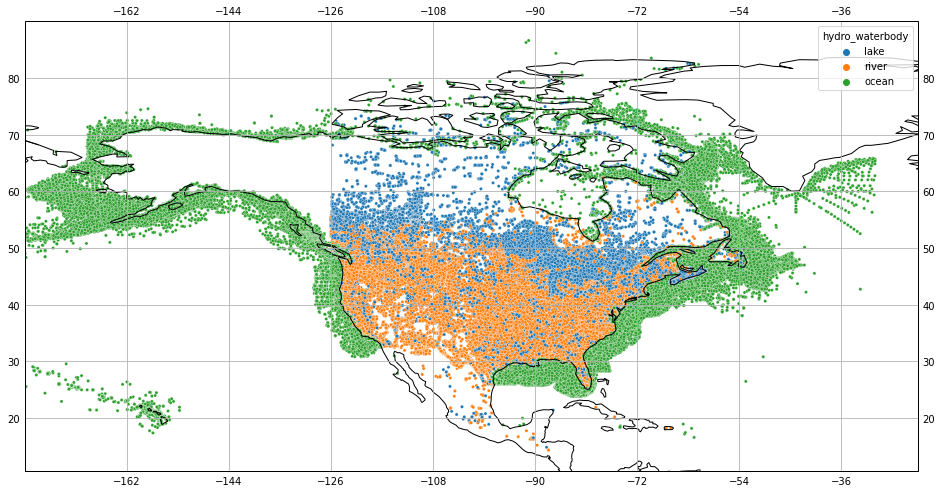

CPU times: user 37.2 s, sys: 1.55 s, total: 38.8 s
Wall time: 38.2 s


In [12]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df['longitude'], df['latitude'], hue = df['hydro_waterbody'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

In [30]:
df_lake_unknown = df.loc[df['hydro_waterbody'].isin(['lake', 'unknown'])]
df_lake_river = df.loc[df['hydro_waterbody'].isin(['lake', 'river'])]

/home/arshad/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


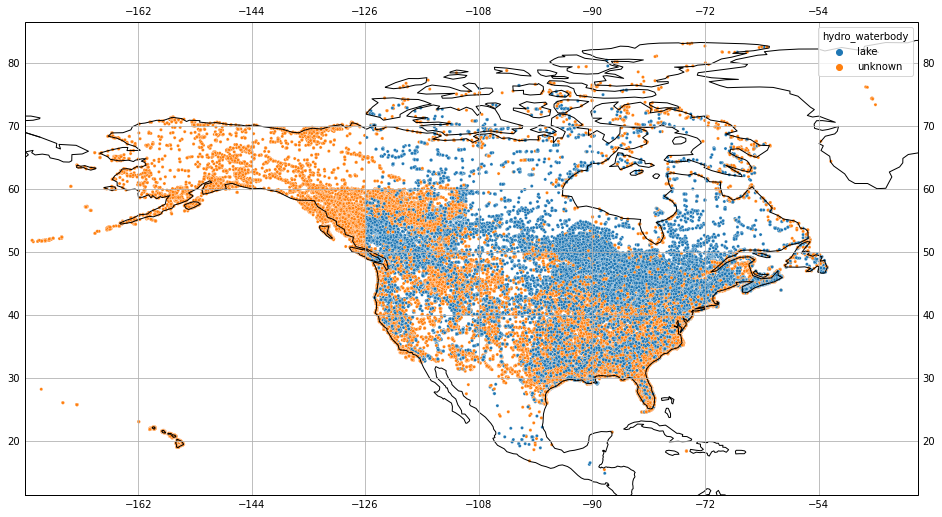

CPU times: user 15.7 s, sys: 906 ms, total: 16.6 s
Wall time: 16.2 s


In [31]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_lake_unknown['longitude'], df_lake_unknown['latitude'], hue = df_lake_unknown['hydro_waterbody'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

/home/arshad/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


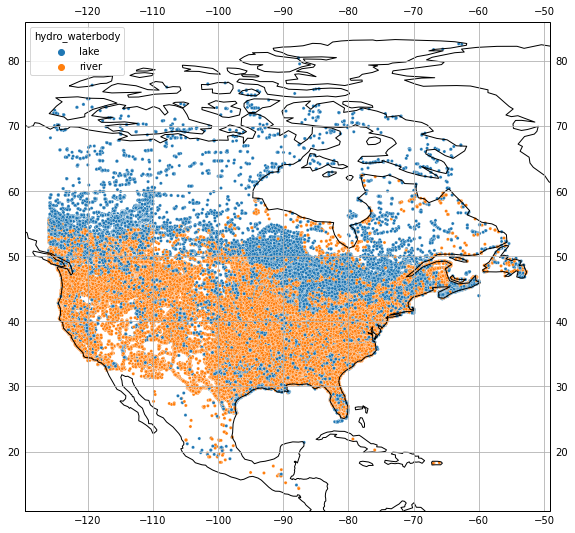

CPU times: user 27.6 s, sys: 1.86 s, total: 29.5 s
Wall time: 29.1 s


In [32]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_lake_river['longitude'], df_lake_river['latitude'], hue = df_lake_river['hydro_waterbody'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

# Hydrobasins

In [12]:
basins = gpd.read_file('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/Hydrobasins/na_bas_15s_beta.shp', 
                             ignore_geometry=True)
display(basins.head())

BASIN_ID  AREA_SQKM
0         1        0.1
1         2        0.2
2         3        0.2
3         4        0.2
4         5        0.2

In [7]:
len(canada_shape)

225822

In [8]:
canada_shape['PRUID'].unique()

array(['10', '60', '61', '62', '73', '12', '13', '24', '35', '46', '47',
       '48', '59', '11'], dtype=object)

In [9]:
canada_shape['RANK'].unique()

array([6, 5, 7, 2, 4, 3, 1])

In [4]:
today_date

'jun_17'

# Unidentified Location

In [7]:
df_unidentified = df.loc[df['hydro_waterbody'] == 'unknown']
df_unidentified.drop(columns=['hydro_match', 'hydro_dist', 'hydro_id',
       'ocean', 'match2river', 'river_hydro_dist', 'river_hydro_id',
       'hydro_waterbody'], inplace=True)
print(len(df_unidentified))
display(df_unidentified)

110448


latitude   longitude
91      46.048779  -73.099504
96      45.875197  -73.278105
219     46.679123  -71.809516
230     47.021542  -70.676605
237     47.214796  -70.273828
...           ...         ...
949803  61.693130 -150.312200
949805  60.056000 -151.663100
949806  61.534090 -149.267000
949807  59.457950 -139.571400
949808  61.520890 -148.954400

[110448 rows x 2 columns]

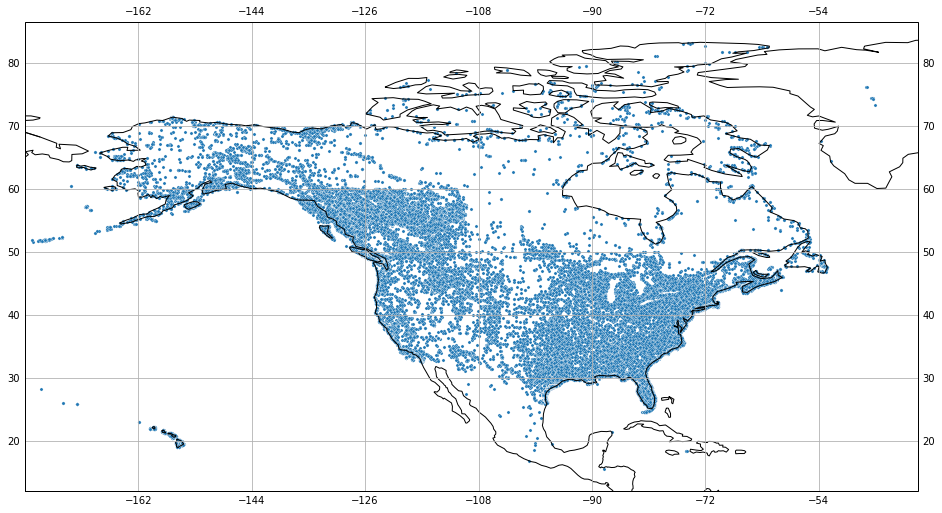

CPU times: user 938 ms, sys: 1.03 s, total: 1.97 s
Wall time: 1.28 s


In [8]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_unidentified['longitude'], df_unidentified['latitude'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

In [39]:
import pgeocode
import geopandas
from geopy.geocoders import Nominatim
import reverse_geocoder as rg

In [42]:
rg.search((46.048779, -73.099504))

Loading formatted geocoded file...


[OrderedDict([('lat', '46.03336'),
              ('lon', '-73.11585'),
              ('name', 'Sorel-Tracy'),
              ('admin1', 'Quebec'),
              ('admin2', 'Monteregie'),
              ('cc', 'CA')])]

In [15]:
location = geolocator.reverse('46.048779'+","+'-73.099504')

In [45]:
df_unidentified['lat_long'] = df_unidentified['latitude'].astype(str) + ',' + df_unidentified['longitude'].astype(str)
df_unidentified

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


latitude   longitude                      lat_long
91      46.048779  -73.099504  46.048779,-73.09950400000001
96      45.875197  -73.278105  45.875197,-73.27810500000001
219     46.679123  -71.809516          46.679123,-71.809516
230     47.021542  -70.676605  47.021542,-70.67660500000001
237     47.214796  -70.273828  47.214796,-70.27382800000001
...           ...         ...                           ...
949803  61.693130 -150.312200            61.69313,-150.3122
949805  60.056000 -151.663100              60.056,-151.6631
949806  61.534090 -149.267000             61.53409,-149.267
949807  59.457950 -139.571400            59.45795,-139.5714
949808  61.520890 -148.954400            61.52089,-148.9544

[110448 rows x 3 columns]

In [25]:
%%time
df_unidentified['geopy'] = df_unidentified.swifter.apply(lambda row: geolocator.reverse(df_unidentified['lat_long']).raw['address'], 
                                                         axis=1)

ValueError: Must be a coordinate pair or Point

In [20]:
location.raw['address']['country']

'Canada'

In [22]:
str(df_unidentified['latitude']) +","+ str(df_unidentified['longitude'])

'91        46.048779\n96        45.875197\n219       46.679123\n230       47.021542\n237       47.214796\n            ...    \n949803    61.693130\n949805    60.056000\n949806    61.534090\n949807    59.457950\n949808    61.520890\nName: latitude, Length: 110448, dtype: float64,91        -73.099504\n96        -73.278105\n219       -71.809516\n230       -70.676605\n237       -70.273828\n             ...    \n949803   -150.312200\n949805   -151.663100\n949806   -149.267000\n949807   -139.571400\n949808   -148.954400\nName: longitude, Length: 110448, dtype: float64'

# Provinces and states shapefile

In [9]:
%%time
shapefilename = '/mnt/c/Users/imrit/Downloads/Shapefiles/Canada_provinces/lpr_000b16a_e.shp'
province = gpd.read_file(shapefilename)
province

PRUID                                             PRNAME  \
0     10  Newfoundland and Labrador / Terre-Neuve-et-Lab...   
1     11       Prince Edward Island / Île-du-Prince-Édouard   
2     12                      Nova Scotia / Nouvelle-Écosse   
3     13                  New Brunswick / Nouveau-Brunswick   
4     24                                    Quebec / Québec   
5     35                                            Ontario   
6     46                                           Manitoba   
7     47                                       Saskatchewan   
8     48                                            Alberta   
9     59            British Columbia / Colombie-Britannique   
10    60                                              Yukon   
11    61  Northwest Territories / Territoires du Nord-Ouest   
12    62                                            Nunavut   

                      PRENAME                    PRFNAME PREABBR   PRFABBR  \
0   Newfoundland and Labrador    Terre-Neuve-et-Labrador    N.L.  T.-N.-L.   
1        Prince Edward Island      Île-du-Prince-Édouard  P.E.I.  Î.-P.-É.   
2                 Nova Scotia            Nouvelle-Écosse    N.S.     N.-É.   
3               New Brunswick          Nouveau-Brunswick    N.B.     N.-B.   
4                      Quebec                     Québec    Que.        Qc   
5                     Ontario                    Ontario    Ont.      Ont.   
6                    Manitoba                   Manitoba    Man.      Man.   
7                Saskatchewan               Saskatchewan   Sask.     Sask.   
8                     Alberta                    Alberta   Alta.      Alb.   
9            British Columbia       Colombie-Britannique    B.C.     C.-B.   
10                      Yukon                      Yukon    Y.T.        Yn   
11      Northwest Territories  Territoires du Nord-Ouest  N.W.T.   T.N.-O.   
12                    Nunavut                    Nunavut    Nvt.        Nt   

                                             geometry  
0   MULTIPOLYGON (((8307365.589 2582136.711, 83083...  
1   MULTIPOLYGON (((8435711.754 1679935.966, 84358...  
2   MULTIPOLYGON (((8470851.646 1624745.011, 84710...  
3   MULTIPOLYGON (((8176224.537 1722553.460, 81762...  
4   MULTIPOLYGON (((8399709.494 2261445.703, 84005...  
5   MULTIPOLYGON (((6378815.614 2295412.440, 63787...  
6   MULTIPOLYGON (((6039656.509 2636304.343, 60396...  
7   POLYGON ((5248633.914 2767057.263, 5249285.640...  
8   POLYGON ((5228304.177 2767597.891, 5228098.463...  
9   MULTIPOLYGON (((4018904.414 3410247.271, 40194...  
10  MULTIPOLYGON (((4593284.320 4180399.606, 45933...  
11  MULTIPOLYGON (((4709778.780 4202808.109, 47096...  
12  MULTIPOLYGON (((6105932.626 3935743.411, 61062...

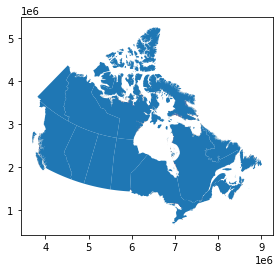

In [10]:
province.loc[:, 'geometry'].plot()

In [63]:
sample_unidentified = df_unidentified.sample(100)
sample_unidentified

latitude   longitude
925262  36.377472 -114.443746
81088   54.282865 -117.946746
910483  29.331390  -94.801940
721930  34.816002  -77.154297
293913  54.981513 -120.774894
...           ...         ...
502873  44.357297  -68.898769
929334  27.867778  -97.083333
121551  52.930508 -116.561858
927484  27.305556  -97.631111
301118  56.524579 -129.512694

[100 rows x 2 columns]

In [129]:
%%time
df_unidentified['address'] = df_unidentified.apply(lambda row: geocoder.osm([row['latitude'], 
                                                                                     row['longitude']], 
                                                                                     method='reverse').json['address'], 
                                                            axis=1)

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


TypeError: 'NoneType' object is not subscriptable

In [126]:
test_provinces['te'] = test_provinces['province'].str.split(',').str[-4:]
test_provinces

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


province  \
925262  Rogers Spring, Northshore Road, Clark County, ...   
81088    Municipal District of Greenview, Alberta, Canada   
910483  Galveston, Galveston County, Texas, United States   
721930  Long Point Road, Jones County, North Carolina,...   
293913  Area D (Kiskatinaw Valley), Peace River Region...   
...                                                   ...   
502873  Meadow Pond Road, Islesboro, Waldo County, Mai...   
929334  Aransas Pass, Nueces County, Texas, 78373, Uni...   
121551     Highway 40, Yellowhead County, Alberta, Canada   
927484               Kleberg County, Texas, United States   
301118  Cassiar Highway, Area A (Nass Valley/Bell Irvi...   

                                                       te  
925262  [ Northshore Road,  Clark County,  Nevada,  Un...  
81088   [Municipal District of Greenview,  Alberta,  C...  
910483  [Galveston,  Galveston County,  Texas,  United...  
721930  [ Jones County,  North Carolina,  28582,  Unit...  
293913  [Area D (Kiskatinaw Valley),  Peace River Regi...  
...                                                   ...  
502873    [ Waldo County,  Maine,  04848,  United States]  
929334   [ Nueces County,  Texas,  78373,  United States]  
121551  [Highway 40,  Yellowhead County,  Alberta,  Ca...  
927484           [Kleberg County,  Texas,  United States]  
301118  [ Area A (Nass Valley/Bell Irving),  Regional ...  

[100 rows x 2 columns]

In [148]:
import requests

from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point


data = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()

countries = {}
for feature in data["features"]:
    geom = feature["geometry"]
    country = feature["properties"]["ADMIN"]
    countries[country] = prep(shape(geom))

print(len(countries))

255


In [154]:
def get_country(lon, lat):
    point = Point(lon, lat)
    for country, geom in countries.items():
        if geom.contains(point):
            return country

    return "unknown"

print(get_country(-73.099504, 46.048779))

Canada


In [159]:
df_unidentified['country'] = df_unidentified.apply(lambda row: get_country(row['longitude'], row['latitude']), axis=1)

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [163]:
df_unidentified['country'].value_counts(dropna=False)

Canada                                  51951
United States of America                42777
unknown                                 15667
Mexico                                     40
Greenland                                  10
United States Minor Outlying Islands        2
Honduras                                    1
Name: country, dtype: int64

In [164]:
# df_unidentified.to_csv('/mnt/c/Users/imrit/Desktop/jul_08_unidentified_locations.csv', index=False)

In [8]:
import cartopy

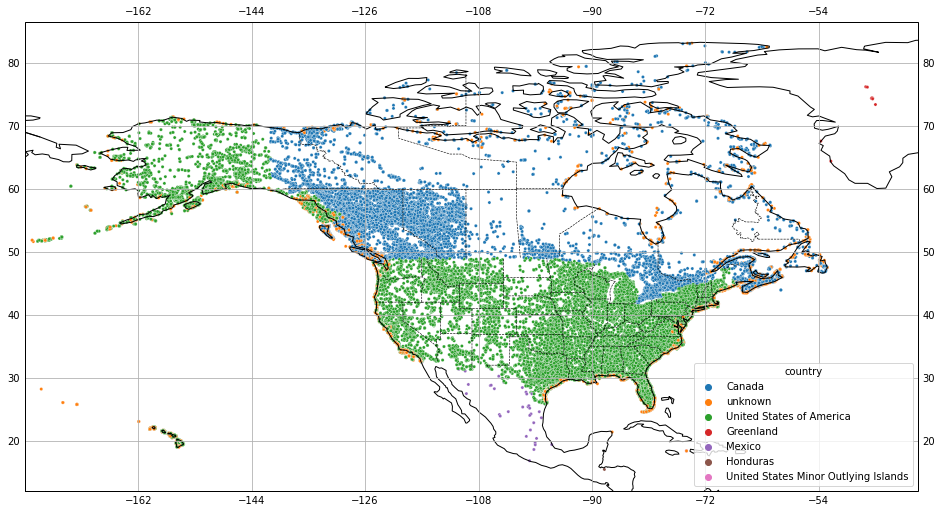

CPU times: user 4.16 s, sys: 438 ms, total: 4.59 s
Wall time: 3.93 s


In [10]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_unidentified['longitude'], df_unidentified['latitude'], hue = df_unidentified['country'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

resol = '50m'
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

graph.show()

In [169]:
df_unidentified['lat_long'] = df_unidentified['latitude'].map(str) + ',' + df_unidentified['longitude'].map(str)
df_canada = df_unidentified.loc[df_unidentified['country'] == 'Canada']
df_canada

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


latitude   longitude country                      lat_long
91      46.048779  -73.099504  Canada  46.048779,-73.09950400000001
237     47.214796  -70.273828  Canada  47.214796,-70.27382800000001
266     45.920765  -75.245955  Canada  45.920765,-75.24595500000001
269     45.932440  -75.257616  Canada           45.93244,-75.257616
317     46.105279  -75.345767  Canada  46.105279,-75.34576700000001
...           ...         ...     ...                           ...
949740  66.500000 -138.416700  Canada                66.5,-138.4167
949783  61.881940 -134.916700  Canada            61.88194,-134.9167
949784  62.177780 -133.216700  Canada  62.177780000000006,-133.2167
949790  60.566670 -134.900000  Canada               60.56667,-134.9
949792  60.696820 -135.041900  Canada            60.69682,-135.0419

[51951 rows x 4 columns]

# Get provinces

In [35]:
import pandas as pd
import geopandas as gpd
import geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [36]:
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.0001)

In [4]:
df_unidentified = pd.read_csv('/mnt/c/Users/imrit/Desktop/jul_08_unidentified_locations.csv')
df_unidentified['lat_long'] = df_unidentified['latitude'].map(str) + ',' + df_unidentified['longitude'].map(str)
df_canada = df_unidentified.loc[df_unidentified['country'] == 'Canada']
df_canada

latitude   longitude country                      lat_long
0       46.048779  -73.099504  Canada  46.048779,-73.09950400000001
4       47.214796  -70.273828  Canada  47.214796,-70.27382800000001
5       45.920765  -75.245955  Canada  45.920765,-75.24595500000001
6       45.932440  -75.257616  Canada           45.93244,-75.257616
7       46.105279  -75.345767  Canada  46.105279,-75.34576700000001
...           ...         ...     ...                           ...
110388  66.500000 -138.416700  Canada                66.5,-138.4167
110424  61.881940 -134.916700  Canada            61.88194,-134.9167
110425  62.177780 -133.216700  Canada  62.177780000000006,-133.2167
110431  60.566670 -134.900000  Canada               60.56667,-134.9
110433  60.696820 -135.041900  Canada            60.69682,-135.0419

[51951 rows x 4 columns]

In [5]:
df_canada_1 = df_canada[:25000]
df_canada_2 = df_canada[25000:]

df_canada_1.to_csv('/mnt/c/Users/imrit/Desktop/jul_09_unidentified_canada_1.csv', index=False)
df_canada_2.to_csv('/mnt/c/Users/imrit/Desktop/jul_09_unidentified_canada_2.csv', index=False)

In [6]:
tqdm.pandas()

df_canada_1["address"] = df_canada_1['lat_long'].progress_apply(rgeocode)
df_canada_1.head()

 79%|███████▉  | 19856/25000 [2:45:47<42:51,  2.00it/s]  RateLimiter caught an error, retrying (0/2 tries). Called with (*('55.059771,-119.016021',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('55.059771,-119.016021',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site

RateLimiter caught an error, retrying (1/2 tries). Called with (*('55.076208,-118.782228',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/s

 79%|███████▉  | 19858/25000 [2:52:43<153:31:53, 107.49s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('55.090593000000005,-118.520124',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen

RateLimiter swallowed an error after 2 retries. Called with (*('55.090593000000005,-118.520124',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/pytho

RateLimiter caught an error, retrying (1/2 tries). Called with (*('55.069031,-118.997643',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/s

 79%|███████▉  | 19860/25000 [3:00:05<236:04:24, 165.34s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('55.072535,-118.801534',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chun

RateLimiter swallowed an error after 2 retries. Called with (*('55.072535,-118.801534',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site

100%|██████████| 25000/25000 [3:47:00<00:00,  1.84it/s]     
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
4  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
5  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
6  45.932440 -75.257616  Canada           45.93244,-75.257616   
7  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address  
0  (Rue Boucher, Sorel-Tracy, Pierre-De Saurel, M...  
4  (Parc Nautique St-Jean Port-Joli, Rue des Pion...  
5  (Montpellier, Papineau, Outaouais, Québec, Can...  
6  (Accès chalet de la Bécasse, Montpellier, Papi...  
7  (Notre-Dame-du-Laus, Antoine-Labelle, Laurenti...

In [7]:
df_canada_1.to_csv('/mnt/c/Users/imrit/Desktop/jul_09_unclassified_canada_1_address.csv', index=False)

In [8]:
tqdm.pandas()

df_canada_2["address"] = df_canada_2['lat_long'].progress_apply(rgeocode)
df_canada_2.head()

100%|██████████| 26951/26951 [3:44:59<00:00,  2.00it/s]  
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


latitude   longitude country                                lat_long  \
26652  53.412647 -117.548862  Canada                   53.412647,-117.548862   
26653  53.409618 -117.548793  Canada                   53.409618,-117.548793   
26654  53.622878 -117.242724  Canada                   53.622878,-117.242724   
26655  53.944213 -117.052823  Canada                   53.944213,-117.052823   
26656  53.379281 -117.695261  Canada  53.379281000000006,-117.69526100000002   

                                                 address  
26652  (Yellowhead Highway, Valley District, Hinton, ...  
26653  (Yellowhead Highway, Valley District, Hinton, ...  
26654  (Yellowhead County, Alberta, Canada, (53.49681...  
26655  (Yellowhead County, Alberta, Canada, (53.49681...  
26656  (Bighorn Highway, Entrance, Yellowhead County,...

In [9]:
df_canada_2.to_csv('/mnt/c/Users/imrit/Desktop/jul_09_unclassified_canada_2_address.csv', index=False)

In [11]:
df_unknown = df_unidentified.loc[df_unidentified['country'] == 'unknown']

In [12]:
tqdm.pandas()

df_unknown["address"] = df_unknown['lat_long'].progress_apply(rgeocode)
df_unknown.head()

 29%|██▉       | 4526/15667 [47:45<12:57:27,  4.19s/it]  RateLimiter caught an error, retrying (0/2 tries). Called with (*('47.307511,-122.517513',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

 80%|███████▉  | 12471/15667 [1:56:01<26:35,  2.00it/s]   RateLimiter caught an error, retrying (0/2 tries). Called with (*('25.76975,-80.1744',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=ch

RateLimiter swallowed an error after 2 retries. Called with (*('25.76975,-80.1744',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pac

RateLimiter caught an error, retrying (1/2 tries). Called with (*('25.750816,-80.194366',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

RateLimiter caught an error, retrying (1/2 tries). Called with (*('28.147778,-96.945833',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

NameError: name 'df_unknowncanada_1' is not defined

In [14]:
df_unknown.to_csv('/mnt/c/Users/imrit/Desktop/jul_09_unclassified_unknown_address.csv', index=False)

In [15]:
df_uniden_rest = df_unidentified.loc[~df_unidentified['country'].isin(['Canada', 'unknown'])]

In [17]:
tqdm.pandas()

df_uniden_rest["address"] = df_uniden_rest['lat_long'].progress_apply(rgeocode)
df_uniden_rest.head()

  3%|▎         | 1263/42830 [11:00<5:57:26,  1.94it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*('34.383333,-118.783333',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=ch

 13%|█▎        | 5622/42830 [49:08<5:08:25,  2.01it/s]  RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.139999,-96.089996',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=c

RateLimiter caught an error, retrying (1/2 tries). Called with (*('44.830002,-93.040001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5628/42830 [1:21:39<1070:30:50, 103.59s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('45.540001,-92.629997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunk

RateLimiter swallowed an error after 2 retries. Called with (*('45.540001,-92.629997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('42.700001,-91.419998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5630/42830 [1:21:59<577:57:00, 55.93s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('47.700001,-90.93',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('47.700001,-90.93',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('45.189999,-90.610001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5632/42830 [1:22:19<336:24:21, 32.56s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.68,-84.809998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('44.68,-84.809998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('44.599998,-83.650002',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5634/42830 [1:22:39<218:03:54, 21.11s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.0,-79.889999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chun

RateLimiter swallowed an error after 2 retries. Called with (*('42.0,-79.889999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-packa

RateLimiter caught an error, retrying (1/2 tries). Called with (*('42.82,-77.550003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 13%|█▎        | 5636/42830 [1:22:59<160:02:31, 15.49s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('43.200001,-75.519997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('43.200001,-75.519997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.200001,-75.510002',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5638/42830 [1:23:20<131:36:34, 12.74s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.060001,-73.980003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('42.060001,-73.980003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('41.900002,-73.849998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5640/42830 [1:23:40<117:40:39, 11.39s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.5,-109.050003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('44.5,-109.050003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('42.189999,-104.519997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/s

 13%|█▎        | 5642/42830 [1:24:00<110:50:20, 10.73s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.130001,-94.470001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('42.130001,-94.470001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('46.810001,-92.910004',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5644/42830 [1:24:20<107:30:55, 10.41s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('43.709999,-91.970001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('43.709999,-91.970001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('47.98,-91.879997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 13%|█▎        | 5646/42830 [1:24:40<105:51:43, 10.25s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('45.330002,-90.25',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('45.330002,-90.25',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('46.419998,-88.790001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5648/42830 [1:25:01<105:01:53, 10.17s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('45.779999,-87.870003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('45.779999,-87.870003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('44.07,-84.089996',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 13%|█▎        | 5650/42830 [1:25:21<104:39:06, 10.13s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.639999,-83.68',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('44.639999,-83.68',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('40.470001,-78.709999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5652/42830 [1:25:41<104:26:58, 10.11s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.34,-75.860001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('44.34,-75.860001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.25,-75.599998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 13%|█▎        | 5654/42830 [1:26:01<104:20:56, 10.10s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('39.630001,-75.339996',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter caught an error, retrying (1/2 tries). Called with (*('44.509998,-96.190002',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5657/42830 [1:26:32<115:24:31, 11.18s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('47.48,-92.779999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

 13%|█▎        | 5694/42830 [1:27:01<4:58:54,  2.07it/s]  RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.209999,-86.099998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('42.209999,-86.099998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('42.779999,-83.209999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5696/42830 [1:27:31<77:13:06,  7.49s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('43.18,-76.800003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chun

RateLimiter swallowed an error after 2 retries. Called with (*('43.18,-76.800003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.970001,-76.040001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5698/42830 [1:27:51<90:56:23,  8.82s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('38.959999,-75.800003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=

RateLimiter swallowed an error after 2 retries. Called with (*('38.959999,-75.800003',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.759998,-75.410004',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5700/42830 [1:28:12<97:39:31,  9.47s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('40.869999,-73.860001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=

RateLimiter swallowed an error after 2 retries. Called with (*('40.869999,-73.860001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.669998,-93.57',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 13%|█▎        | 5702/42830 [1:28:32<100:57:46,  9.79s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.200001,-93.5',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chun

RateLimiter swallowed an error after 2 retries. Called with (*('42.200001,-93.5',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-packa

RateLimiter caught an error, retrying (1/2 tries). Called with (*('45.009998,-93.139999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5704/42830 [1:28:52<102:34:16,  9.95s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('43.880001,-89.269997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('43.880001,-89.269997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('42.580002,-85.220001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5706/42830 [1:29:12<103:19:55, 10.02s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.639999,-83.809998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('44.639999,-83.809998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.349998,-78.260002',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5708/42830 [1:29:32<103:43:31, 10.06s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('41.080002,-105.360001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunke

RateLimiter swallowed an error after 2 retries. Called with (*('41.080002,-105.360001',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site

RateLimiter caught an error, retrying (1/2 tries). Called with (*('46.259998,-86.639999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5710/42830 [1:29:53<103:54:36, 10.08s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('46.110001,-86.519997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('46.110001,-86.519997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('42.259998,-79.410004',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5712/42830 [1:30:13<103:59:05, 10.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.419998,-79.089996',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('42.419998,-79.089996',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.09,-78.18',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-packa

 13%|█▎        | 5714/42830 [1:30:33<104:01:40, 10.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.119999,-76.260002',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('42.119999,-76.260002',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('44.619999,-75.059998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5716/42830 [1:30:53<104:02:17, 10.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('43.07,-96.410004',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('43.07,-96.410004',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.299999,-95.199997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5718/42830 [1:31:13<104:02:31, 10.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('46.380001,-91.269997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('46.380001,-91.269997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('45.439999,-90.199997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5720/42830 [1:31:33<104:02:58, 10.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('42.119999,-79.099998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter swallowed an error after 2 retries. Called with (*('42.119999,-79.099998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-

RateLimiter caught an error, retrying (1/2 tries). Called with (*('43.259998,-75.629997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5722/42830 [1:31:54<104:05:27, 10.10s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('41.43,-74.349998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('41.43,-74.349998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('45.77,-92.68',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-packa

 13%|█▎        | 5724/42830 [1:32:14<104:03:21, 10.10s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('47.23,-92.059998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter swallowed an error after 2 retries. Called with (*('47.23,-92.059998',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('46.169998,-91.139999',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

 13%|█▎        | 5726/42830 [1:32:34<104:01:19, 10.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('46.52,-87.769997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chu

RateLimiter caught an error, retrying (1/2 tries). Called with (*('41.6317,-80.6489',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 14%|█▎        | 5788/42830 [2:10:26<113:47:52, 11.06s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('41.205,-85.8797',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chun

 14%|█▎        | 5807/42830 [2:55:27<22:23:25,  2.18s/it]   RateLimiter caught an error, retrying (0/2 tries). Called with (*('41.2103,-83.5153',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=c

RateLimiter swallowed an error after 2 retries. Called with (*('41.2103,-83.5153',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-pack

RateLimiter caught an error, retrying (1/2 tries). Called with (*('41.9094,-80.6997',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/site-p

 34%|███▍      | 14633/42830 [5:10:36<7:16:22,  1.08it/s]  RateLimiter caught an error, retrying (0/2 tries). Called with (*('44.45942,-115.17007',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked

RateLimiter caught an error, retrying (1/2 tries). Called with (*('35.417207,-83.283163',), **{}).
Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/arshad/miniconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arshad/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/arshad/miniconda3/lib/python3.7/si

100%|██████████| 42830/42830 [9:08:55<00:00,  1.30it/s]   
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


latitude  longitude                   country       lat_long  \
104     60.39    -151.30  United States of America   60.39,-151.3   
105     57.20    -154.54  United States of America   57.2,-154.54   
106     57.57    -154.45  United States of America  57.57,-154.45   
109     58.25    -157.38  United States of America  58.25,-157.38   
110     58.85    -158.50  United States of America   58.85,-158.5   

                                               address  
104  (Kasilof Beach Road, Kenai Peninsula, Alaska, ...  
105  (Ayakulik, Kodiak Island, Alaska, United State...  
106  (Alex Brown Street, Kodiak Island, Alaska, Uni...  
109  (Lake and Peninsula, Alaska, 99613, United Sta...  
110  (Unorganized Borough, Alaska, United States, (...

In [18]:
df_uniden_rest.to_csv('/mnt/c/Users/imrit/Desktop/jul_09_unclassified_rest_address.csv', index=False)

In [13]:
unidentified = []

files = [file for file in os.listdir('/mnt/c/Users/imrit/Desktop/') if '_address' in file]

progress_bar = tqdm(files)

for file in progress_bar:
    progress_bar.set_description("Processing %s" % file)
    df = pd.read_csv(f'/mnt/c/Users/imrit/Desktop/{file}')
    unidentified.append(df)
    
unidentified = pd.concat(unidentified)
print(len(unidentified))
display(unidentified)

Processing jul_09_unclassified_unknown_address.csv: 100%|██████████| 4/4 [00:00<00:00, 10.97it/s] 

110448


latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
15662  56.076810 -131.077000  unknown             56.07681,-131.077   
15663  55.817480 -130.933300  unknown            55.81748,-130.9333   
15664  60.463590 -144.889200  unknown            60.46359,-144.8892   
15665  59.907210 -149.738500  unknown            59.90721,-149.7385   
15666  64.504360 -165.423500  unknown   64.50435999999999,-165.4235   

                                                 address  
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...  
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...  
2       Montpellier, Papineau, Outaouais, Québec, Canada  
3      Accès chalet de la Bécasse, Montpellier, Papin...  
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...  
...                                                  ...  
15662           Ketchikan Gateway, Alaska, United States  
15663           Ketchikan Gateway, Alaska, United States  
15664         Unorganized Borough, Alaska, United States  
15665             Kenai Peninsula, Alaska, United States  
15666  Seppala Drive, Nome, Alaska, 99762, United States  

[110448 rows x 5 columns]

In [14]:
province_list = ['British Columbia', 'Alberta', 'Manitoba', 'Saskatchewan', 'Ontario', 'Québec', 'Yukon', 'Nova Scotia', 
                 'Nunavut', 'Alaska', 'Prince Edward Island', 'Newfoundland', 'New Brunswick', 'Northwest Territories', 
                 "Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", 
                 "District of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", 
                 "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", 
                 "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", 
                 "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
                 "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", 
                 "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

country_list = ['Canada', 'United States']

waterbody_type_list = ['LAKE', 'RIVER', 'POND', 'CREEK', 'lake', 'river', 'pond', 'creek']

In [15]:
unidentified['province'] = unidentified['address'].str.extract("(" + "|".join(province_list) +")", expand=False)
unidentified['country_from_add'] = unidentified['address'].str.extract("(" + "|".join(country_list) +")", expand=False)
unidentified.head()

latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
1  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address province country_from_add  
0  Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...   Québec           Canada  
1  Parc Nautique St-Jean Port-Joli, Rue des Pionn...   Québec           Canada  
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec           Canada  
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec           Canada  
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec           Canada

In [27]:
canada = unidentified.loc[(unidentified['country_from_add'] == 'Canada') | (unidentified['country'] == 'Canada')]
print(len(canada))
display(canada)

print(canada['province'].value_counts(dropna=False))

55149


latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
15640  50.599000 -127.771000  unknown               50.599,-127.771   
15641  50.343100 -125.138033  unknown          50.3431,-125.1380333   
15642  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
15643  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
15644  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
15640  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
15641  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
15642  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
15643  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
15644  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add  
0               Canada  
1               Canada  
2               Canada  
3               Canada  
4               Canada  
...                ...  
15640           Canada  
15641           Canada  
15642           Canada  
15643           Canada  
15644           Canada  

[55149 rows x 7 columns]

British Columbia         28308
Alberta                  18758
Ontario                   2779
Québec                    1354
Northwest Territories      960
Nunavut                    843
Yukon                      515
Nova Scotia                503
Manitoba                   286
New Brunswick              264
Newfoundland               208
Alaska                     192
Saskatchewan                72
Prince Edward Island        57
NaN                         12
Georgia                     10
Washington                   5
Wyoming                      4
Michigan                     3
New York                     3
Mississippi                  3
Oregon                       2
Maryland                     2
Minnesota                    2
Idaho                        1
Virginia                     1
Montana                      1
Ohio                         1
Name: province, dtype: int64


# Sapna Lakes

In [59]:
sapna_bc = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Downloaded_files/sapna_bc_fish_3860_lakes.csv')
sapna_bc.dropna(subset=['UTM Zone'], inplace=True)

sapna_bc['latitude'], sapna_bc['longitude'] = np.where(sapna_bc['UTM Zone'] == 9, 
                                                       (utm.to_latlon(sapna_bc['UTM_EASTING'], sapna_bc['UTM_NORTHING'], 9, 'U')), 
                                                       np.nan)
sapna_bc['latitude'], sapna_bc['longitude'] = np.where(sapna_bc['UTM Zone'] == 10, 
                                                       (utm.to_latlon(sapna_bc['UTM_EASTING'], sapna_bc['UTM_NORTHING'], 10, 'U')), 
                                                       (sapna_bc['latitude'], sapna_bc['longitude']))
sapna_bc['latitude'], sapna_bc['longitude'] = np.where(sapna_bc['UTM Zone'] == 11, 
                                                       (utm.to_latlon(sapna_bc['UTM_EASTING'], sapna_bc['UTM_NORTHING'], 11, 'U')), 
                                           (sapna_bc['latitude'], sapna_bc['longitude']))
sapna_bc['index_val'] = sapna_bc.index
sapna_bc['index_val'] = sapna_bc['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sapna_bc['made_up_code'] = 'C_BC_S_' + sapna_bc['index_val']

sapna_bc = sapna_bc[['latitude', 'longitude', 'made_up_code', 'Surface Area', 'max_depth_m', 'mean_depth_m']]
sapna_bc.rename(columns = {'Surface Area': 'surface_area_ha'}, inplace=True)

sapna_bc.head()

latitude   longitude   made_up_code  surface_area_ha  max_depth_m  \
0  51.536928 -120.899157  C_BC_S_000000             0.19          NaN   
1  49.208722 -121.665403  C_BC_S_000001             0.27          5.5   
2  58.415997 -121.353056  C_BC_S_000002             0.36          6.2   
3  49.307259 -122.090631  C_BC_S_000003             0.39          2.5   
4  49.495431 -122.737234  C_BC_S_000004             0.59          5.0   

   mean_depth_m  
0           NaN  
1           2.3  
2           2.6  
3           0.8  
4           2.6

In [60]:
sapna_alberta = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Downloaded_files/sapna_alberta_fish_lakes.csv')
sapna_alberta = sapna_alberta[['lake_name', 'latitude', 'longitude', 'surface_area_ha', 'max_depth_m', 'mean_depth_m']]

sapna_alberta['index_val'] = sapna_alberta.index
sapna_alberta['index_val'] = sapna_alberta['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sapna_alberta['made_up_code'] = 'C_ALB_S_' + sapna_alberta['index_val']

sapna_alberta.drop(columns = ['index_val'], inplace=True)

sapna_alberta

lake_name   latitude  longitude  surface_area_ha  max_depth_m  \
0       Beaver  53.250000 -117.43333             3.75         1.60   
1      Unnamed  54.633330 -113.58300             3.75         4.60   
2      Unnamed  53.516667 -117.66667             3.75         1.50   
3        Gregg  53.650000 -117.68333             6.43         4.50   
4      Emerson  53.733330 -117.80000             7.50         7.25   
..         ...        ...        ...              ...          ...   
154      Potts  59.750000 -110.47000              NaN          NaN   
155  St. Agnes  59.680000 -110.23000              NaN          NaN   
156      Tulip  59.900000 -111.13000              NaN          NaN   
157     Weekes  59.720000 -110.00000              NaN          NaN   
158      Wylie  59.320000 -110.38000              NaN          NaN   

     mean_depth_m    made_up_code  
0             NaN  C_ALB_S_000000  
1             NaN  C_ALB_S_000001  
2             NaN  C_ALB_S_000002  
3             NaN  C_ALB_S_000003  
4             NaN  C_ALB_S_000004  
..            ...             ...  
154           NaN  C_ALB_S_000154  
155           NaN  C_ALB_S_000155  
156           NaN  C_ALB_S_000156  
157           NaN  C_ALB_S_000157  
158           NaN  C_ALB_S_000158  

[159 rows x 7 columns]

In [61]:
sapna_manitoba = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Downloaded_files/sapna_manitoba_fish_lakes.csv')
sapna_manitoba.dropna(subset=['latitude'], inplace=True)

sapna_manitoba.rename(columns = {'WATERBODY': 'lake_name'}, inplace=True)
sapna_manitoba = sapna_manitoba[['latitude', 'longitude', 'max_depth_m', 'mean_depth_m', 'lake_name']]

sapna_manitoba['index_val'] = sapna_manitoba.index
sapna_manitoba['index_val'] = sapna_manitoba['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sapna_manitoba['made_up_code'] = 'C_MAN_S_' + sapna_manitoba['index_val']

sapna_manitoba.drop(columns = ['index_val'], inplace=True)
sapna_manitoba

latitude  longitude  max_depth_m  mean_depth_m      lake_name  \
0    49.69583  -95.17028         30.5           0.0             47   
1    49.72807  -95.20389         12.2           0.0             52   
2    49.81333  -95.20944          5.8           0.0            137   
3    49.96306  -95.28000         24.1           0.0            211   
4    50.09639  -95.38944          0.9           0.0            235   
..        ...        ...          ...           ...            ...   
597  59.90250 -100.66250          NaN           NaN           8784   
598  59.19694  -98.55444          NaN           NaN           8822   
601  50.75389  -96.15278          NaN           NaN           9328   
897  58.71667  -99.20000          NaN           NaN  ROBINSON LAKE   
905  58.13333 -101.41660          NaN           NaN     SANDY LAKE   

       made_up_code  
0    C_MAN_S_000000  
1    C_MAN_S_000001  
2    C_MAN_S_000002  
3    C_MAN_S_000003  
4    C_MAN_S_000004  
..              ...  
597  C_MAN_S_000597  
598  C_MAN_S_000598  
601  C_MAN_S_000601  
897  C_MAN_S_000897  
905  C_MAN_S_000905  

[426 rows x 6 columns]

In [62]:
sapna_nfdl = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Downloaded_files/sapna_nfdl_fish_lakes.csv')
sapna_nfdl.dropna(subset=['latitude'], inplace=True)

sapna_nfdl.rename(columns = {'POND': 'lake_name', 'MX_Z': 'max_depth_m'}, inplace=True)
sapna_nfdl = sapna_nfdl[['latitude', 'longitude', 'surface_area_ha', 'max_depth_m', 'lake_name']]

sapna_nfdl['index_val'] = sapna_nfdl.index
sapna_nfdl['index_val'] = sapna_nfdl['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sapna_nfdl['made_up_code'] = 'C_NFDL_S_' + sapna_nfdl['index_val']

sapna_nfdl.drop(columns = ['index_val'], inplace=True)
sapna_nfdl

latitude  longitude  surface_area_ha  max_depth_m     lake_name  \
0       48.51     -53.83              0.7          2.1  Shallow Pond   
1       49.67     -57.98              1.0          1.1  Pond Point B   
2       48.60     -53.98              1.2          5.2  Pinehill Pon   
3       48.51     -53.82              2.0          3.0  Shallow Pond   
4       51.57     -55.52              3.0         16.0  Black Duck P   
..        ...        ...              ...          ...           ...   
144     49.07     -54.12           1094.1          9.5  Indian Bay B   
145     49.39     -58.02           1112.0        130.0   Upper Trout   
146     49.18     -54.00           1963.8          NaN  Ten Mile Pon   
147     49.73     -57.77           2278.0        107.0  Western Broo   
148     51.10     -56.69           3263.0          NaN  Ten Mile Pon   

        made_up_code  
0    C_NFDL_S_000000  
1    C_NFDL_S_000001  
2    C_NFDL_S_000002  
3    C_NFDL_S_000003  
4    C_NFDL_S_000004  
..               ...  
144  C_NFDL_S_000144  
145  C_NFDL_S_000145  
146  C_NFDL_S_000146  
147  C_NFDL_S_000147  
148  C_NFDL_S_000148  

[149 rows x 6 columns]

In [63]:
sapna_saskatchewan = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Downloaded_files/sapna_saskatchewan_fish_lakes.csv')
sapna_saskatchewan.dropna(subset=['latitude'], inplace=True)

sapna_saskatchewan.rename(columns = {'AvgOfZmax_metres': 'max_depth_m'}, inplace=True)
sapna_saskatchewan = sapna_saskatchewan[['latitude', 'longitude', 'surface_area_ha', 'max_depth_m', 'lake_name']]

sapna_saskatchewan['index_val'] = sapna_saskatchewan.index
sapna_saskatchewan['index_val'] = sapna_saskatchewan['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sapna_saskatchewan['made_up_code'] = 'C_SASK_S_' + sapna_saskatchewan['index_val']

sapna_saskatchewan.drop(columns = ['index_val'], inplace=True)
sapna_saskatchewan

latitude  longitude  surface_area_ha  max_depth_m     lake_name  \
0    49.14597 -104.18650                0          NaN          ALMA   
1    49.17779 -106.15100                0          NaN        POPLAR   
2    49.17779 -106.15100                0          NaN        POPLAR   
3    49.25000 -104.08333                0          NaN  LITTLE GOOSE   
4    49.60000 -103.80000                0          NaN        NICKLE   
..        ...        ...              ...          ...           ...   
582  57.71358 -109.36740              945       82.000        BROACH   
583  58.25000 -103.25000           206197       90.000     WOLLASTON   
584  54.57248 -109.95710             9322       99.060          COLD   
585  59.29272 -109.10950           559430      123.444     ATHABASCA   
586  57.25000 -102.25000           446415      200.000      REINDEER   

        made_up_code  
0    C_SASK_S_000000  
1    C_SASK_S_000001  
2    C_SASK_S_000002  
3    C_SASK_S_000003  
4    C_SASK_S_000004  
..               ...  
582  C_SASK_S_000582  
583  C_SASK_S_000583  
584  C_SASK_S_000584  
585  C_SASK_S_000585  
586  C_SASK_S_000586  

[587 rows x 6 columns]

In [104]:
sapna_quebec = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Downloaded_files/sapna_quebec_fish_lakes_compiles.csv')
sapna_quebec.dropna(subset=['latitude'], inplace=True)

sapna_quebec = sapna_quebec[['latitude', 'longitude', 'surface_area_ha', 'max_depth_m', 'lake_name']]

sapna_quebec['index_val'] = sapna_quebec.index
sapna_quebec['index_val'] = sapna_quebec['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sapna_quebec['made_up_code'] = 'C_QC_S_' + sapna_quebec['index_val']

sapna_quebec.drop(columns = ['index_val'], inplace=True)
sapna_quebec

latitude  longitude  surface_area_ha  max_depth_m  \
0    45.363000 -66.629000             15.9          3.0   
1    45.446000 -66.679000             23.8          NaN   
2    45.364000 -66.717000             26.3         11.0   
3    45.414000 -66.715000             26.8          NaN   
4    45.300000 -66.667000             29.1          NaN   
..         ...        ...              ...          ...   
156  52.510000 -76.270000         109890.0          NaN   
157  52.510000 -76.270000         109890.0          NaN   
158  51.111111 -73.363889         211343.0          NaN   
159  53.750000 -77.000000         283500.0          NaN   
160  53.500000 -68.500000         428500.0          NaN   

                 lake_name   made_up_code  
0      Cranberry (Tomoowa)  C_QC_S_000000  
1                    Deer   C_QC_S_000001  
2                    Cundy  C_QC_S_000002  
3         Little McDougall  C_QC_S_000003  
4                    Smith  C_QC_S_000004  
..                     ...            ...  
156                    Low  C_QC_S_000156  
157          Low Reservoir  C_QC_S_000157  
158        LAC MISTASSINI   C_QC_S_000158  
159              Robertson  C_QC_S_000159  
160  Caniapiscau Reservoir  C_QC_S_000160  

[161 rows x 6 columns]

In [111]:
sapna_lakes = pd.concat([sapna_alberta, sapna_bc, sapna_manitoba, sapna_nfdl, sapna_quebec, sapna_saskatchewan])
sapna_lakes.reset_index(drop=True, inplace=True)

for col in ['latitude', 'longitude']:
    sapna_lakes[col] = sapna_lakes[col].astype(float)

print(len(sapna_lakes))
display(sapna_lakes.head())

5217


lake_name   latitude  longitude  surface_area_ha  max_depth_m  mean_depth_m  \
0    Beaver  53.250000 -117.43333             3.75         1.60           NaN   
1   Unnamed  54.633330 -113.58300             3.75         4.60           NaN   
2   Unnamed  53.516667 -117.66667             3.75         1.50           NaN   
3     Gregg  53.650000 -117.68333             6.43         4.50           NaN   
4   Emerson  53.733330 -117.80000             7.50         7.25           NaN   

     made_up_code  
0  C_ALB_S_000000  
1  C_ALB_S_000001  
2  C_ALB_S_000002  
3  C_ALB_S_000003  
4  C_ALB_S_000004

In [112]:
%%time
sapna_lakes['hydro_match'] = sapna_lakes.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)
sapna_lakes[['hydro_dist', 'hydro_id']] = pd.DataFrame(sapna_lakes['hydro_match'].tolist(), index= sapna_lakes.index)
print(len(sapna_lakes))
display(sapna_lakes)


5217


lake_name   latitude  longitude  surface_area_ha  max_depth_m  \
0        Beaver  53.250000 -117.43333             3.75        1.600   
1       Unnamed  54.633330 -113.58300             3.75        4.600   
2       Unnamed  53.516667 -117.66667             3.75        1.500   
3         Gregg  53.650000 -117.68333             6.43        4.500   
4       Emerson  53.733330 -117.80000             7.50        7.250   
...         ...        ...        ...              ...          ...   
5212     BROACH  57.713580 -109.36740           945.00       82.000   
5213  WOLLASTON  58.250000 -103.25000        206197.00       90.000   
5214       COLD  54.572480 -109.95710          9322.00       99.060   
5215  ATHABASCA  59.292720 -109.10950        559430.00      123.444   
5216   REINDEER  57.250000 -102.25000        446415.00      200.000   

      mean_depth_m     made_up_code                  hydro_match  hydro_dist  \
0              NaN   C_ALB_S_000000                   [nan, nan]         NaN   
1              NaN   C_ALB_S_000001   [791.8948739273071, 82190]  791.894874   
2              NaN   C_ALB_S_000002                   [nan, nan]         NaN   
3              NaN   C_ALB_S_000003  [400.5451035494482, 858512]  400.545104   
4              NaN   C_ALB_S_000004                   [nan, nan]         NaN   
...            ...              ...                          ...         ...   
5212           NaN  C_SASK_S_000582                 [0.0, 70114]    0.000000   
5213           NaN  C_SASK_S_000583                    [0.0, 32]    0.000000   
5214           NaN  C_SASK_S_000584                   [0.0, 551]    0.000000   
5215           NaN  C_SASK_S_000585                    [0.0, 33]    0.000000   
5216           NaN  C_SASK_S_000586                    [0.0, 38]    0.000000   

      hydro_id  
0          NaN  
1      82190.0  
2          NaN  
3     858512.0  
4          NaN  
...        ...  
5212   70114.0  
5213      32.0  
5214     551.0  
5215      33.0  
5216      38.0  

[5217 rows x 10 columns]

CPU times: user 3min 22s, sys: 1min 1s, total: 4min 24s
Wall time: 4min 21s


In [113]:
sapna_lakes.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/sapna_lakes_lat_longs_hydro_match.csv', index=False)

# BC Locations

In [127]:
canada_unidentified = pd.read_csv('/mnt/c/Users/imrit/Desktop/canada_unidentified_locations.csv')
display(canada_unidentified)
print(len(canada_unidentified))

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55156  50.599000 -127.771000  unknown               50.599,-127.771   
55157  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55158  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55159  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55160  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55156  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55157  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55158  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55159  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55160  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add  
0               Canada  
1               Canada  
2               Canada  
3               Canada  
4               Canada  
...                ...  
55156           Canada  
55157           Canada  
55158           Canada  
55159           Canada  
55160           Canada  

[55161 rows x 7 columns]

55161


In [114]:
nuseds_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/HAS_WATERBODY_TYPE/nuseds_excapement_occurence_1920_2019.csv')
nuseds_lakes.drop(columns=['year'], inplace=True)
nuseds_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)
nuseds_lakes = nuseds_lakes.loc[nuseds_lakes['site_description'].isin(['Lake Portion', 'Lake'])]
nuseds_lakes = nuseds_lakes[['latitude', 'longitude', 'waterbody_name']]
nuseds_lakes['hydro_waterbody'] = 'lake'

print(len(nuseds_lakes))
display(nuseds_lakes.head())

45


latitude   longitude                waterbody_name hydro_waterbody
3     50.548157 -122.468802  ANDERSON LAKE-SHORE SPAWNERS            lake
688   49.395436 -122.559996                     PITT LAKE            lake
2700  52.601106 -121.547077                  QUESNEL LAKE            lake
3090  50.815711 -118.984353                     MARA LAKE            lake
4949  51.102254 -124.031879         SOUTH END CHILKO LAKE            lake

In [115]:
known_fish_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/HAS_WATERBODY_TYPE/known_fish_observation_occurence_1894_2020.csv')
known_fish_lakes.drop(columns=['year'], inplace=True)
known_fish_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)
known_fish_lakes = known_fish_lakes.loc[known_fish_lakes['site_description'] == 'Lake']
known_fish_lakes = known_fish_lakes[['latitude', 'longitude', 'waterbody_name']]
known_fish_lakes['hydro_waterbody'] = 'lake'

print(len(known_fish_lakes))
display(known_fish_lakes.head())

3023


latitude   longitude     waterbody_name hydro_waterbody
1  51.008779 -116.785807  THREE ISLAND LAKE            lake
2  50.489991 -119.834209         MONTE LAKE            lake
3  49.749064 -115.816648         HAHAS LAKE            lake
4  54.312938 -122.737491          BOOT LAKE            lake
5  49.926224 -120.568237       ALLEYNE LAKE            lake

In [116]:
aquatic_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/HAS_WATERBODY_TYPE/aquatic_invasive_specie_occurence_1908_2014.csv')
aquatic_lakes['waterbody_name'] = aquatic_lakes['waterbody_name'].str.upper()
aquatic_lakes['type'] = aquatic_lakes['waterbody_name'].str.find('LAKE')
aquatic_lakes['hydro_waterbody'] = np.where(aquatic_lakes['type'] > 0, 'lake', np.nan)

aquatic_lakes.drop(columns=['year'], inplace=True)
aquatic_lakes = aquatic_lakes.loc[aquatic_lakes['hydro_waterbody'] == 'lake']
aquatic_lakes = aquatic_lakes[['latitude', 'longitude', 'waterbody_name', 'hydro_waterbody']]
aquatic_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)

aquatic_lakes

latitude   longitude  waterbody_name hydro_waterbody
2     48.522109 -123.502400     SECOND LAKE            lake
4     58.430276 -129.993113      ALLAN LAKE            lake
5     49.234652 -122.966139       DEER LAKE            lake
6     49.767282 -120.497828  MISSEZULA LAKE            lake
9     50.491756 -120.110283        BOG LAKE            lake
...         ...         ...             ...             ...
4476  49.644141 -120.610793        DRY LAKE            lake
4479  49.600435 -120.569580  MCCAFFREY LAKE            lake
4488  49.584078 -119.833736       AGUR LAKE            lake
4490  50.539585 -120.252139    SHUMWAY LAKE            lake
4500  49.662722 -120.620207      ROUND LAKE            lake

[355 rows x 4 columns]

In [117]:
bc_extra_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/GET_WATERBODY_NAMES/bc_extra_lakes.csv')
bc_extra_lakes['waterbody_name'] = bc_extra_lakes['waterbody_name'].str.upper()
bc_extra_lakes['type'] = bc_extra_lakes['waterbody_name'].str.find('LAKE')
bc_extra_lakes['hydro_waterbody'] = np.where(bc_extra_lakes['type'] > 0, 'lake', np.nan)

bc_extra_lakes = bc_extra_lakes.loc[bc_extra_lakes['hydro_waterbody'] == 'lake']
bc_extra_lakes = bc_extra_lakes[['latitude', 'longitude', 'waterbody_name', 'hydro_waterbody']]
bc_extra_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)

bc_extra_lakes

latitude   longitude               waterbody_name hydro_waterbody
0     49.305570 -125.815830                MCINTYRE LAKE            lake
1     49.856020  124.223720                    LOIS LAKE            lake
2     49.744746 -122.140503                HARRISON LAKE            lake
37    50.609786 -127.265547     KEOGH LAKE (SEP)                    lake
44    52.403960 -125.920408         ATNARKO RIVER & LAKE            lake
206   50.539941 -127.246709     O'CONNOR LAKE                       lake
210   51.451705 -120.131371  DUNN LAKE, CREEK & HATCHERY            lake
215   49.347190 -122.642426  PITT RIVER, LAKE & HATCHERY            lake
257   53.480363 -132.355907     MARIE LAKE                          lake
461   48.793629 -124.705331     NITINAT LAKE                        lake
556   49.052407 -125.526799     KENNEDY LAKE                        lake
579   50.998678 -119.048961     SHUSWAP LAKE & RIVER                lake
628   49.322729 -121.874347     WEAVER CREEK & LAKE                 lake
849   49.078148 -121.967181     CULTUS LAKE, RIVER & LAB            lake
892   50.369177 -119.875358   SALMON R (THOMPSON) & LAKE            lake
923   52.375824 -128.206465     TANKEEAH LAKE AND RIVER             lake
989   58.989100 -130.678135     TUYA LAKE                           lake
1033  49.675302 -124.021642                 SAKINAW LAKE            lake
1064  54.010186 -127.602642          MORICE RIVER & LAKE            lake
1340  58.343802 -132.308716     TATSAMENIE LAKE                     lake
1354  49.299830 -122.481959     ALOUETTE RIVER & LAKE               lake
1404  49.297973 -121.850141        HARRISON RIVER & LAKE            lake
1408  49.081586 -121.434660      CHILLIWACK RIVER & LAKE            lake

In [119]:
bc_lakes = pd.concat([nuseds_lakes, known_fish_lakes, aquatic_lakes, bc_extra_lakes])
bc_lakes.reset_index(drop=True, inplace=True)
bc_lakes['waterbody_name'] = bc_lakes['waterbody_name'].str.upper()

bc_lakes['index_val'] = bc_lakes.index
bc_lakes['index_val'] = bc_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
bc_lakes['made_up_code'] = 'C_BC_U_' + bc_lakes['index_val']

bc_lakes.drop_duplicates(inplace=True)
bc_lakes.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/GET_WATERBODY_NAMES/bc_lakes.csv', index=False)
display(bc_lakes)

latitude   longitude                waterbody_name hydro_waterbody  \
0     50.548157 -122.468802  ANDERSON LAKE-SHORE SPAWNERS            lake   
1     49.395436 -122.559996                     PITT LAKE            lake   
2     52.601106 -121.547077                  QUESNEL LAKE            lake   
3     50.815711 -118.984353                     MARA LAKE            lake   
4     51.102254 -124.031879         SOUTH END CHILKO LAKE            lake   
...         ...         ...                           ...             ...   
3441  54.010186 -127.602642           MORICE RIVER & LAKE            lake   
3442  58.343802 -132.308716      TATSAMENIE LAKE                     lake   
3443  49.299830 -122.481959      ALOUETTE RIVER & LAKE               lake   
3444  49.297973 -121.850141         HARRISON RIVER & LAKE            lake   
3445  49.081586 -121.434660       CHILLIWACK RIVER & LAKE            lake   

     index_val   made_up_code  
0       000000  C_BC_U_000000  
1       000001  C_BC_U_000001  
2       000002  C_BC_U_000002  
3       000003  C_BC_U_000003  
4       000004  C_BC_U_000004  
...        ...            ...  
3441    003441  C_BC_U_003441  
3442    003442  C_BC_U_003442  
3443    003443  C_BC_U_003443  
3444    003444  C_BC_U_003444  
3445    003445  C_BC_U_003445  

[3446 rows x 6 columns]

In [120]:
len(bc_lakes['waterbody_name'].unique())

3103

# Alberta

In [121]:
banff_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/Alberta_processed/HAS_WATERBODY_TYPE/Banff_NP_freshwater_occurence_2017_NO_LAT_LONG.csv')
banff_lakes['hydro_waterbody'] = 'lake'
banff_lakes.drop(columns=['year'], inplace = True)
banff_lakes.drop_duplicates(subset=['waterbody_name'], inplace=True)
banff_lakes.head()

waterbody_name   latitude   longitude hydro_waterbody
0    Altrude (2)  51.230556 -116.047500            lake
1         Arnica  51.221389 -115.996944            lake
2         Badger  50.378000 -112.464700            lake
3     Baker Lake  51.492000 -116.040800            lake
4     Black Rock  51.120770 -115.915830            lake

In [122]:
fish_culture_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/Alberta_processed/HAS_WATERBODY_TYPE/fish_culture_stocking_occurence_1922_2020.csv')
fish_culture_lakes['type'] = fish_culture_lakes['waterbody_name'].str.find('LAKE')
fish_culture_lakes['hydro_waterbody'] = np.where(fish_culture_lakes['type'] > 0, 'lake', np.nan)
fish_culture_lakes = fish_culture_lakes.loc[fish_culture_lakes['hydro_waterbody'] == 'lake']

fish_culture_lakes = fish_culture_lakes[['latitude', 'longitude', 'waterbody_name', 'hydro_waterbody']]
fish_culture_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)
fish_culture_lakes

latitude   longitude         waterbody_name hydro_waterbody
0      54.053198 -111.372081           OWLSEYE LAKE            lake
1      54.143062 -111.511662        UPPER MANN LAKE            lake
2      54.614040 -112.726508          SKELETON LAKE            lake
3      54.176603 -111.516320        LOWER MANN LAKE            lake
4      54.362184 -111.889992         WHITEFISH LAKE            lake
...          ...         ...                    ...             ...
15131  53.495242 -117.804968         GRAVEYARD LAKE            lake
15143  53.488781 -117.800640             CACHE LAKE            lake
15157  53.450000 -117.800000            JARVIS LAKE            lake
15300  50.236864 -114.208020  CHAIN LAKES RESERVOIR            lake
15589  52.423051 -113.813711           LACOMBE LAKE            lake

[317 rows x 4 columns]

In [123]:
fish_survey_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/Alberta_processed/HAS_WATERBODY_TYPE/fish_survey_occurence_1942_2020.csv')
fish_survey_lakes['type'] = fish_survey_lakes['waterbody_name'].str.find('LAKE')
fish_survey_lakes['hydro_waterbody'] = np.where(fish_survey_lakes['type'] > 0, 'lake', np.nan)
fish_survey_lakes = fish_survey_lakes.loc[fish_survey_lakes['hydro_waterbody'] == 'lake']

fish_survey_lakes = fish_survey_lakes[['latitude', 'longitude', 'waterbody_name', 'hydro_waterbody']]
fish_survey_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)
fish_survey_lakes

latitude   longitude      waterbody_name hydro_waterbody
5      58.824511 -118.890802            HAY LAKE            lake
23     54.481079 -112.750999           LONG LAKE            lake
24     54.212768 -111.626503  FLOATINGSTONE LAKE            lake
25     54.143062 -111.511662     UPPER MANN LAKE            lake
27     54.362184 -111.889993      WHITEFISH LAKE            lake
...          ...         ...                 ...             ...
62874  55.920000 -110.675001           BOHN LAKE            lake
63315  52.428380 -113.798648        LACOMBE LAKE            lake
63356  54.718150 -110.657414       SINCLAIR LAKE            lake
63535  54.893110 -110.439101        LOSEMAN LAKE            lake
63783  57.067344 -115.842956        RUSSELL LAKE            lake

[492 rows x 4 columns]

In [124]:
stocking_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/Alberta_processed/HAS_WATERBODY_TYPE/stocking_2009_2015.csv')
stocking_lakes['site_description'] = np.where(stocking_lakes['site_description'].isna(), 
                                              stocking_lakes['waterbody_name'], stocking_lakes['site_description'])
stocking_lakes.drop(columns=['waterbody_name'], inplace=True)
stocking_lakes.rename(columns = {'site_description': 'waterbody_name'}, inplace=True)
stocking_lakes['type'] = stocking_lakes['waterbody_name'].str.find('LAKE')
stocking_lakes['hydro_waterbody'] = np.where(stocking_lakes['type'] > 0, 'lake', np.nan)
stocking_lakes = stocking_lakes.loc[stocking_lakes['hydro_waterbody'] == 'lake']

stocking_lakes = stocking_lakes[['latitude', 'longitude', 'waterbody_name', 'hydro_waterbody']]
stocking_lakes.drop_duplicates(subset = ['waterbody_name'], inplace = True)
stocking_lakes

latitude   longitude  waterbody_name hydro_waterbody
26    49.553784 -114.299609     BURMIS LAKE            lake
45    49.111700 -113.655837       MAMI LAKE            lake
75    53.598702 -114.530064   EAST PIT LAKE            lake
85    53.559366 -116.734669  DANDURAND LAKE            lake
88    54.212986 -112.423089   SHEMELUK LAKE            lake
...         ...         ...             ...             ...
1570  49.627778 -114.684444     ISLAND LAKE            lake
1571  53.594311 -111.296351  JACK FISH LAKE            lake
1572  49.541912 -114.248586       LEES LAKE            lake
1575  52.203976 -115.001395    STRUBEL LAKE            lake
1594  50.576929 -113.851250    EMERSON LAKE            lake

[83 rows x 4 columns]

In [125]:
alberta_lakes = pd.concat([banff_lakes, fish_culture_lakes, fish_survey_lakes, stocking_lakes])
alberta_lakes.drop_duplicates(inplace=True)
alberta_lakes.drop_duplicates(subset = ['waterbody_name'], inplace = True)

alberta_lakes.reset_index(drop = True, inplace = True)

alberta_lakes['index_val'] = alberta_lakes.index
alberta_lakes['index_val'] = alberta_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
alberta_lakes['made_up_code'] = 'C_ALB_U_' + alberta_lakes['index_val']

alberta_lakes.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/GET_WATERBODY_NAMES/alberta_lakes.csv', 
                           index=False)
print(len(alberta_lakes['waterbody_name'].unique()))
alberta_lakes

745


waterbody_name   latitude   longitude hydro_waterbody index_val  \
0              Altrude (2)  51.230556 -116.047500            lake    000000   
1                   Arnica  51.221389 -115.996944            lake    000001   
2                   Badger  50.378000 -112.464700            lake    000002   
3               Baker Lake  51.492000 -116.040800            lake    000003   
4               Black Rock  51.120770 -115.915830            lake    000004   
..                     ...        ...         ...             ...       ...   
740             STORM LAKE  50.505823 -114.943334            lake    000740   
741    UPPER HEADWALL LAKE  50.807542 -115.245079            lake    000741   
742  HOGARTH LAKES (LOWER)  50.797209 -115.322777            lake    000742   
743      TWO LAKES (NORTH)  55.300000 -117.716667            lake    000743   
744           GOLDEYE LAKE  52.449584 -116.192114            lake    000744   

       made_up_code  
0    C_ALB_U_000000  
1    C_ALB_U_000001  
2    C_ALB_U_000002  
3    C_ALB_U_000003  
4    C_ALB_U_000004  
..              ...  
740  C_ALB_U_000740  
741  C_ALB_U_000741  
742  C_ALB_U_000742  
743  C_ALB_U_000743  
744  C_ALB_U_000744  

[745 rows x 6 columns]

In [126]:
bc_alberta_lakes = pd.concat([bc_lakes, alberta_lakes])
bc_alberta_lakes.head()

latitude   longitude                waterbody_name hydro_waterbody  \
0  50.548157 -122.468802  ANDERSON LAKE-SHORE SPAWNERS            lake   
1  49.395436 -122.559996                     PITT LAKE            lake   
2  52.601106 -121.547077                  QUESNEL LAKE            lake   
3  50.815711 -118.984353                     MARA LAKE            lake   
4  51.102254 -124.031879         SOUTH END CHILKO LAKE            lake   

  index_val   made_up_code  
0    000000  C_BC_U_000000  
1    000001  C_BC_U_000001  
2    000002  C_BC_U_000002  
3    000003  C_BC_U_000003  
4    000004  C_BC_U_000004

In [128]:
canada_unidentified = canada_unidentified.merge(bc_alberta_lakes, on = ['latitude', 'longitude'], how='left')
canada_unidentified

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55191  50.599000 -127.771000  unknown               50.599,-127.771   
55192  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55193  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55194  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55195  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55191  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55192  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55193  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55194  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55195  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add waterbody_name hydro_waterbody index_val made_up_code  
0               Canada            NaN             NaN       NaN          NaN  
1               Canada            NaN             NaN       NaN          NaN  
2               Canada            NaN             NaN       NaN          NaN  
3               Canada            NaN             NaN       NaN          NaN  
4               Canada            NaN             NaN       NaN          NaN  
...                ...            ...             ...       ...          ...  
55191           Canada            NaN             NaN       NaN          NaN  
55192           Canada            NaN             NaN       NaN          NaN  
55193           Canada            NaN             NaN       NaN          NaN  
55194           Canada            NaN             NaN       NaN          NaN  
55195           Canada            NaN             NaN       NaN          NaN  

[55196 rows x 11 columns]

In [129]:
canada_unidentified.groupby(['province'])['waterbody_name', 'hydro_waterbody'].agg('count')

waterbody_name  hydro_waterbody
province                                              
Alaska                              1                1
Alberta                           133              133
British Columbia                  853              853
Georgia                             0                0
Idaho                               0                0
Manitoba                            0                0
Maryland                            0                0
Michigan                            0                0
Minnesota                           0                0
Mississippi                         0                0
Montana                             0                0
New Brunswick                       0                0
New York                            0                0
Newfoundland                        0                0
Northwest Territories               0                0
Nova Scotia                         0                0
Nunavut                             0                0
Ohio                                0                0
Ontario                             0                0
Oregon                              0                0
Prince Edward Island                0                0
Québec                              0                0
Saskatchewan                        0                0
Virginia                            0                0
Washington                          0                0
Wyoming                             0                0
Yukon                               6                6

In [130]:
canada_unidentified

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55191  50.599000 -127.771000  unknown               50.599,-127.771   
55192  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55193  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55194  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55195  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55191  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55192  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55193  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55194  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55195  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add waterbody_name hydro_waterbody index_val made_up_code  
0               Canada            NaN             NaN       NaN          NaN  
1               Canada            NaN             NaN       NaN          NaN  
2               Canada            NaN             NaN       NaN          NaN  
3               Canada            NaN             NaN       NaN          NaN  
4               Canada            NaN             NaN       NaN          NaN  
...                ...            ...             ...       ...          ...  
55191           Canada            NaN             NaN       NaN          NaN  
55192           Canada            NaN             NaN       NaN          NaN  
55193           Canada            NaN             NaN       NaN          NaN  
55194           Canada            NaN             NaN       NaN          NaN  
55195           Canada            NaN             NaN       NaN          NaN  

[55196 rows x 11 columns]

# Ontario lakes

In [52]:
ahi = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Range_shifts/Ontario/Data/ahi_unique_lakes.csv')
bsm = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Range_shifts/Ontario/Data/BSM_unique_lakes.csv')

ontario_lakes = pd.concat([ahi, bsm])

# ['wby_name', 'latitude', 'longitude', 'alt_name', 'surface_area_ha', 'max_depth',
#        'mean_depth', 'lake_elevation_(m)', 'surface_water_temp', 'conductivity_(us/cm)',
#        'secchi_depth_(m)', 'tds_(mg/l)', 'ph', 'o2']

ontario_lakes = ontario_lakes[['wby_name', 'latitude', 'longitude']]
ontario_lakes.rename(columns = {'wby_name': 'waterbody_name'}, inplace = True)
ontario_lakes['hydro_waterbody'] = 'lake'
ontario_lakes.drop_duplicates(inplace=True)

ontario_lakes.reset_index(drop = True, inplace = True)

ontario_lakes['index_val'] = ontario_lakes.index
ontario_lakes['index_val'] = ontario_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
ontario_lakes['made_up_code'] = 'C_ON_U_' + ontario_lakes['index_val']

print(len(ontario_lakes))
ontario_lakes.head()

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10727


waterbody_name   latitude  longitude hydro_waterbody index_val  \
0        Duff L.  42.126667 -83.120000            lake    000000   
1    Saunders P.  42.707778 -81.169722            lake    000001   
2   Deer Cr. Re.  42.711667 -80.565833            lake    000002   
3      Zavitz P.  42.713333 -81.118889            lake    000003   
4     Mathers P.  42.726111 -80.318056            lake    000004   

    made_up_code  
0  C_ON_U_000000  
1  C_ON_U_000001  
2  C_ON_U_000002  
3  C_ON_U_000003  
4  C_ON_U_000004

In [132]:
canada_unidentified = canada_unidentified.merge(ontario_lakes, on = ['latitude', 'longitude'], how='left', 
                                                suffixes=['_bc_alberta', '_ontario'])
canada_unidentified

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55204  50.599000 -127.771000  unknown               50.599,-127.771   
55205  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55206  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55207  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55208  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55204  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55205  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55206  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55207  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55208  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0               Canada                       NaN                        NaN   
1               Canada                       NaN                        NaN   
2               Canada                       NaN                        NaN   
3               Canada                       NaN                        NaN   
4               Canada                       NaN                        NaN   
...                ...                       ...                        ...   
55204           Canada                       NaN                        NaN   
55205           Canada                       NaN                        NaN   
55206           Canada                       NaN                        NaN   
55207           Canada                       NaN                        NaN   
55208           Canada                       NaN                        NaN   

      index_val_bc_alberta made_up_code_bc_alberta waterbody_name_ontario  \
0                      NaN                     NaN                    NaN   
1                      NaN                     NaN                    NaN   
2                      NaN                     NaN                    NaN   
3                      NaN                     NaN                    NaN   
4                      NaN                     NaN                    NaN   
...                    ...                     ...                    ...   
55204                  NaN                     NaN                    NaN   
55205                  NaN                     NaN                    NaN   
55206                  NaN                     NaN                    NaN   
55207                  NaN                     NaN                    NaN   
55208                  NaN                     NaN                    NaN   

      hydro_waterbody_ontario index_val_ontario made_up_code_ontario  
0                         NaN               NaN                  NaN  
1                         NaN               NaN                  NaN  
2                         NaN               NaN                  NaN  
3                         NaN               NaN             

### Quebec

In [134]:
quebec_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Quebec/fish_map_database_occurence_2016.csv')

quebec_lakes = quebec_lakes[['waterbody_name', 'latitude', 'longitude']]
quebec_lakes['hydro_waterbody'] = 'lake'

quebec_lakes.drop_duplicates(subset = ['waterbody_name'], inplace = True)

quebec_lakes['index_val'] = quebec_lakes.index
quebec_lakes['index_val'] = quebec_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
quebec_lakes['made_up_code'] = 'C_QC_U_' + quebec_lakes['index_val']

quebec_lakes.head()

waterbody_name   latitude  longitude hydro_waterbody index_val  \
0  Saint-François, Lac  45.095566 -74.434094            lake    000000   
1   Richelieu, Rivière  45.029876 -73.332214            lake    000001   
2         Wallace, Lac  45.015270 -71.632880            lake    000002   
3           Lippé, Lac  45.098055 -71.656944            lake    000003   
4          Lyster, Lac  45.029304 -71.907721            lake    000004   

    made_up_code  
0  C_QC_U_000000  
1  C_QC_U_000001  
2  C_QC_U_000002  
3  C_QC_U_000003  
4  C_QC_U_000004

In [135]:
canada_unidentified = canada_unidentified.merge(quebec_lakes, on = ['latitude', 'longitude'], how='left')
canada_unidentified

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55204  50.599000 -127.771000  unknown               50.599,-127.771   
55205  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55206  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55207  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55208  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55204  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55205  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55206  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55207  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55208  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0               Canada                       NaN                        NaN   
1               Canada                       NaN                        NaN   
2               Canada                       NaN                        NaN   
3               Canada                       NaN                        NaN   
4               Canada                       NaN                        NaN   
...                ...                       ...                        ...   
55204           Canada                       NaN                        NaN   
55205           Canada                       NaN                        NaN   
55206           Canada                       NaN                        NaN   
55207           Canada                       NaN                        NaN   
55208           Canada                       NaN                        NaN   

      index_val_bc_alberta made_up_code_bc_alberta waterbody_name_ontario  \
0                      NaN                     NaN                    NaN   
1                      NaN                     NaN                    NaN   
2                      NaN                     NaN                    NaN   
3                      NaN                     NaN                    NaN   
4                      NaN                     NaN                    NaN   
...                    ...                     ...                    ...   
55204                  NaN                     NaN                    NaN   
55205                  NaN                     NaN                    NaN   
55206                  NaN                     NaN                    NaN   
55207                  NaN                     NaN                    NaN   
55208                  NaN                     NaN                    NaN   

      hydro_waterbody_ontario index_val_ontario made_up_code_ontario  \
0                         NaN               NaN                  NaN   
1                         NaN               NaN                  NaN   
2                         NaN               NaN                  NaN   
3                         NaN               NaN         

### Manitoba

In [137]:
manitoba_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Manitoba/Processed/manitoba_gov_stocking_1917_2020_occurence.csv')
manitoba_lakes = manitoba_lakes[['waterbody_name', 'latitude', 'longitude']]
manitoba_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)

manitoba_lakes['type'] = manitoba_lakes['waterbody_name'].str.find('LAKE')
manitoba_lakes['hydro_waterbody'] = np.where(manitoba_lakes['type'] > 0, 'lake', np.nan)
manitoba_lakes = manitoba_lakes.loc[manitoba_lakes['hydro_waterbody'] == 'lake']

manitoba_lakes['index_val'] = manitoba_lakes.index
manitoba_lakes['index_val'] = manitoba_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
manitoba_lakes['made_up_code'] = 'C_MAN_U_' + manitoba_lakes['index_val']

manitoba_lakes = manitoba_lakes[['waterbody_name', 'latitude', 'longitude', 'hydro_waterbody', 'made_up_code']]
manitoba_lakes.head()

waterbody_name   latitude   longitude hydro_waterbody    made_up_code
2        HUNT LAKE  49.742504  -95.177395            lake  C_MAN_U_000002
3       LYONS LAKE  49.733471  -95.177634            lake  C_MAN_U_000003
5         OAK LAKE  49.671829 -100.749836            lake  C_MAN_U_000005
6   PATTERSON LAKE  50.647777 -100.582497            lake  C_MAN_U_000006
12    SINGUSH LAKE  51.605819 -100.794444            lake  C_MAN_U_000012

In [138]:
canada_unidentified = canada_unidentified.merge(manitoba_lakes, on = ['latitude', 'longitude'], how='left', 
                                                suffixes=['_quebec', '_manitoba'])
canada_unidentified

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55204  50.599000 -127.771000  unknown               50.599,-127.771   
55205  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55206  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55207  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55208  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55204  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55205  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55206  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55207  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55208  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0               Canada                       NaN                        NaN   
1               Canada                       NaN                        NaN   
2               Canada                       NaN                        NaN   
3               Canada                       NaN                        NaN   
4               Canada                       NaN                        NaN   
...                ...                       ...                        ...   
55204           Canada                       NaN                        NaN   
55205           Canada                       NaN                        NaN   
55206           Canada                       NaN                        NaN   
55207           Canada                       NaN                        NaN   
55208           Canada                       NaN                        NaN   

      index_val_bc_alberta  ... hydro_waterbody_ontario index_val_ontario  \
0                      NaN  ...                     NaN               NaN   
1                      NaN  ...                     NaN               NaN   
2                      NaN  ...                     NaN               NaN   
3                      NaN  ...                     NaN               NaN   
4                      NaN  ...                     NaN               NaN   
...                    ...  ...                     ...               ...   
55204                  NaN  ...                     NaN               NaN   
55205                  NaN  ...                     NaN               NaN   
55206                  NaN  ...                     NaN               NaN   
55207                  NaN  ...                     NaN               NaN   
55208                  NaN  ...                     NaN               NaN   

      made_up_code_ontario waterbody_name_quebec hydro_waterbody_quebec  \
0                      NaN                   NaN                    NaN   
1                      NaN                   NaN                    NaN   
2                      NaN           Riopel, Lac                   lake   
3                      NaN    Bécasse, Lac d

### New Brunswick PEI

In [142]:
nb_pei_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/New_Brunswick/Processed/PEI_occurence_2006_2019.csv')
nb_pei_lakes = nb_pei_lakes[['waterbody_name', 'latitude', 'longitude']]

nb_pei_lakes = nb_pei_lakes.loc[nb_pei_lakes['waterbody_name'].isin(['Lake of Shining Waters', 'Dalvay Lake'])]
nb_pei_lakes['hydro_waterbody'] = 'lake'
nb_pei_lakes.drop_duplicates(inplace = True)
nb_pei_lakes.drop_duplicates(subset = ['waterbody_name'], inplace =True)

nb_pei_lakes['index_val'] = nb_pei_lakes.index
nb_pei_lakes['index_val'] = nb_pei_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
nb_pei_lakes['made_up_code'] = 'C_NBPEI_U_' + nb_pei_lakes['index_val']

nb_pei_lakes

waterbody_name  latitude  longitude hydro_waterbody index_val  \
0   Lake of Shining Waters  46.49648  -63.38951            lake    000000   
56             Dalvay Lake  46.41515  -63.07058            lake    000056   

        made_up_code  
0   C_NBPEI_U_000000  
56  C_NBPEI_U_000056

In [143]:
canada_unidentified = canada_unidentified.merge(nb_pei_lakes, on = ['latitude', 'longitude'], how='left')
canada_unidentified.head()

latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
1  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address province  \
0  Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...   Québec   
1  Parc Nautique St-Jean Port-Joli, Rue des Pionn...   Québec   
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec   
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec   
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec   

  country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0           Canada                       NaN                        NaN   
1           Canada                       NaN                        NaN   
2           Canada                       NaN                        NaN   
3           Canada                       NaN                        NaN   
4           Canada                       NaN                        NaN   

  index_val_bc_alberta  ... hydro_waterbody_quebec index_val_x  \
0                  NaN  ...                    NaN         NaN   
1                  NaN  ...                    NaN         NaN   
2                  NaN  ...                   lake      000267   
3                  NaN  ...                   lake      000270   
4                  NaN  ...                   lake      000318   

  made_up_code_quebec waterbody_name_manitoba hydro_waterbody_manitoba  \
0                 NaN                     NaN                      NaN   
1                 NaN                     NaN                      NaN   
2       C_QC_U_000267                     NaN                      NaN   
3       C_QC_U_000270                     NaN                      NaN   
4       C_QC_U_000318                     NaN                      NaN   

  made_up_code_manitoba waterbody_name hydro_waterbody index_val_y  \
0                   NaN            NaN             NaN         NaN   
1                   NaN            NaN             NaN         NaN   
2                   NaN            NaN             NaN         NaN   
3                   NaN            NaN             NaN         NaN   
4                   NaN            NaN             NaN         NaN   

  made_up_code  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 26 columns]

### Saskatchewan

In [144]:
sask_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Saskatchewan/Processed/sask_anglers_map_water_point_1973_2019_occurence.csv')
sask_lakes = sask_lakes[['waterbody_name', 'latitude', 'longitude']]
sask_lakes.drop_duplicates(inplace=True)
sask_lakes.drop_duplicates(subset = ['waterbody_name'], inplace=True)

sask_lakes['type'] = sask_lakes['waterbody_name'].str.find('Lake')
sask_lakes['hydro_waterbody'] = np.where(sask_lakes['type'] > 0, 'lake', np.nan)
sask_lakes = sask_lakes.loc[sask_lakes['hydro_waterbody'] == 'lake']

sask_lakes['index_val'] = sask_lakes.index
sask_lakes['index_val'] = sask_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
sask_lakes['made_up_code'] = 'C_SASK_U_' + sask_lakes['index_val']

sask_lakes = sask_lakes[['waterbody_name', 'latitude', 'longitude', 'hydro_waterbody', 'made_up_code']]
sask_lakes

waterbody_name   latitude   longitude hydro_waterbody  \
0                  Althouse Lake  55.508968 -104.836206            lake   
1                     Amber Lake  57.446012 -109.264097            lake   
8                  Atchison Lake  54.825266 -108.212156            lake   
26                   Beatty Lake  54.513583 -107.884326            lake   
40                    Berna Lake  55.926990 -104.294930            lake   
...                          ...        ...         ...             ...   
1012                   Utai Lake  53.896552 -107.450093            lake   
1013  Utikumak (White Fish) Lake  54.840263 -108.234584            lake   
1018   White Bear (Carlyle) Lake  49.767518 -102.275162            lake   
1020              Whitesand Lake  51.765715 -103.346329            lake   
1023             Whiteswan Lakes  54.039736 -105.138130            lake   

         made_up_code  
0     C_SASK_U_000000  
1     C_SASK_U_000001  
8     C_SASK_U_000008  
26    C_SASK_U_000026  
40    C_SASK_U_000040  
...               ...  
1012  C_SASK_U_001012  
1013  C_SASK_U_001013  
1018  C_SASK_U_001018  
1020  C_SASK_U_001020  
1023  C_SASK_U_001023  

[212 rows x 5 columns]

In [145]:
canada_unidentified = canada_unidentified.merge(sask_lakes, on = ['latitude', 'longitude'], how='left', 
                                               suffixes=['_nb_pei', '_sask'])
canada_unidentified.head()

latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
1  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address province  \
0  Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...   Québec   
1  Parc Nautique St-Jean Port-Joli, Rue des Pionn...   Québec   
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec   
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec   
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec   

  country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0           Canada                       NaN                        NaN   
1           Canada                       NaN                        NaN   
2           Canada                       NaN                        NaN   
3           Canada                       NaN                        NaN   
4           Canada                       NaN                        NaN   

  index_val_bc_alberta  ... waterbody_name_manitoba hydro_waterbody_manitoba  \
0                  NaN  ...                     NaN                      NaN   
1                  NaN  ...                     NaN                      NaN   
2                  NaN  ...                     NaN                      NaN   
3                  NaN  ...                     NaN                      NaN   
4                  NaN  ...                     NaN                      NaN   

  made_up_code_manitoba waterbody_name_nb_pei hydro_waterbody_nb_pei  \
0                   NaN                   NaN                    NaN   
1                   NaN                   NaN                    NaN   
2                   NaN                   NaN                    NaN   
3                   NaN                   NaN                    NaN   
4                   NaN                   NaN                    NaN   

  index_val_y made_up_code_nb_pei waterbody_name_sask hydro_waterbody_sask  \
0         NaN                 NaN                 NaN                  NaN   
1         NaN                 NaN                 NaN                  NaN   
2         NaN                 NaN                 NaN                  NaN   
3         NaN                 NaN                 NaN                  NaN   
4         NaN                 NaN                 NaN                  NaN   

  made_up_code_sask  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 29 columns]

### Nova Scotia

In [147]:
cape_breton = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nova_Scotia/Processed/Cape_Breton_2010_2016_occurence.csv')
cape_breton = cape_breton[['waterbody_name', 'latitude', 'longitude']]
cape_breton.drop_duplicates(inplace = True)

hatchery = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nova_Scotia/Processed/hatchery_stocking_1976_2016_occurence.csv')
hatchery = hatchery[['waterbody_name', 'latitude', 'longitude']]
hatchery.drop_duplicates(inplace=True)
hatchery['waterbody_name'] = hatchery['waterbody_name'].str.title()

fish_distrib = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nova_Scotia/Processed/freshwater_fish_distribution_1942_2018_occurence.csv')
fish_distrib = fish_distrib[['waterbody_name', 'latitude', 'longitude']]
fish_distrib.drop_duplicates(inplace=True)
fish_distrib['waterbody_name'] = fish_distrib['waterbody_name'].str.title()

nova_scotia_lakes = pd.concat([cape_breton, hatchery, fish_distrib])

nova_scotia_lakes.head()

waterbody_name   latitude  longitude
0   Benjies Lake  46.740189 -60.809018
1   Benjies Lake  46.739002 -60.807665
2   Benjies Lake  46.738918 -60.806556
3   Benjies Lake  46.739620 -60.806567
4   Benjies Lake  46.740140 -60.806951

In [148]:
nova_scotia_lakes['type'] = nova_scotia_lakes['waterbody_name'].str.find('Lake')
nova_scotia_lakes['hydro_waterbody'] = np.where(nova_scotia_lakes['type'] > 0, 'lake', np.nan)
nova_scotia_lakes = nova_scotia_lakes.loc[nova_scotia_lakes['hydro_waterbody'] == 'lake']

nova_scotia_lakes.drop_duplicates(subset = 'waterbody_name', inplace = True)
nova_scotia_lakes.reset_index(drop = True, inplace = True)

nova_scotia_lakes['index_val'] = nova_scotia_lakes.index
nova_scotia_lakes['index_val'] = nova_scotia_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
nova_scotia_lakes['made_up_code'] = 'C_NS_U_' + nova_scotia_lakes['index_val']

nova_scotia_lakes = nova_scotia_lakes[['waterbody_name', 'latitude', 'longitude', 'hydro_waterbody', 'made_up_code']]
nova_scotia_lakes.head()

waterbody_name   latitude  longitude hydro_waterbody   made_up_code
0         Benjies Lake  46.740189 -60.809018            lake  C_NS_U_000000
1  Broad Cove Mtn Lake  46.734054 -60.394164            lake  C_NS_U_000001
2          French Lake  46.728045 -60.863562            lake  C_NS_U_000002
3      Freshwater Lake  46.646019 -60.400514            lake  C_NS_U_000003
4          Warren Lake  46.715484 -60.393580            lake  C_NS_U_000004

In [149]:
len(nova_scotia_lakes)

8

In [150]:
canada_unidentified = canada_unidentified.merge(nova_scotia_lakes, on = ['latitude', 'longitude'], how='left')
canada_unidentified.head()

latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
1  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address province  \
0  Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...   Québec   
1  Parc Nautique St-Jean Port-Joli, Rue des Pionn...   Québec   
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec   
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec   
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec   

  country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0           Canada                       NaN                        NaN   
1           Canada                       NaN                        NaN   
2           Canada                       NaN                        NaN   
3           Canada                       NaN                        NaN   
4           Canada                       NaN                        NaN   

  index_val_bc_alberta  ... waterbody_name_nb_pei hydro_waterbody_nb_pei  \
0                  NaN  ...                   NaN                    NaN   
1                  NaN  ...                   NaN                    NaN   
2                  NaN  ...                   NaN                    NaN   
3                  NaN  ...                   NaN                    NaN   
4                  NaN  ...                   NaN                    NaN   

  index_val_y made_up_code_nb_pei waterbody_name_sask hydro_waterbody_sask  \
0         NaN                 NaN                 NaN                  NaN   
1         NaN                 NaN                 NaN                  NaN   
2         NaN                 NaN                 NaN                  NaN   
3         NaN                 NaN                 NaN                  NaN   
4         NaN                 NaN                 NaN                  NaN   

  made_up_code_sask waterbody_name hydro_waterbody made_up_code  
0               NaN            NaN             NaN          NaN  
1               NaN            NaN             NaN          NaN  
2               NaN            NaN             NaN          NaN  
3               NaN            NaN             NaN          NaN  
4               NaN            NaN             NaN          NaN  

[5 rows x 32 columns]

### Victor Files

In [151]:
nuseds = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Victor_files/Processed/nuseds_salmon_2011_2020_occurence.csv')
nuseds = nuseds.loc[nuseds['site_description'].isin(['Lake', 'Lake Portion'])]
nuseds = nuseds[['latitude', 'longitude', 'waterbody_name']]
nuseds['waterbody_name'] = nuseds['waterbody_name'].str.title()
nuseds.drop_duplicates(inplace=True)
nuseds

latitude   longitude       waterbody_name
113   50.125337 -121.743617  Little Shuswap Lake
139   50.125337 -121.743617         Shuswap Lake
189   52.722815 -123.093734          Taseko Lake
264   49.428659 -126.024918       Henderson Lake
317   49.428659 -126.024918          Muriel Lake
...         ...         ...                  ...
6597  59.230888 -133.233638          Kuthai Lake
6598  58.496101 -132.604950  Little Trapper Lake
6600  58.794523 -133.297243     King Salmon Lake
6602  60.174025 -137.075463      Nesketahin Lake
6733  49.485707 -126.075591   Great Central Lake

[148 rows x 3 columns]

In [152]:
yukon = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Victor_files/Processed/yukon_NWT_1980_2019_occurence.csv')
yukon = yukon.loc[yukon['site_description'] == 'Lake']
yukon = yukon[['waterbody_name', 'latitude', 'longitude']]
yukon.drop_duplicates(inplace=True)
yukon = yukon.loc[yukon['latitude'] != 'TO_GET']

yukon['latitude'] = pd.to_numeric(yukon['latitude'], downcast='float')
yukon['longitude'] = pd.to_numeric(yukon['longitude'], downcast='float')
yukon.head()

waterbody_name   latitude   longitude
0     Teslin Lake  60.155537 -132.742920
3   Aishihik Lake  61.459167 -137.185745
4  Dezadeash Lake  60.458622 -136.998291
5       Pine Lake  60.817451 -137.448700
6   Sekulmun Lake  61.449780 -137.569336

In [153]:
len(yukon)

44

In [154]:
jeanette = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Victor_files/Processed/jeanette_salmon_1921_2017_occurence.csv')
jeanette = jeanette[['waterbody_name', 'latitude', 'longitude']].drop_duplicates()

jeanette['type'] = jeanette['waterbody_name'].str.find('Lake')
jeanette['hydro_waterbody'] = np.where(jeanette['type'] > 0, 'lake', np.nan)
jeanette = jeanette.loc[jeanette['hydro_waterbody'] == 'lake']
jeanette = jeanette[['waterbody_name', 'latitude', 'longitude']]
jeanette.head()

waterbody_name  latitude  longitude
51     McLees Lake  54.00020  -166.7281
225   Akalura Lake  57.16410  -154.2287
341    Frazer Lake  57.20270  -154.0573
468   Malina Lakes  58.17300  -153.2158
740     Chuck Lake  55.77408  -133.4639

In [156]:
victor_lakes = pd.concat([jeanette, nuseds, yukon]).drop_duplicates()
victor_lakes['hydro_waterbody'] = 'lake'

victor_lakes.drop_duplicates(subset = 'waterbody_name', inplace = True)
victor_lakes.reset_index(drop = True, inplace = True)

victor_lakes['index_val'] = victor_lakes.index
victor_lakes['index_val'] = victor_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
victor_lakes['made_up_code'] = 'C_MX_U_' + victor_lakes['index_val']

victor_lakes

waterbody_name   latitude   longitude hydro_waterbody index_val  \
0       McLees Lake  54.000200 -166.728100            lake    000000   
1      Akalura Lake  57.164100 -154.228700            lake    000001   
2       Frazer Lake  57.202700 -154.057300            lake    000002   
3      Malina Lakes  58.173000 -153.215800            lake    000003   
4        Chuck Lake  55.774080 -133.463900            lake    000004   
..              ...        ...         ...             ...       ...   
215      Ta'tla Mun  62.615295 -135.949356            lake    000215   
216   Ten Mile Lake  60.162468 -134.336487            lake    000216   
217  East Twin Lake  61.701836 -135.916946            lake    000217   
218  West Twin Lake  61.698391 -135.935989            lake    000218   
219       Wolf Lake  60.649014 -131.681519            lake    000219   

      made_up_code  
0    C_MX_U_000000  
1    C_MX_U_000001  
2    C_MX_U_000002  
3    C_MX_U_000003  
4    C_MX_U_000004  
..             ...  
215  C_MX_U_000215  
216  C_MX_U_000216  
217  C_MX_U_000217  
218  C_MX_U_000218  
219  C_MX_U_000219  

[220 rows x 6 columns]

In [157]:
canada_unidentified = canada_unidentified.merge(victor_lakes, on = ['latitude', 'longitude'], how='left', 
                                                suffixes=['_nova_scotia', '_victor_files'])
canada_unidentified.head()

latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
1  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address province  \
0  Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...   Québec   
1  Parc Nautique St-Jean Port-Joli, Rue des Pionn...   Québec   
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec   
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec   
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec   

  country_from_add waterbody_name_bc_alberta hydro_waterbody_bc_alberta  \
0           Canada                       NaN                        NaN   
1           Canada                       NaN                        NaN   
2           Canada                       NaN                        NaN   
3           Canada                       NaN                        NaN   
4           Canada                       NaN                        NaN   

  index_val_bc_alberta  ... waterbody_name_sask hydro_waterbody_sask  \
0                  NaN  ...                 NaN                  NaN   
1                  NaN  ...                 NaN                  NaN   
2                  NaN  ...                 NaN                  NaN   
3                  NaN  ...                 NaN                  NaN   
4                  NaN  ...                 NaN                  NaN   

  made_up_code_sask waterbody_name_nova_scotia hydro_waterbody_nova_scotia  \
0               NaN                        NaN                         NaN   
1               NaN                        NaN                         NaN   
2               NaN                        NaN                         NaN   
3               NaN                        NaN                         NaN   
4               NaN                        NaN                         NaN   

  made_up_code_nova_scotia waterbody_name_victor_files  \
0                      NaN                         NaN   
1                      NaN                         NaN   
2                      NaN                         NaN   
3                      NaN                         NaN   
4                      NaN                         NaN   

  hydro_waterbody_victor_files index_val made_up_code_victor_files  
0                          NaN       NaN                       NaN  
1                          NaN       NaN                       NaN  
2                          NaN       NaN                       NaN  
3                          NaN       NaN                       NaN  
4                          NaN       NaN                       NaN  

[5 rows x 36 columns]

In [476]:
canada_unidentified.columns

Index(['latitude', 'longitude', 'country', 'lat_long', 'address', 'province',
       'country_from_add', 'waterbody_name_bc_alberta',
       'hydro_waterbody_bc_alberta', 'waterbody_name_ontario',
       'hydro_waterbody_ontario', 'waterbody_name_quebec',
       'hydro_waterbody_quebec', 'waterbody_name_manitoba',
       'hydro_waterbody_manitoba', 'waterbody_name_nb_pei',
       'hydro_waterbody_nb_pei', 'waterbody_name_sask', 'hydro_waterbody_sask',
       'waterbody_name_nova_scotia', 'hydro_waterbody_nova_scotia',
       'waterbody_name_victor_files', 'hydro_waterbody_victor_files'],
      dtype='object')

In [158]:
canada_unidentified['hydro_waterbody'] = np.where(((canada_unidentified['hydro_waterbody_bc_alberta'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_ontario'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_quebec'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_manitoba'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_nb_pei'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_nova_scotia'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_victor_files'] == 'lake') | 
                                                   (canada_unidentified['hydro_waterbody_sask'] == 'lake')), 
                                                  'lake', np.nan)
# canada_unidentified.drop(columns = [col for col in canada_unidentified.columns if '_waterbody_x' in col], inplace=True)
canada_unidentified.drop(columns = [col for col in canada_unidentified.columns if 'hydro_waterbody_' in col], inplace=True)

canada_unidentified.drop(columns = [col for col in canada_unidentified.columns if 'index_' in col], inplace = True)

canada_unidentified['waterbody_name'] = canada_unidentified['waterbody_name_bc_alberta'].fillna(canada_unidentified['waterbody_name_manitoba']).fillna(canada_unidentified['waterbody_name_nb_pei']).fillna(canada_unidentified['waterbody_name_nova_scotia']).fillna(canada_unidentified['waterbody_name_ontario']).fillna(canada_unidentified['waterbody_name_quebec']).fillna(canada_unidentified['waterbody_name_sask']).fillna(canada_unidentified['waterbody_name_victor_files'])
canada_unidentified.drop(columns = [col for col in canada_unidentified.columns if 'waterbody_name_' in col], inplace = True)

canada_unidentified['made_up_code'] = canada_unidentified['made_up_code_bc_alberta'].fillna(canada_unidentified['made_up_code_manitoba']).fillna(canada_unidentified['made_up_code_nb_pei']).fillna(canada_unidentified['made_up_code_nova_scotia']).fillna(canada_unidentified['made_up_code_ontario']).fillna(canada_unidentified['made_up_code_quebec']).fillna(canada_unidentified['made_up_code_sask']).fillna(canada_unidentified['made_up_code_victor_files'])
canada_unidentified.drop(columns = [col for col in canada_unidentified.columns if 'made_up_code_' in col], inplace = True)

canada_unidentified

latitude   longitude  country                      lat_long  \
0      46.048779  -73.099504   Canada  46.048779,-73.09950400000001   
1      47.214796  -70.273828   Canada  47.214796,-70.27382800000001   
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
...          ...         ...      ...                           ...   
55204  50.599000 -127.771000  unknown               50.599,-127.771   
55205  50.343100 -125.138033  unknown          50.3431,-125.1380333   
55206  50.332533 -125.004817  unknown      50.33253333,-125.0048167   
55207  50.303483 -125.032283  unknown      50.30348333,-125.0322833   
55208  49.359000 -123.326167  unknown    49.359,-123.32616670000002   

                                                 address          province  \
0      Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...            Québec   
1      Parc Nautique St-Jean Port-Joli, Rue des Pionn...            Québec   
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
...                                                  ...               ...   
55204  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
55205  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55206  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55207  Church House, Area B (Discovery Islands/Mainla...  British Columbia   
55208  Metro Vancouver Regional District, British Col...  British Columbia   

      country_from_add waterbody_name_bc_alberta index_val_bc_alberta  \
0               Canada                       NaN                  NaN   
1               Canada                       NaN                  NaN   
2               Canada                       NaN                  NaN   
3               Canada                       NaN                  NaN   
4               Canada                       NaN                  NaN   
...                ...                       ...                  ...   
55204           Canada                       NaN                  NaN   
55205           Canada                       NaN                  NaN   
55206           Canada                       NaN                  NaN   
55207           Canada                       NaN                  NaN   
55208           Canada                       NaN                  NaN   

      made_up_code_bc_alberta  ... index_val_y made_up_code_nb_pei  \
0                         NaN  ...         NaN                 NaN   
1                         NaN  ...         NaN                 NaN   
2                         NaN  ...         NaN                 NaN   
3                         NaN  ...         NaN                 NaN   
4                         NaN  ...         NaN                 NaN   
...                       ...  ...         ...                 ...   
55204                     NaN  ...         NaN                 NaN   
55205                     NaN  ...         NaN                 NaN   
55206                     NaN  ...         NaN                 NaN   
55207                     NaN  ...         NaN                 NaN   
55208                     NaN  ...         NaN                 NaN   

      waterbody_name_sask made_up_code_sask waterbody_name_nova_scotia  \
0                     NaN               NaN                        NaN   
1                     NaN               NaN                        NaN   
2                     NaN               NaN                        NaN   
3                     NaN               NaN                        NaN   
4                     NaN               NaN                        NaN   
...                   ...               ...             

In [174]:
canada_unidentified.to_csv('/mnt/c/Users/imrit/Desktop/canada_unidentified_locations_aug_26.csv', index=False)

In [173]:
canada_unidentified.columns

Index(['latitude', 'longitude', 'country', 'lat_long', 'address', 'province',
       'country_from_add', 'hydro_waterbody', 'waterbody_name',
       'made_up_code'],
      dtype='object')

In [54]:
canada_unidentified = pd.read_csv('/mnt/c/Users/imrit/Desktop/canada_unidentified_locations_aug_26.csv')

canada_unidentified.head()

latitude  longitude country                      lat_long  \
0  46.048779 -73.099504  Canada  46.048779,-73.09950400000001   
1  47.214796 -70.273828  Canada  47.214796,-70.27382800000001   
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   

                                             address province  \
0  Rue Boucher, Sorel-Tracy, Pierre-De Saurel, Mo...   Québec   
1  Parc Nautique St-Jean Port-Joli, Rue des Pionn...   Québec   
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec   
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec   
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec   

  country_from_add hydro_waterbody      waterbody_name   made_up_code  
0           Canada             NaN                 NaN            NaN  
1           Canada             NaN                 NaN            NaN  
2           Canada            lake         Riopel, Lac  C_QC_U_000267  
3           Canada            lake  Bécasse, Lac de la  C_QC_U_000270  
4           Canada            lake        Norraye, Lac  C_QC_U_000318

In [55]:
canada_unidentified_lakes = canada_unidentified.loc[canada_unidentified['hydro_waterbody'] == 'lake']
canada_unidentified_lakes.drop(columns = [col for col in canada_unidentified_lakes.columns if 'hydro_waterbody_' in col], 
                               inplace = True)
canada_unidentified_lakes

/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


latitude   longitude  country                      lat_long  \
2      45.920765  -75.245955   Canada  45.920765,-75.24595500000001   
3      45.932440  -75.257616   Canada           45.93244,-75.257616   
4      46.105279  -75.345767   Canada  46.105279,-75.34576700000001   
6      46.482262  -73.318453   Canada          46.482262,-73.318453   
7      46.497262  -73.334565   Canada          46.497262,-73.334565   
...          ...         ...      ...                           ...   
53826  52.343989 -127.746817  unknown      52.34398946,-127.7468169   
53838  52.281941 -131.462751  unknown      52.28194134,-131.4627507   
53840  50.852707 -127.630562  unknown      50.85270679,-127.6305618   
53850  53.634483 -129.709220  unknown      53.63448272,-129.7092202   
53854  50.901727 -126.979514  unknown      50.90172656,-126.9795137   

                                                 address          province  \
2       Montpellier, Papineau, Outaouais, Québec, Canada            Québec   
3      Accès chalet de la Bécasse, Montpellier, Papin...            Québec   
4      Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...            Québec   
6      Mandeville, D'Autray, Lanaudière, Québec, J0K ...            Québec   
7      Sentier du Tonnerre, Mandeville, D'Autray, Lan...            Québec   
...                                                  ...               ...   
53826  Area A (Ocean Falls/Outer Coast), Central Coas...  British Columbia   
53838  Area E (Moresby Island), North Coast Regional ...  British Columbia   
53840  Area B (Quatsino Sound/Cape Scott), Regional D...  British Columbia   
53850  Area C (South Skeena), North Coast Regional Di...  British Columbia   
53854  Area A (Seymour Inlet/Knight Inlet), Regional ...  British Columbia   

      country_from_add hydro_waterbody       waterbody_name   made_up_code  
2               Canada            lake          Riopel, Lac  C_QC_U_000267  
3               Canada            lake   Bécasse, Lac de la  C_QC_U_000270  
4               Canada            lake         Norraye, Lac  C_QC_U_000318  
6               Canada            lake        Pins, Lac des  C_QC_U_000386  
7               Canada            lake      Bonneterre, Lac  C_QC_U_000387  
...                ...             ...                  ...            ...  
53826           Canada            lake             IKT LAKE  C_BC_U_002069  
53838           Canada            lake  LOWER VICTORIA LAKE  C_BC_U_002194  
53840           Canada            lake       BALAKLAVA LAKE  C_BC_U_002250  
53850           Canada            lake      BATCHELLOR LAKE  C_BC_U_002318  
53854           Canada            lake        BUGHOUSE LAKE  C_BC_U_002336  

[1459 rows x 10 columns]

In [28]:
sapna_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/sapna_lakes_lat_longs_hydro_match.csv')
# sapna_lakes['made_up_code'] = np.where(~sapna_lakes['hydro_id'].isna(), 
#                                        'CA_HYD_' + sapna_lakes['hydro_id'].astype(str), 
#                                        sapna_lakes['made_up_code'])
sapna_lakes.head()

lake_name   latitude  longitude  surface_area_ha  max_depth_m  mean_depth_m  \
0    Beaver  53.250000 -117.43333             3.75         1.60           NaN   
1   Unnamed  54.633330 -113.58300             3.75         4.60           NaN   
2   Unnamed  53.516667 -117.66667             3.75         1.50           NaN   
3     Gregg  53.650000 -117.68333             6.43         4.50           NaN   
4   Emerson  53.733330 -117.80000             7.50         7.25           NaN   

      made_up_code                  hydro_match  hydro_dist  hydro_id  
0   C_ALB_S_000000                   [nan, nan]         NaN       NaN  
1   CA_HYD_82190.0   [791.8948739273071, 82190]  791.894874   82190.0  
2   C_ALB_S_000002                   [nan, nan]         NaN       NaN  
3  CA_HYD_858512.0  [400.5451035494482, 858512]  400.545104  858512.0  
4   C_ALB_S_000004                   [nan, nan]         NaN       NaN

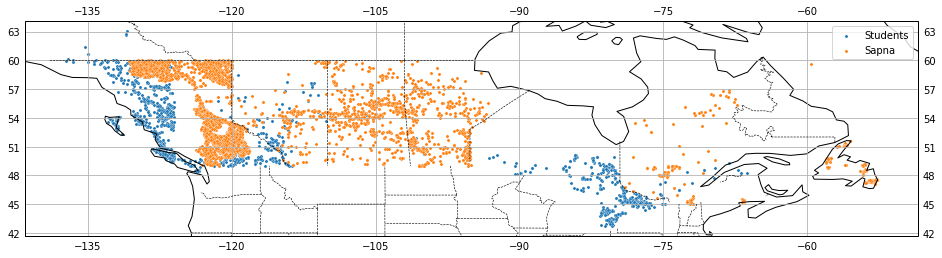

CPU times: user 797 ms, sys: 781 ms, total: 1.58 s
Wall time: 642 ms


In [56]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(canada_unidentified_lakes['longitude'], canada_unidentified_lakes['latitude'],
                transform=ccrs.PlateCarree(), s=10, label = 'Students')
sns.scatterplot(sapna_lakes['longitude'], sapna_lakes['latitude'],
                transform=ccrs.PlateCarree(), s=10, label = 'Sapna')

resol = '50m'
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)
graph.legend()

graph.show()

In [57]:
canada_unidentified_lakes['province'].value_counts().sum()

1459

# Hydrolakes and canada unidentified

In [5]:
hydrolakes_location = pd.read_csv('/mnt/c/Users/imrit/Desktop/apr_23_fish_locs_hydro.csv')
print(len(hydrolakes_location))
hydrolakes_location.head()

949809


latitude  longitude               hydro_match  hydro_dist   hydro_id  \
0  45.095566 -74.434094                [0.0, 754]    0.000000      754.0   
1  45.029876 -73.332214  [17.286849159692334, 64]   17.286849       64.0   
2  45.015270 -71.632880             [0.0, 109510]    0.000000   109510.0   
3  45.098055 -71.656944            [0.0, 1040479]    0.000000  1040479.0   
4  45.029304 -71.907721             [0.0, 109483]    0.000000   109483.0   

  ocean match2river  river_hydro_dist  river_hydro_id hydro_waterbody  
0    NO         NaN               NaN             NaN            lake  
1    NO         NaN               NaN             NaN            lake  
2    NO         NaN               NaN             NaN            lake  
3    NO         NaN               NaN             NaN            lake  
4    NO         NaN               NaN             NaN            lake

In [7]:
hydrolakes_location['hydro_waterbody'].value_counts()

ocean    434760
river    244924
lake     159677
Name: hydro_waterbody, dtype: int64

In [10]:
coords_bc = pd.read_csv('/mnt/c/Users/imrit/Desktop/bc_new_hydrolakes_match.csv')
coords_bc['hydro_waterbody'] = np.where(~coords_bc['hydro_dist'].isna(), 'lake', coords_bc['hydro_waterbody'])
coords_bc = coords_bc.loc[coords_bc['hydro_waterbody'] == 'lake']
print(len(coords_bc))
print(len(coords_bc['hydro_id'].unique()))
coords_bc

8245
2709


latitude   longitude                   hydro_match  hydro_dist  \
4      57.570000 -154.450000    [85.37035627497691, 70665]   85.370356   
7      58.250000 -157.380000  [113.77951973175233, 709899]  113.779520   
12     51.232829 -127.339217   [5.2393671332398775, 96083]    5.239367   
14     54.380995 -126.127000    [97.40499420366376, 83376]   97.404994   
19     54.445701 -125.459268      [77.09805806289931, 517]   77.098058   
...          ...         ...                           ...         ...   
26252  62.709350 -143.591100                  [0.0, 51241]    0.000000   
26253  60.405580 -144.294800                  [0.0, 59620]    0.000000   
26254  61.049480 -147.499600                 [0.0, 606397]    0.000000   
26272  60.696820 -135.041900   [136.06120037191846, 58557]  136.061200   
26277  66.218030 -155.491900   [793.5406944792763, 398426]  793.540694   

       hydro_id ocean match2river  river_hydro_dist  river_hydro_id  \
4       70665.0    NO  [nan, nan]               NaN             NaN   
7      709899.0    NO  [nan, nan]               NaN             NaN   
12      96083.0    NO  [nan, nan]               NaN             NaN   
14      83376.0    NO  [nan, nan]               NaN             NaN   
19        517.0    NO         NaN               NaN             NaN   
...         ...   ...         ...               ...             ...   
26252   51241.0    NO  [nan, nan]               NaN             NaN   
26253   59620.0    NO  [nan, nan]               NaN             NaN   
26254  606397.0    NO  [nan, nan]               NaN             NaN   
26272   58557.0    NO  [nan, nan]               NaN             NaN   
26277  398426.0    NO  [nan, nan]               NaN             NaN   

      hydro_waterbody  
4                lake  
7                lake  
12               lake  
14               lake  
19               lake  
...               ...  
26252            lake  
26253            lake  
26254            lake  
26272            lake  
26277            lake  

[8245 rows x 10 columns]

In [11]:
new_hydrolakes_location = pd.concat([hydrolakes_location, coords_bc])
new_hydrolakes_location.drop_duplicates(inplace=True)
new_hydrolakes_location.sort_values(by='hydro_waterbody', na_position='last', inplace=True)
new_hydrolakes_location.drop_duplicates(subset=['latitude', 'longitude'], keep='first', inplace=True)
new_hydrolakes_location

latitude   longitude                    hydro_match  hydro_dist  \
0       45.095566  -74.434094                     [0.0, 754]    0.000000   
451985  39.852400  -82.965500   [58.47599986212265, 1056182]   58.476000   
451991  41.228200  -81.719600  [157.44101184975665, 1054474]  157.441012   
452004  40.186000  -81.878400   [315.5036141901798, 1055809]  315.503614   
452022  45.507200  -84.563900      [75.35259036435758, 8819]   75.352590   
...           ...         ...                            ...         ...   
949803  61.693130 -150.312200                     [nan, nan]         NaN   
949805  60.056000 -151.663100                     [nan, nan]         NaN   
949806  61.534090 -149.267000                     [nan, nan]         NaN   
949807  59.457950 -139.571400                     [nan, nan]         NaN   
949808  61.520890 -148.954400                     [nan, nan]         NaN   

         hydro_id ocean match2river  river_hydro_dist  river_hydro_id  \
0           754.0    NO         NaN               NaN             NaN   
451985  1056182.0    NO         NaN               NaN             NaN   
451991  1054474.0    NO         NaN               NaN             NaN   
452004  1055809.0    NO         NaN               NaN             NaN   
452022     8819.0    NO         NaN               NaN             NaN   
...           ...   ...         ...               ...             ...   
949803        NaN    NO  [nan, nan]               NaN             NaN   
949805        NaN    NO  [nan, nan]               NaN             NaN   
949806        NaN    NO  [nan, nan]               NaN             NaN   
949807        NaN    NO  [nan, nan]               NaN             NaN   
949808        NaN    NO  [nan, nan]               NaN             NaN   

       hydro_waterbody  
0                 lake  
451985            lake  
451991            lake  
452004            lake  
452022            lake  
...                ...  
949803             NaN  
949805             NaN  
949806             NaN  
949807             NaN  
949808             NaN  

[949809 rows x 10 columns]

In [16]:
print(hydrolakes_location['hydro_waterbody'].value_counts(dropna=False))
hydrolakes_lakes = hydrolakes_location.loc[hydrolakes_location['hydro_waterbody'] == 'lake']
print(len(hydrolakes_lakes['hydro_id'].unique()))

hydrolakes_location.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/canada_hydrolakes_locations.csv', index=False)

ocean    434760
river    244924
lake     159677
NaN      110448
Name: hydro_waterbody, dtype: int64
32263


In [32]:
hydrolakes_location.head()

latitude  longitude               hydro_match  hydro_dist   hydro_id  \
0  45.095566 -74.434094                [0.0, 754]    0.000000      754.0   
1  45.029876 -73.332214  [17.286849159692334, 64]   17.286849       64.0   
2  45.015270 -71.632880             [0.0, 109510]    0.000000   109510.0   
3  45.098055 -71.656944            [0.0, 1040479]    0.000000  1040479.0   
4  45.029304 -71.907721             [0.0, 109483]    0.000000   109483.0   

  ocean match2river  river_hydro_dist  river_hydro_id hydro_waterbody  
0    NO         NaN               NaN             NaN            lake  
1    NO         NaN               NaN             NaN            lake  
2    NO         NaN               NaN             NaN            lake  
3    NO         NaN               NaN             NaN            lake  
4    NO         NaN               NaN             NaN            lake

In [33]:
sapna_lakes['hydro_waterbody'] = 'lake'

In [30]:
# sapna_lakes['hydrolake'] = np.where(sapna_lakes['hydro_dist'] < 1000, 'hydro_id', np.nan)
# sapna_lakes_ids = np.unique(sapna_lakes.loc[sapna_lakes['hydrolake'] == 'hydro_id']['hydro_id'])

# print(len(sapna_lakes))
# print(len(sapna_lakes_ids))
# sapna_non_hydro_lakes = sapna_lakes.loc[sapna_lakes['hydrolake'] != 'hydro_id']
# print(len(sapna_non_hydro_lakes))
# display(sapna_non_hydro_lakes)

5217
2350
2429


lake_name   latitude  longitude  surface_area_ha  max_depth_m  \
0       Beaver  53.250000 -117.43333             3.75        1.600   
2      Unnamed  53.516667 -117.66667             3.75        1.500   
4      Emerson  53.733330 -117.80000             7.50        7.250   
6      Unnamed  54.683333 -113.60000             7.50        9.000   
8        Spear  54.733330 -113.15000            10.00        2.000   
...        ...        ...        ...              ...          ...   
5007     AMBER  57.433330 -109.26667             0.00       14.500   
5014      CORA  54.266670 -104.58333             4.00       14.900   
5018     SEDGE  54.450000 -106.08333             0.00       15.000   
5132    DOREEN  54.500000 -105.33333             0.00       27.432   
5194  MCINTOSH  55.750240 -105.10640          6066.00       45.500   

      mean_depth_m     made_up_code hydro_match  hydro_dist  hydro_id  \
0              NaN   C_ALB_S_000000  [nan, nan]         NaN       NaN   
2              NaN   C_ALB_S_000002  [nan, nan]         NaN       NaN   
4              NaN   C_ALB_S_000004  [nan, nan]         NaN       NaN   
6              NaN   C_ALB_S_000006  [nan, nan]         NaN       NaN   
8              NaN   C_ALB_S_000008  [nan, nan]         NaN       NaN   
...            ...              ...         ...         ...       ...   
5007           NaN  C_SASK_S_000377  [nan, nan]         NaN       NaN   
5014           NaN  C_SASK_S_000384  [nan, nan]         NaN       NaN   
5018           NaN  C_SASK_S_000388  [nan, nan]         NaN       NaN   
5132           NaN  C_SASK_S_000502  [nan, nan]         NaN       NaN   
5194           NaN  C_SASK_S_000564  [nan, nan]         NaN       NaN   

     hydrolake  
0          nan  
2          nan  
4          nan  
6          nan  
8          nan  
...        ...  
5007       nan  
5014       nan  
5018       nan  
5132       nan  
5194       nan  

[2429 rows x 11 columns]

In [49]:
hydrolakes_sapna_locations = pd.concat([hydrolakes_location, sapna_lakes])
hydrolakes_sapna_locations.drop(columns = ['hydrolake', 'surface_area_ha', 'max_depth_m', 'mean_depth_m'], inplace=True)

hydrolakes_sapna_locations['made_up_code'] = np.where((hydrolakes_sapna_locations['hydro_waterbody'] == 'lake') & 
                                                      (~hydrolakes_sapna_locations['hydro_id'].isna()), 
                                                      'CA_HYD_' + hydrolakes_sapna_locations['hydro_id'].astype(str), 
                                                      hydrolakes_sapna_locations['made_up_code'])
display(hydrolakes_sapna_locations.head())
display(hydrolakes_sapna_locations.loc[~hydrolakes_sapna_locations['lake_name'].isna()].head())

latitude  longitude               hydro_match  hydro_dist   hydro_id  \
0  45.095566 -74.434094                [0.0, 754]    0.000000      754.0   
1  45.029876 -73.332214  [17.286849159692334, 64]   17.286849       64.0   
2  45.015270 -71.632880             [0.0, 109510]    0.000000   109510.0   
3  45.098055 -71.656944            [0.0, 1040479]    0.000000  1040479.0   
4  45.029304 -71.907721             [0.0, 109483]    0.000000   109483.0   

  ocean match2river  river_hydro_dist  river_hydro_id hydro_waterbody  \
0    NO         NaN               NaN             NaN            lake   
1    NO         NaN               NaN             NaN            lake   
2    NO         NaN               NaN             NaN            lake   
3    NO         NaN               NaN             NaN            lake   
4    NO         NaN               NaN             NaN            lake   

  lake_name      made_up_code  
0       NaN      CA_HYD_754.0  
1       NaN       CA_HYD_64.0  
2       NaN   CA_HYD_109510.0  
3       NaN  CA_HYD_1040479.0  
4       NaN   CA_HYD_109483.0

latitude  longitude                  hydro_match  hydro_dist  hydro_id  \
0  53.250000 -117.43333                   [nan, nan]         NaN       NaN   
1  54.633330 -113.58300   [791.8948739273071, 82190]  791.894874   82190.0   
2  53.516667 -117.66667                   [nan, nan]         NaN       NaN   
3  53.650000 -117.68333  [400.5451035494482, 858512]  400.545104  858512.0   
4  53.733330 -117.80000                   [nan, nan]         NaN       NaN   

  ocean match2river  river_hydro_dist  river_hydro_id hydro_waterbody  \
0   NaN         NaN               NaN             NaN            lake   
1   NaN         NaN               NaN             NaN            lake   
2   NaN         NaN               NaN             NaN            lake   
3   NaN         NaN               NaN             NaN            lake   
4   NaN         NaN               NaN             NaN            lake   

  lake_name     made_up_code  
0    Beaver   C_ALB_S_000000  
1   Unnamed   CA_HYD_82190.0  
2   Unnamed   C_ALB_S_000002  
3     Gregg  CA_HYD_858512.0  
4   Emerson   C_ALB_S_000004

In [50]:
len(hydrolakes_sapna_locations.loc[hydrolakes_sapna_locations['hydro_waterbody'] == 'lake']['hydro_id'].unique())

33659

In [15]:
hydrolakes_ids = np.unique(new_hydrolakes_location.loc[new_hydrolakes_location['hydro_waterbody'] == 'lake']['hydro_id'])
hydrolakes_ids = [int(x) for x in hydrolakes_ids]
hydrolakes_ids.extend(sapna_lakes_ids)

hydrolakes_ids = [int(x) for x in hydrolakes_ids]
len(hydrolakes_ids)

36316

In [16]:
%%time
hydrolakes_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/hydrolakes_v10.csv')
hydrolakes_canada = hydrolakes_df.loc[hydrolakes_df['Country'] == 'Canada']
print(len(hydrolakes_canada))
display(hydrolakes_df.head())

<string>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


Hylak_id    Lake_name                   Country      Continent Poly_src  \
0         1  Caspian Sea                    Russia         Europe     SWBD   
1         2   Great Bear                    Canada  North America   CanVec   
2         3  Great Slave                    Canada  North America   CanVec   
3         4     Winnipeg                    Canada  North America   CanVec   
4         5     Superior  United States of America  North America     SWBD   

   Lake_type  Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_res  \
0          1         0  377001.91   15829.37       7.27  ...      0.0   
1          1         0   30450.64    5331.72       8.62  ...      0.0   
2          1         0   26734.29    9814.16      16.93  ...      0.0   
3          3       709   23923.04    4018.32       7.33  ...  31790.0   
4          1         0   81843.92    5248.36       5.18  ...      0.0   

   Vol_src  Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  \
0        1      200.5  8110.642  107883.0        -29       -1.0  1404108.0   
1        1       72.2   535.187   47577.7        145       -1.0   147665.4   
2        1       59.1  4350.692    4203.2        148       -1.0   995312.3   
3        1       11.9  2244.727    1464.3        215       -1.0   919611.5   
4        1      146.7  2869.953   48410.3        179       -1.0   209219.5   

    Pour_long   Pour_lat  
0   47.717708  45.591934  
1 -123.505546  65.138384  
2 -117.617115  61.311727  
3  -97.863542  53.696359  
4  -84.460547  46.468593  

[5 rows x 21 columns]

CPU times: user 2.39 s, sys: 406 ms, total: 2.8 s
Wall time: 2.81 s


In [17]:
hydrolakes_canada = hydrolakes_df.loc[hydrolakes_df['Country'] == 'Canada']
print(len(hydrolakes_canada))

879987


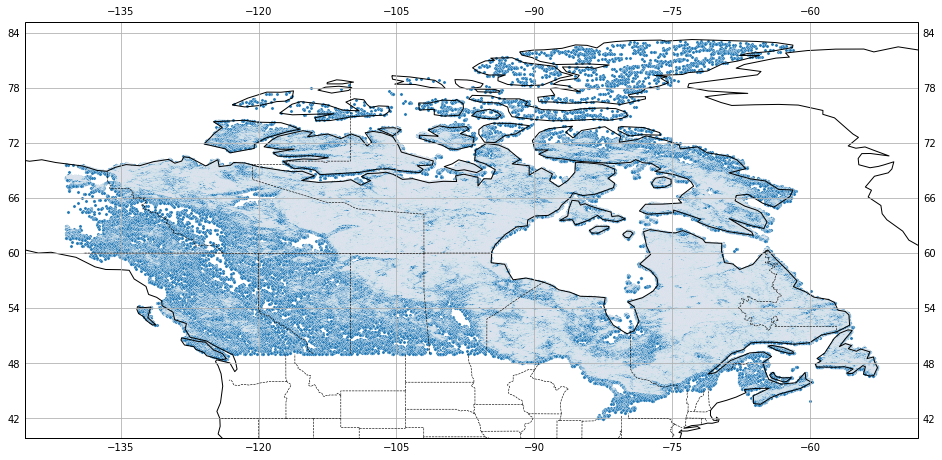

CPU times: user 1.53 s, sys: 594 ms, total: 2.12 s
Wall time: 1.34 s


In [18]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(hydrolakes_canada['Pour_long'], hydrolakes_canada['Pour_lat'],
                transform=ccrs.PlateCarree(), s=10)

resol = '50m'
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

graph.show()

In [20]:
canada_hydrolakes = hydrolakes_df.loc[(hydrolakes_df['Hylak_id'].isin(hydrolakes_ids)) & (hydrolakes_df['Country'] == 'Canada')]
len(canada_hydrolakes)

20528

In [21]:
canada_hydrolakes.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/canadian_hydrolakes_matched_sep_03.csv', index=False)

In [22]:
display(canada_hydrolakes.head())
display(canada_unidentified_lakes.head())

Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  \
1          2   Great Bear  Canada  North America   CanVec          1   
2          3  Great Slave  Canada  North America   CanVec          1   
3          4     Winnipeg  Canada  North America   CanVec          3   
19        20    Netilling  Canada  North America   CanVec          1   
22        23     Amadjuak  Canada  North America   CanVec          1   

    Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_res  Vol_src  \
1          0   30450.64    5331.72       8.62  ...      0.0        1   
2          0   26734.29    9814.16      16.93  ...      0.0        1   
3        709   23923.04    4018.32       7.33  ...  31790.0        1   
19         0    4872.70    7167.81      28.97  ...      0.0        1   
22         0    2994.94    1924.13       9.92  ...      0.0        1   

    Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  \
1        72.2   535.187   47577.7        145       -1.0   147665.4   
2        59.1  4350.692    4203.2        148       -1.0   995312.3   
3        11.9  2244.727    1464.3        215       -1.0   919611.5   
19       23.4   655.623    2012.5         18       -1.0    63399.7   
22       24.8   251.159    3427.7         91       -1.0    19638.2   

     Pour_long   Pour_lat  
1  -123.505546  65.138384  
2  -117.617115  61.311727  
3   -97.863542  53.696359  
19  -71.413041  66.563810  
22  -71.735126  65.407803  

[5 rows x 21 columns]

latitude  longitude country                      lat_long  \
2  45.920765 -75.245955  Canada  45.920765,-75.24595500000001   
3  45.932440 -75.257616  Canada           45.93244,-75.257616   
4  46.105279 -75.345767  Canada  46.105279,-75.34576700000001   
6  46.482262 -73.318453  Canada          46.482262,-73.318453   
7  46.497262 -73.334565  Canada          46.497262,-73.334565   

                                             address province  \
2   Montpellier, Papineau, Outaouais, Québec, Canada   Québec   
3  Accès chalet de la Bécasse, Montpellier, Papin...   Québec   
4  Notre-Dame-du-Laus, Antoine-Labelle, Laurentid...   Québec   
6  Mandeville, D'Autray, Lanaudière, Québec, J0K ...   Québec   
7  Sentier du Tonnerre, Mandeville, D'Autray, Lan...   Québec   

  country_from_add hydro_waterbody      waterbody_name   made_up_code  
2           Canada            lake         Riopel, Lac  C_QC_U_000267  
3           Canada            lake  Bécasse, Lac de la  C_QC_U_000270  
4           Canada            lake        Norraye, Lac  C_QC_U_000318  
6           Canada            lake       Pins, Lac des  C_QC_U_000386  
7           Canada            lake     Bonneterre, Lac  C_QC_U_000387

In [206]:
canada_sapna_uniden = pd.concat([sapna_non_hydro_lakes, canada_unidentified_lakes])
canada_sapna_uniden.sort_values(by = ['latitude', 'longitude'], inplace = True)
canada_sapna_uniden.drop_duplicates(subset = ['latitude', 'longitude'], inplace = True)
canada_sapna_uniden

lake_name   latitude   longitude  surface_area_ha  max_depth_m  \
28737       NaN  42.713333  -81.118889              NaN          NaN   
28774       NaN  42.726111  -80.318056              NaN          NaN   
28770       NaN  42.793056  -80.261111              NaN          NaN   
28735       NaN  42.866667  -81.533333              NaN          NaN   
28736       NaN  42.916667  -80.966667              NaN          NaN   
...         ...        ...         ...              ...          ...   
1123        NaN  60.689733 -135.030644              NaN          NaN   
1126        NaN  61.350798 -135.261344              NaN          NaN   
1302        NaN  62.616847 -131.080857              NaN          NaN   
1303        NaN  62.691667 -131.050000              NaN          NaN   
1313        NaN  63.056348 -130.900151              NaN          NaN   

       mean_depth_m   made_up_code hydro_match  hydro_dist  hydro_id  \
28737           NaN  C_ON_U_000003         NaN         NaN       NaN   
28774           NaN  C_ON_U_000004         NaN         NaN       NaN   
28770           NaN  C_ON_U_000007         NaN         NaN       NaN   
28735           NaN  C_ON_U_000010         NaN         NaN       NaN   
28736           NaN  C_ON_U_000012         NaN         NaN       NaN   
...             ...            ...         ...         ...       ...   
1123            NaN  C_BC_U_000037         NaN         NaN       NaN   
1126            NaN  C_BC_U_000038         NaN         NaN       NaN   
1302            NaN  C_BC_U_000042         NaN         NaN       NaN   
1303            NaN  C_BC_U_000043         NaN         NaN       NaN   
1313            NaN  C_BC_U_000044         NaN         NaN       NaN   

      hydrolake country                         lat_long  \
28737       NaN  Canada             42.713333,-81.118889   
28774       NaN  Canada             42.726111,-80.318056   
28770       NaN  Canada             42.793056,-80.261111   
28735       NaN  Canada             42.866667,-81.533333   
28736       NaN  Canada             42.916667,-80.966667   
...         ...     ...                              ...   
1123        NaN  Canada  60.68973298,-135.03064369999998   
1126        NaN  Canada          61.35079777,-135.261344   
1302        NaN  Canada         62.61684691,-131.0808568   
1303        NaN  Canada              62.69166667,-131.05   
1313        NaN  Canada  63.05634849,-130.90015079999998   

                                                 address province  \
28737  Corner's Corner Nature Preserve, Fruit Ridge L...  Ontario   
28774  Spooky Hollow Road, Normandale, Norfolk County...  Ontario   
28770  Highway 6, Port Dover, Norfolk County, Southwe...  Ontario   
28735  Sutherland Road, Strathroy-Caradoc, Middlesex ...  Ontario   
28736  Doan Drive, Thames Centre, Middlesex County, S...  Ontario   
...                                                  ...      ...   
1123   Miles Canyon Road, Whitehorse, Yukon, Y1A 4M2,...    Yukon   
1126                   Yukon, Unorganized, Yukon, Canada    Yukon   
1302                   Yukon, Unorganized, Yukon, Canada    Yukon   
1303                   Yukon, Unorganized, Yukon, Canada    Yukon   
1313                   Yukon, Unorganized, Yukon, Canada    Yukon   

      country_from_add hydro_waterbody waterbody_name  
28737           Canada            lake      Zavitz P.  
28774           Canada            lake     Mathers P.  
28770           Canada            lake      Bowlby P.  
28735           Canada            lake        Mill P.  
28736           Canada            lake  Whittaker, L.  
...                ...             ...            ...  
1123            Canada            lake     MARSH LAKE  
1126            Canada            lake   LAKE LEBARGE  
1302            Canada            lake     LEWIS LAKE  
1303            Canada            lake   SHELDON LAKE  
1313            Canada            lake     OLLIE LAKE  

[4643 rows x 18 columns]

In [207]:
len(canada_hydrolakes)

20528

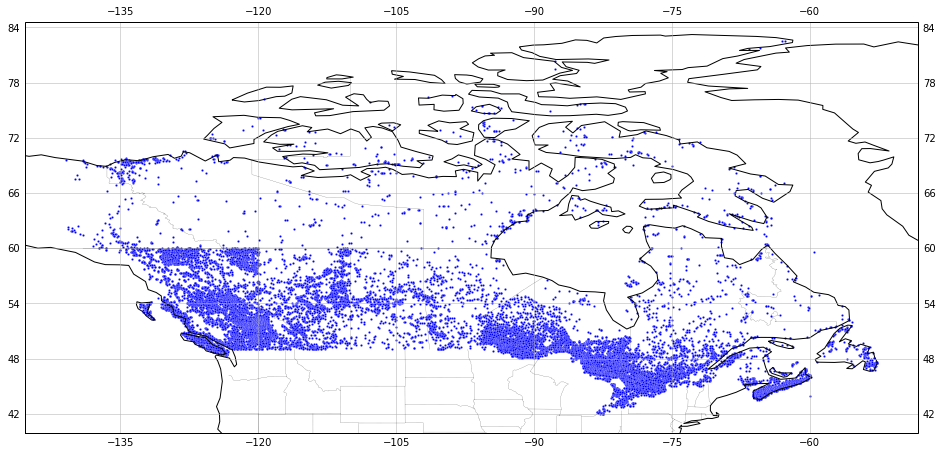

CPU times: user 1.86 s, sys: 312 ms, total: 2.17 s
Wall time: 1.69 s


In [220]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth = 0.5)

# sns.scatterplot(canada_hydrolakes['Pour_long'], canada_hydrolakes['Pour_lat'],
#                 transform=ccrs.PlateCarree(), s=10, label = 'hydrolakes')
# sns.scatterplot(canada_unidentified_lakes['longitude'], canada_unidentified_lakes['latitude'],
#                 transform=ccrs.PlateCarree(), s=10, label = 'Canada Unidentified')
# sns.scatterplot(sapna_non_hydro_lakes['longitude'], sapna_non_hydro_lakes['latitude'],
#                 transform=ccrs.PlateCarree(), s=10, label = 'Sapna')

sns.scatterplot(canada_hydrolakes['Pour_long'], canada_hydrolakes['Pour_lat'],
                transform=ccrs.PlateCarree(), s=5, label = 'hydrolakes', color = 'blue')
sns.scatterplot(canada_sapna_uniden['longitude'], canada_sapna_uniden['latitude'],
                transform=ccrs.PlateCarree(), s=5, label = 'Canada Unidentified', color = 'blue')

resol = '50m'
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.2, edgecolor="k", zorder=10)

graph.legend([], [], frameon=False)
ax.figure.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_lakes_locations_aug_25.png')
graph.show()


In [58]:
canada_unidentified_lakes['lat_long'] = canada_unidentified_lakes['latitude'].round(3).astype(str) + '_' + canada_unidentified_lakes['longitude'].round(3).astype(str)
ontario_unidentified_lat_longs = np.unique(canada_unidentified_lakes['lat_long'])

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
bsm_ahi = pd.concat([ahi, bsm])
bsm_ahi = bsm_ahi[['lat_long', 'wby_name', 'latitude', 'longitude', 'surface_area_ha', 'max_depth', 'mean_depth', 
                  'lake_elevation_(m)']]
bsm_ahi.drop_duplicates(inplace=True)

bsm_ahi['lake_area_km2'] = bsm_ahi['surface_area_ha'] * 0.01

bsm_ahi = bsm_ahi[['wby_name', 'latitude', 'longitude', 'lat_long', 'lake_area_km2', 'mean_depth', 'lake_elevation_(m)']]

bsm_ahi_unidentified = bsm_ahi.loc[bsm_ahi['lat_long'].isin(ontario_unidentified_lat_longs)]
bsm_ahi_unidentified.rename(columns = {'mean_depth': 'mean_depth_m'}, inplace=True)

bsm_ahi_unidentified['dataset'] = 'ahi_bsm'
display(bsm_ahi_unidentified)

/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


wby_name   latitude  longitude        lat_long  lake_area_km2  \
3          Zavitz P.  42.713333 -81.118889  42.713_-81.119          0.029   
4         Mathers P.  42.726111 -80.318056  42.726_-80.318          0.013   
7          Bowlby P.  42.793056 -80.261111  42.793_-80.261          0.001   
10           Mill P.  42.866667 -81.533333  42.867_-81.533          0.056   
12     Whittaker, L.  42.916667 -80.966667  42.917_-80.967          0.076   
...              ...        ...        ...             ...            ...   
9848           4, L.  43.716667 -79.966667  43.717_-79.967          0.034   
9850   Silver Cr. P.  43.850000 -79.950000    43.85_-79.95          0.013   
9859        Rocky L.  45.800000 -79.116667    45.8_-79.117          0.258   
9864          47, L.  46.723333 -83.350000   46.723_-83.35          0.020   
589   Kenogamissi L.  48.240570 -81.529850   48.241_-81.53         24.930   

      mean_depth_m  lake_elevation_(m)  dataset  
3              0.6               236.0  ahi_bsm  
4              0.9               224.0  ahi_bsm  
7              1.5               201.0  ahi_bsm  
10             1.6               221.0  ahi_bsm  
12             4.0               267.0  ahi_bsm  
...            ...                 ...      ...  
9848           NaN               332.0  ahi_bsm  
9850           0.6               302.0  ahi_bsm  
9859           4.9               473.0  ahi_bsm  
9864           1.7               389.0  ahi_bsm  
589            4.3                 NaN  ahi_bsm  

[426 rows x 8 columns]

In [78]:
%%time
bsm_ahi['hydro_match'] = bsm_ahi.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                           axis=1)
bsm_ahi[['hydro_dist','hydro_id']] = pd.DataFrame(bsm_ahi['hydro_match'].tolist(), index= bsm_ahi.index)
display(bsm_ahi)

NameError: name 'sample_df' is not defined

In [111]:
bsm_ahi.rename(columns = {'wby_name': 'lake_name'}, inplace=True)
bsm_ahi['hydro_waterbody'] = 'lake'
bsm_ahi['index'] = bsm_ahi.index
# bsm_ahi.drop(columns = ['lat_long', 'lake_area_km2', 'mean_depth', 'lake_elevation_(m)'], inplace=True)
bsm_ahi['made_up_code'] = np.where(bsm_ahi['hydro_id'].isna(), 
                                   'CA_ON_AHI_BSM_' + bsm_ahi['index'].astype(str), 
                                   'CA_HYD_' + bsm_ahi['hydro_id'].astype(str))
bsm_ahi.drop(columns = ['index'], inplace=True)
display(bsm_ahi)

lake_name   latitude  longitude  \
0                    Duff L.  42.126667 -83.120000   
1                Saunders P.  42.707778 -81.169722   
2               Deer Cr. Re.  42.711667 -80.565833   
3                  Zavitz P.  42.713333 -81.118889   
4                 Mathers P.  42.726111 -80.318056   
..                       ...        ...        ...   
849            Big Rideau L.  44.751280 -76.213790   
850           Mississippi L.  45.065380 -76.185300   
851            Charleston L.  44.534600 -76.015790   
852            Lac Deschenes  45.369950 -75.852650   
853  Lac Dollard-des-Ormeaux  45.594110 -74.487570   

                      hydro_match  hydro_dist   hydro_id hydro_waterbody  \
0                      [nan, nan]         NaN        NaN            lake   
1                      [nan, nan]         NaN        NaN            lake   
2    [8.847635757623044, 1050198]    8.847636  1050198.0            lake   
3                      [nan, nan]         NaN        NaN            lake   
4                      [nan, nan]         NaN        NaN            lake   
..                            ...         ...        ...             ...   
849                   [0.0, 8920]    0.000000     8920.0            lake   
850     [781.6243698427385, 8891]  781.624370     8891.0            lake   
851                   [0.0, 8983]    0.000000     8983.0            lake   
852                   [0.0, 8842]    0.000000     8842.0            lake   
853    [247.41145533238458, 8813]  247.411455     8813.0            lake   

         made_up_code  
0     CA_ON_AHI_BSM_0  
1     CA_ON_AHI_BSM_1  
2    CA_HYD_1050198.0  
3     CA_ON_AHI_BSM_3  
4     CA_ON_AHI_BSM_4  
..                ...  
849     CA_HYD_8920.0  
850     CA_HYD_8891.0  
851     CA_HYD_8983.0  
852     CA_HYD_8842.0  
853     CA_HYD_8813.0  

[10730 rows x 8 columns]

In [112]:
hydrolakes_sapna_ahi_bsm_locations = pd.concat([hydrolakes_sapna_locations, bsm_ahi])
print(len(hydrolakes_sapna_ahi_bsm_locations))
hydrolakes_sapna_ahi_bsm_locations.sort_values(by='hydro_waterbody', na_position='last', inplace=True)
hydrolakes_sapna_ahi_bsm_locations.drop_duplicates(subset=['latitude', 'longitude'], keep='first', inplace=True)
print(len(hydrolakes_sapna_ahi_bsm_locations))
display(hydrolakes_sapna_ahi_bsm_locations)

965756
957432


latitude   longitude                  hydro_match  hydro_dist  \
0       45.095566  -74.434094                   [0.0, 754]    0.000000   
472096  43.522660  -94.377540  [956.1229859299261, 110921]  956.122986   
472098  45.250660  -96.313880  [569.6211321751174, 109208]  569.621132   
472100  47.794910  -92.063760  [345.7506452063405, 104923]  345.750645   
472101  36.224870  -94.542000  [50.0622149021188, 1059841]   50.062215   
...           ...         ...                          ...         ...   
949803  61.693130 -150.312200                   [nan, nan]         NaN   
949805  60.056000 -151.663100                   [nan, nan]         NaN   
949806  61.534090 -149.267000                   [nan, nan]         NaN   
949807  59.457950 -139.571400                   [nan, nan]         NaN   
949808  61.520890 -148.954400                   [nan, nan]         NaN   

         hydro_id ocean match2river  river_hydro_dist  river_hydro_id  \
0           754.0    NO         NaN               NaN             NaN   
472096   110921.0    NO         NaN               NaN             NaN   
472098   109208.0    NO         NaN               NaN             NaN   
472100   104923.0    NO         NaN               NaN             NaN   
472101  1059841.0    NO         NaN               NaN             NaN   
...           ...   ...         ...               ...             ...   
949803        NaN    NO  [nan, nan]               NaN             NaN   
949805        NaN    NO  [nan, nan]               NaN             NaN   
949806        NaN    NO  [nan, nan]               NaN             NaN   
949807        NaN    NO  [nan, nan]               NaN             NaN   
949808        NaN    NO  [nan, nan]               NaN             NaN   

       hydro_waterbody lake_name      made_up_code  
0                 lake       NaN      CA_HYD_754.0  
472096            lake       NaN   CA_HYD_110921.0  
472098            lake       NaN   CA_HYD_109208.0  
472100            lake       NaN   CA_HYD_104923.0  
472101            lake       NaN  CA_HYD_1059841.0  
...                ...       ...               ...  
949803             NaN       NaN               NaN  
949805             NaN       NaN               NaN  
949806             NaN       NaN               NaN  
949807             NaN       NaN               NaN  
949808             NaN       NaN               NaN  

[957432 rows x 12 columns]

In [113]:
hydrolakes_sapna_ahi_bsm_locations.to_csv('/mnt/c/Users/imrit/Desktop/GEnfish_locations_ids_jan_12_2022.csv', index=False)

In [110]:
hydrolakes_sapna_ahi_bsm_locations['hydro_waterbody'].value_counts()

ocean    434760
river    244746
lake     167785
Name: hydro_waterbody, dtype: int64

In [223]:
canada_hydrolakes_modified = canada_hydrolakes[['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Lake_area', 
                                                         'Depth_avg', 'Elevation', 'Pour_long', 'Pour_lat']]
canada_hydrolakes_modified.rename(columns = {'Lake_area': 'lake_area_km2', 'Depth_avg': 'mean_depth_m', 'Lake_name': 'wby_name',
                                             'Elevation': 'lake_elevation_(m)', 'Pour_long': 'longitude', 
                                             'Pour_lat': 'latitude'}, inplace=True)
canada_hydrolakes_modified['dataset'] = 'hydrolakes'
canada_hydrolakes_modified

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Hylak_id     wby_name Country      Continent  lake_area_km2  \
1               2   Great Bear  Canada  North America       30450.64   
2               3  Great Slave  Canada  North America       26734.29   
3               4     Winnipeg  Canada  North America       23923.04   
19             20    Netilling  Canada  North America        4872.70   
22             23     Amadjuak  Canada  North America        2994.94   
...           ...          ...     ...            ...            ...   
1052268   1052269          NaN  Canada  North America           0.52   
1052317   1052318          NaN  Canada  North America           0.23   
1052409   1052410          NaN  Canada  North America           0.59   
1052467   1052468          NaN  Canada  North America           0.15   
1052487   1052488          NaN  Canada  North America           0.14   

         mean_depth_m  lake_elevation_(m)   longitude   latitude     dataset  
1                72.2                 145 -123.505546  65.138384  hydrolakes  
2                59.1                 148 -117.617115  61.311727  hydrolakes  
3                11.9                 215  -97.863542  53.696359  hydrolakes  
19               23.4                  18  -71.413041  66.563810  hydrolakes  
22               24.8                  91  -71.735126  65.407803  hydrolakes  
...               ...                 ...         ...        ...         ...  
1052268           1.6                 174  -83.031001  42.028938  hydrolakes  
1052317           1.7                 173  -82.571720  42.011202  hydrolakes  
1052409           1.4                 170  -82.514892  41.977083  hydrolakes  
1052467           0.7                 172  -82.516073  41.957925  hydrolakes  
1052487           0.7                 172  -82.506271  41.952372  hydrolakes  

[20528 rows x 10 columns]

In [235]:
sapna_non_hydro_lakes.rename(columns = {'lake_name': 'wby_name'}, inplace = True)
# sapna_non_hydro_lakes.drop(columns = ['hydro_match', 'hydro_dist', 'hydro_id', 'hydrolake', 'max_depth_m'], inplace = True)

sapna_non_hydro_lakes['lake_area_km2'] = sapna_non_hydro_lakes['surface_area_ha'] * 0.01

sapna_non_hydro_lakes.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wby_name   latitude  longitude  surface_area_ha  max_depth_m  mean_depth_m  \
0   Beaver  53.250000 -117.43333             3.75         1.60           NaN   
1  Unnamed  54.633330 -113.58300             3.75         4.60           NaN   
2  Unnamed  53.516667 -117.66667             3.75         1.50           NaN   
3    Gregg  53.650000 -117.68333             6.43         4.50           NaN   
4  Emerson  53.733330 -117.80000             7.50         7.25           NaN   

     made_up_code  lake_area_km2  
0  C_ALB_S_000000         0.0375  
1  C_ALB_S_000001         0.0375  
2  C_ALB_S_000002         0.0375  
3  C_ALB_S_000003         0.0643  
4  C_ALB_S_000004         0.0750

In [237]:
hydrolakes_ahi_bsm_sapna = pd.concat([canada_hydrolakes_modified, bsm_ahi_unidentified, sapna_non_hydro_lakes]).drop(columns = ['lat_long'], axis=1)
display(hydrolakes_ahi_bsm_sapna)

Hylak_id     wby_name Country      Continent  lake_area_km2  \
1          2.0   Great Bear  Canada  North America       30450.64   
2          3.0  Great Slave  Canada  North America       26734.29   
3          4.0     Winnipeg  Canada  North America       23923.04   
19        20.0    Netilling  Canada  North America        4872.70   
22        23.0     Amadjuak  Canada  North America        2994.94   
...        ...          ...     ...            ...            ...   
5144       NaN      DICKENS     NaN            NaN           6.68   
5148       NaN       HAUGEN     NaN            NaN           0.95   
5188       NaN  LITTLE BEAR     NaN            NaN          15.00   
5191       NaN   FAIRY GLEN     NaN            NaN           0.32   
5194       NaN     MCINTOSH     NaN            NaN          60.66   

      mean_depth_m  lake_elevation_(m)   longitude   latitude     dataset  \
1             72.2               145.0 -123.505546  65.138384  hydrolakes   
2             59.1               148.0 -117.617115  61.311727  hydrolakes   
3             11.9               215.0  -97.863542  53.696359  hydrolakes   
19            23.4                18.0  -71.413041  66.563810  hydrolakes   
22            24.8                91.0  -71.735126  65.407803  hydrolakes   
...            ...                 ...         ...        ...         ...   
5144           NaN                 NaN -104.616670  55.733330         NaN   
5148           NaN                 NaN -104.816670  55.550000         NaN   
5188           NaN                 NaN -104.583330  54.333330         NaN   
5191           NaN                 NaN -104.766670  54.083330         NaN   
5194           NaN                 NaN -105.106400  55.750240         NaN   

      surface_area_ha  max_depth_m     made_up_code  
1                 NaN          NaN              NaN  
2                 NaN          NaN              NaN  
3                 NaN          NaN              NaN  
19                NaN          NaN              NaN  
22                NaN          NaN              NaN  
...               ...          ...              ...  
5144            668.0         30.0  C_SASK_S_000514  
5148             95.0         30.6  C_SASK_S_000518  
5188           1500.0         44.2  C_SASK_S_000558  
5191             32.0         45.0  C_SASK_S_000561  
5194           6066.0         45.5  C_SASK_S_000564  

[24209 rows x 13 columns]

In [553]:
canada_unidentified_lakes.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/canada_unidentified_lakes.csv', 
                                 index=False)

In [26]:
hydrolakes_ahi_bsm_sapna = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/hydrolakes_ahi_bsm_sapna_lake_caracteristics_aug_26.csv')

In [555]:
canada_lake_locations = pd.concat([canada_hydrolakes_modified, canada_unidentified_lakes])
canada_lake_locations = canada_lake_locations[['latitude', 'longitude']]
canada_lake_locations.drop_duplicates(inplace=True)

display(canada_lake_locations)
canada_lake_locations.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/canada_lake_locations.csv', 
                             index=False)

latitude   longitude
1      65.138384 -123.505546
2      61.311727 -117.617115
3      53.696359  -97.863542
19     66.563810  -71.413041
22     65.407803  -71.735126
...          ...         ...
53875  51.749844 -126.652664
53876  51.753104 -126.655582
53877  51.761186 -126.655438
53878  51.764968 -126.655692
53879  51.772744 -126.651027

[20622 rows x 2 columns]

In [28]:
display(hydrolakes_ahi_bsm_sapna)

Hylak_id   wby_name Country Continent  lake_area_km2  mean_depth_m  \
0           NaN  Bowlby P.     NaN       NaN          0.001           1.5   
1           NaN      B, L.     NaN       NaN          0.001           NaN   
2           NaN    H-A, L.     NaN       NaN          0.001           NaN   
3           NaN    Eby Ph.     NaN       NaN          0.002           1.2   
4           NaN  Vances L.     NaN       NaN          0.002           1.6   
...         ...        ...     ...       ...            ...           ...   
24204       NaN       6206     NaN       NaN            NaN           NaN   
24205       NaN       7170     NaN       NaN            NaN           NaN   
24206       NaN       7298     NaN       NaN            NaN           NaN   
24207       NaN       8376     NaN       NaN            NaN           NaN   
24208       NaN       9328     NaN       NaN            NaN           NaN   

       lake_elevation_(m)   longitude   latitude  dataset  surface_area_ha  \
0                   201.0  -80.261111  42.793056  ahi_bsm              NaN   
1                   326.0  -80.200000  43.450000  ahi_bsm              NaN   
2                   332.0  -80.166667  43.500000  ahi_bsm              NaN   
3                   320.0  -80.163333  48.032500  ahi_bsm              NaN   
4                   265.0  -81.375000  44.233889  ahi_bsm              NaN   
...                   ...         ...        ...      ...              ...   
24204                 NaN -101.877200  54.780280      NaN              NaN   
24205                 NaN  -99.996940  56.483330      NaN              NaN   
24206                 NaN -101.172700  56.087500      NaN              NaN   
24207                 NaN -101.650000  58.483330      NaN              NaN   
24208                 NaN  -96.152780  50.753890      NaN              NaN   

       max_depth_m    made_up_code  
0              NaN             NaN  
1              NaN             NaN  
2              NaN             NaN  
3              NaN             NaN  
4              NaN             NaN  
...            ...             ...  
24204          NaN  C_MAN_S_000533  
24205          NaN  C_MAN_S_000560  
24206          NaN  C_MAN_S_000569  
24207          NaN  C_MAN_S_000594  
24208          NaN  C_MAN_S_000601  

[24209 rows x 13 columns]

In [32]:
resol = '50m'
# country boundaries
country_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', edgecolor='k')

# province boundaries
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')

In [31]:
hydrolakes_ahi_bsm_sapna['lake_area_km2'].min()

0.001

0.88268474 0.4062400100000001


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


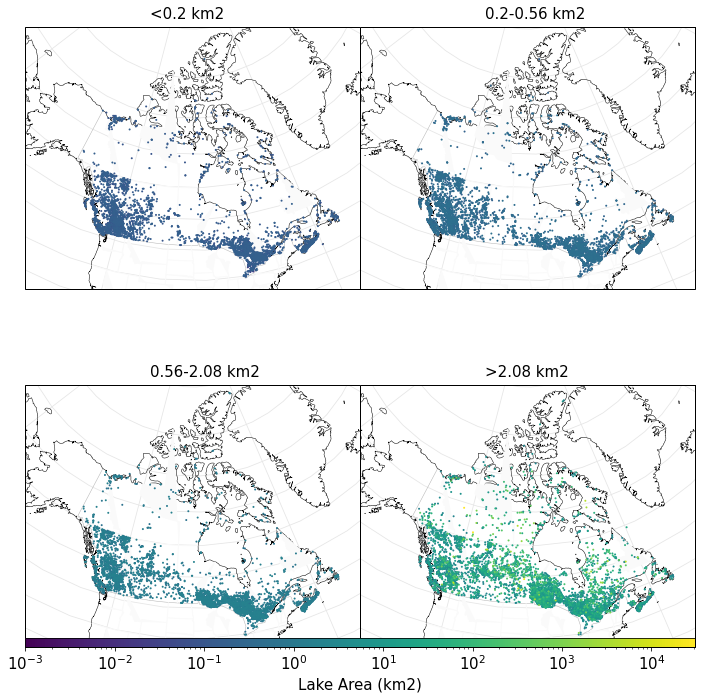

In [33]:
import matplotlib as mpl

states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

hydrolakes_ahi_bsm_sapna = hydrolakes_ahi_bsm_sapna.sort_values('mean_depth_m')

x0, x1 = hydrolakes_ahi_bsm_sapna.longitude.min(), hydrolakes_ahi_bsm_sapna.longitude.max()
padfrac = 0.01
y0 ,y1 = hydrolakes_ahi_bsm_sapna.latitude.min(), hydrolakes_ahi_bsm_sapna.latitude.max()
lonpad = (x1-x0)*padfrac
latpad = (y1-y0)*padfrac
print(lonpad,latpad)

clon = (x0+x1)/2.
clat = (y0+y1)/2.

colour_column = 'lake_area_km2'
# colour_column = 'mean_depth_m'

hydrolakes_ahi_bsm_sapna = hydrolakes_ahi_bsm_sapna.sort_values(colour_column)

#hydrolakes_ahi_bsm_sapna['log_mean_depth_m'] = np.log10(hydrolakes_ahi_bsm_sapna.mean_depth_m)
vmin = hydrolakes_ahi_bsm_sapna[colour_column].min()
vmax = hydrolakes_ahi_bsm_sapna[colour_column].max()

fig, axes = graph.subplots(2, 2, figsize= (12, 12), constrained_layout=True, 
                         subplot_kw = dict(projection=ccrs.LambertConformal(central_longitude=clon,central_latitude=clat)))

# graph_labels = ['<3.6 m', '3.6-5.0 m', '5-7.3 m', '>7.3 m']
graph_labels = ['<0.2 km2', '0.2-0.56 km2', '0.56-2.08 km2', '>2.08 km2']

for i, ax in enumerate(axes.flatten()):
    lowerbound = hydrolakes_ahi_bsm_sapna[colour_column].quantile(0.25*i)
    upperbound = hydrolakes_ahi_bsm_sapna[colour_column].quantile(0.25*(i+1))
    ind = hydrolakes_ahi_bsm_sapna[colour_column].between(lowerbound, upperbound)
    
    x= hydrolakes_ahi_bsm_sapna.loc[ind,'longitude']
    y = hydrolakes_ahi_bsm_sapna.loc[ind,'latitude']
    c = hydrolakes_ahi_bsm_sapna.loc[ind,colour_column]
    
    im = ax.scatter(x,y,marker='o',c=c,#markeredgewidth=0.2,c=c,
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                          s=4, edgecolors='none',#markerfacecolor='C0',
                          transform = ccrs.PlateCarree(),
                          label=f"{lowerbound:.2f}-{upperbound:.2f}",zorder=3)
    ax.gridlines(linestyle='-',color='0.9',zorder=1)
#     ax.add_feature(cartopy.feature.LAND,color='0.98')
    ax.add_feature(country_bodr, linestyle='-',lw=0.5,edgecolor='0.7')
# #ax.add_feature(cfeature.OCEAN,color='1.0')
#     ax.add_feature(cartopy.feature.COASTLINE,edgecolor='0.7',lw=0.5)
    ax.coastlines('50m', lw=0.5)
    ax.add_feature(provinc_bodr, color='0.98')
#     ax.legend()
    ax.text(x0-lonpad, y1+latpad + 1, f'{graph_labels[i]}', transform = ccrs.PlateCarree(), fontsize = 15)
    ax.set_extent([x0-lonpad, x1+lonpad, 
                   y0-latpad - 2, y1+latpad],
                  crs=ccrs.PlateCarree())
    
cb = fig.colorbar(im, ax=axes[1,:],orientation='horizontal', pad=3, fraction=0.03, aspect=45)
cb.solids.set_edgecolor('face')
cb.solids.set_rasterized(True)
cb.set_label(label='Lake Area (km2)',fontsize=15)
cb.ax.tick_params(labelsize=15)
fig.subplots_adjust(hspace=0.0, wspace=0.0)
#ax.add_feature(states_provinces, edgecolor='gray')

#ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)
# fig.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_lakes_surface_area_subplots.png', 
#             bbox_inches = 'tight')

In [34]:
hydrolakes_canada

Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  \
1               2   Great Bear  Canada  North America   CanVec          1   
2               3  Great Slave  Canada  North America   CanVec          1   
3               4     Winnipeg  Canada  North America   CanVec          3   
19             20    Netilling  Canada  North America   CanVec          1   
20             21     Takiyuak  Canada  North America   CanVec          1   
...           ...          ...     ...            ...      ...        ...   
1052317   1052318          NaN  Canada  North America     SWBD          1   
1052381   1052382          NaN  Canada  North America     SWBD          1   
1052409   1052410          NaN  Canada  North America     SWBD          1   
1052467   1052468          NaN  Canada  North America     SWBD          1   
1052487   1052488          NaN  Canada  North America     SWBD          1   

         Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_res  Vol_src  \
1               0   30450.64    5331.72       8.62  ...      0.0        1   
2               0   26734.29    9814.16      16.93  ...      0.0        1   
3             709   23923.04    4018.32       7.33  ...  31790.0        1   
19              0    4872.70    7167.81      28.97  ...      0.0        1   
20              0    1031.69    1003.96       8.82  ...      0.0        1   
...           ...        ...        ...        ...  ...      ...      ...   
1052317         0       0.23       3.33       1.98  ...      0.0        3   
1052381         0       0.34       3.43       1.65  ...      0.0        3   
1052409         0       0.59       3.09       1.13  ...      0.0        3   
1052467         0       0.15       2.39       1.73  ...      0.0        3   
1052487         0       0.14       1.62       1.24  ...      0.0        3   

         Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  \
1             72.2   535.187   47577.7        145      -1.00   147665.4   
2             59.1  4350.692    4203.2        148      -1.00   995312.3   
3             11.9  2244.727    1464.3        215      -1.00   919611.5   
19            23.4   655.623    2012.5         18      -1.00    63399.7   
20            48.1    41.152   13943.5        366      -1.00     7177.5   
...            ...       ...       ...        ...        ...        ...   
1052317        1.7     0.328      13.2        173       0.51       65.3   
1052381        0.9     0.043      87.4        173       0.14        8.5   
1052409        1.4     0.013     731.3        170       0.26        2.6   
1052467        0.7     0.002     581.2        172       0.08        0.3   
1052487        0.7     0.002     585.0        172       0.11        0.5   

          Pour_long   Pour_lat  
1       -123.505546  65.138384  
2       -117.617115  61.311727  
3        -97.863542  53.696359  
19       -71.413041  66.563810  
20      -113.658891  66.212040  
...             ...        ...  
1052317  -82.571720  42.011202  
1052381  -82.546521  41.986071  
1052409  -82.514892  41.977083  
1052467  -82.516073  41.957925  
1052487  -82.506271  41.952372  

[879987 rows x 21 columns]

In [38]:
hydrolakes_canada['lat_long'] = hydrolakes_canada['Pour_lat'].map(str) + ',' + hydrolakes_canada['Pour_long'].map(str)
hydrolakes_canada

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  \
1               2   Great Bear  Canada  North America   CanVec          1   
2               3  Great Slave  Canada  North America   CanVec          1   
3               4     Winnipeg  Canada  North America   CanVec          3   
19             20    Netilling  Canada  North America   CanVec          1   
20             21     Takiyuak  Canada  North America   CanVec          1   
...           ...          ...     ...            ...      ...        ...   
1052317   1052318          NaN  Canada  North America     SWBD          1   
1052381   1052382          NaN  Canada  North America     SWBD          1   
1052409   1052410          NaN  Canada  North America     SWBD          1   
1052467   1052468          NaN  Canada  North America     SWBD          1   
1052487   1052488          NaN  Canada  North America     SWBD          1   

         Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_src  Depth_avg  \
1               0   30450.64    5331.72       8.62  ...        1       72.2   
2               0   26734.29    9814.16      16.93  ...        1       59.1   
3             709   23923.04    4018.32       7.33  ...        1       11.9   
19              0    4872.70    7167.81      28.97  ...        1       23.4   
20              0    1031.69    1003.96       8.82  ...        1       48.1   
...           ...        ...        ...        ...  ...      ...        ...   
1052317         0       0.23       3.33       1.98  ...        3        1.7   
1052381         0       0.34       3.43       1.65  ...        3        0.9   
1052409         0       0.59       3.09       1.13  ...        3        1.4   
1052467         0       0.15       2.39       1.73  ...        3        0.7   
1052487         0       0.14       1.62       1.24  ...        3        0.7   

          Dis_avg  Res_time  Elevation  Slope_100  Wshd_area   Pour_long  \
1         535.187   47577.7        145      -1.00   147665.4 -123.505546   
2        4350.692    4203.2        148      -1.00   995312.3 -117.617115   
3        2244.727    1464.3        215      -1.00   919611.5  -97.863542   
19        655.623    2012.5         18      -1.00    63399.7  -71.413041   
20         41.152   13943.5        366      -1.00     7177.5 -113.658891   
...           ...       ...        ...        ...        ...         ...   
1052317     0.328      13.2        173       0.51       65.3  -82.571720   
1052381     0.043      87.4        173       0.14        8.5  -82.546521   
1052409     0.013     731.3        170       0.26        2.6  -82.514892   
1052467     0.002     581.2        172       0.08        0.3  -82.516073   
1052487     0.002     585.0        172       0.11        0.5  -82.506271   

          Pour_lat               lat_long  
1        65.138384  65.138384,-123.505546  
2        61.311727  61.311727,-117.617115  
3        53.696359   53.696359,-97.863542  
19       66.563810    66.56381,-71.413041  
20       66.212040   66.21204,-113.658891  
...            ...                    ...  
1052317  42.011202    42.011202,-82.57172  
1052381  41.986071   41.986071,-82.546521  
1052409  41.977083   41.977083,-82.514892  
1052467  41.957925   41.957925,-82.516073  
1052487  41.952372   41.952372,-82.506271  

[879987 rows x 22 columns]

In [39]:
can_hydrolakes_lat_longs = hydrolakes_canada['lat_long'].values
can_hydrolakes_lat_longs

array(['65.138384,-123.505546', '61.311727,-117.617115',
       '53.696359,-97.863542', ..., '41.977083,-82.514892',
       '41.957925,-82.516073', '41.952372,-82.506271'], dtype=object)

In [29]:
nick_shapefile = gpd.read_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_WGS84.shp')
display(nick_shapefile.head())
len(nick_shapefile)

WSCSSDA    TWS_Area_m                                           geometry
0    08JD  6.266462e+09  POLYGON ((-125.41910 55.11623, -125.41885 55.1...
1    05AK  5.335010e+09  POLYGON ((-109.89815 50.92035, -109.89509 50.9...
2    06CE  4.591652e+09  POLYGON ((-105.14596 56.98348, -105.14677 56.9...
3    07HE  6.463431e+09  POLYGON ((-116.42664 57.94598, -116.42025 57.9...
4    06CD  1.911540e+10  POLYGON ((-104.27707 56.09364, -104.27596 56.0...

991

In [6]:
sf = shp.Reader('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_WGS84.shp')

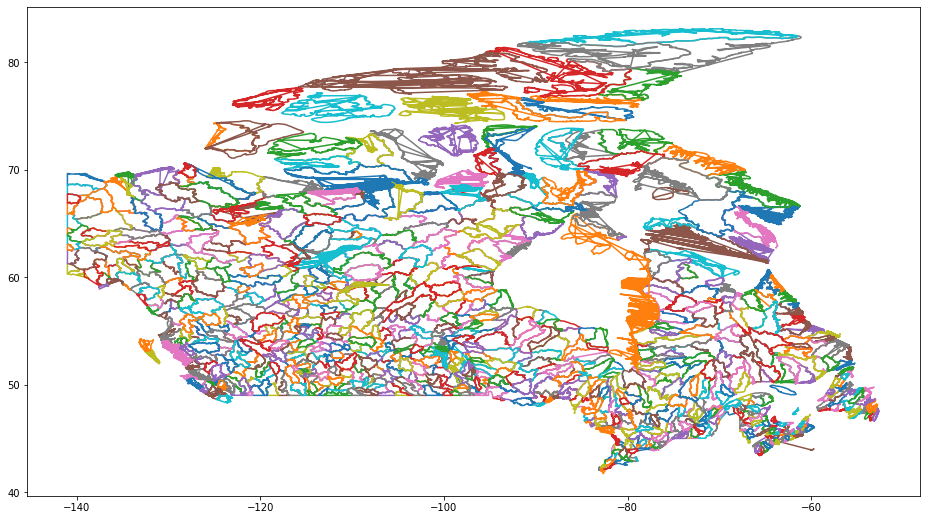

In [8]:
graph.figure(figsize=(16,9))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    graph.plot(x,y)
graph.show()

In [7]:
canada_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/hydrolakes_ahi_bsm_sapna_lake_caracteristics_aug_26.csv')
display(canada_lakes)

Hylak_id   wby_name Country Continent  lake_area_km2  mean_depth_m  \
0           NaN  Bowlby P.     NaN       NaN          0.001           1.5   
1           NaN      B, L.     NaN       NaN          0.001           NaN   
2           NaN    H-A, L.     NaN       NaN          0.001           NaN   
3           NaN    Eby Ph.     NaN       NaN          0.002           1.2   
4           NaN  Vances L.     NaN       NaN          0.002           1.6   
...         ...        ...     ...       ...            ...           ...   
24204       NaN       6206     NaN       NaN            NaN           NaN   
24205       NaN       7170     NaN       NaN            NaN           NaN   
24206       NaN       7298     NaN       NaN            NaN           NaN   
24207       NaN       8376     NaN       NaN            NaN           NaN   
24208       NaN       9328     NaN       NaN            NaN           NaN   

       lake_elevation_(m)   longitude   latitude  dataset  surface_area_ha  \
0                   201.0  -80.261111  42.793056  ahi_bsm              NaN   
1                   326.0  -80.200000  43.450000  ahi_bsm              NaN   
2                   332.0  -80.166667  43.500000  ahi_bsm              NaN   
3                   320.0  -80.163333  48.032500  ahi_bsm              NaN   
4                   265.0  -81.375000  44.233889  ahi_bsm              NaN   
...                   ...         ...        ...      ...              ...   
24204                 NaN -101.877200  54.780280      NaN              NaN   
24205                 NaN  -99.996940  56.483330      NaN              NaN   
24206                 NaN -101.172700  56.087500      NaN              NaN   
24207                 NaN -101.650000  58.483330      NaN              NaN   
24208                 NaN  -96.152780  50.753890      NaN              NaN   

       max_depth_m    made_up_code  
0              NaN             NaN  
1              NaN             NaN  
2              NaN             NaN  
3              NaN             NaN  
4              NaN             NaN  
...            ...             ...  
24204          NaN  C_MAN_S_000533  
24205          NaN  C_MAN_S_000560  
24206          NaN  C_MAN_S_000569  
24207          NaN  C_MAN_S_000594  
24208          NaN  C_MAN_S_000601  

[24209 rows x 13 columns]

In [8]:
gpd_canada_lakes = gpd.GeoDataFrame(canada_lakes, 
                                    geometry=gpd.points_from_xy(canada_lakes['longitude'], canada_lakes['latitude']))
gpd_canada_lakes.head()

Hylak_id   wby_name Country Continent  lake_area_km2  mean_depth_m  \
0       NaN  Bowlby P.     NaN       NaN          0.001           1.5   
1       NaN      B, L.     NaN       NaN          0.001           NaN   
2       NaN    H-A, L.     NaN       NaN          0.001           NaN   
3       NaN    Eby Ph.     NaN       NaN          0.002           1.2   
4       NaN  Vances L.     NaN       NaN          0.002           1.6   

   lake_elevation_(m)  longitude   latitude  dataset  surface_area_ha  \
0               201.0 -80.261111  42.793056  ahi_bsm              NaN   
1               326.0 -80.200000  43.450000  ahi_bsm              NaN   
2               332.0 -80.166667  43.500000  ahi_bsm              NaN   
3               320.0 -80.163333  48.032500  ahi_bsm              NaN   
4               265.0 -81.375000  44.233889  ahi_bsm              NaN   

   max_depth_m made_up_code                    geometry  
0          NaN          NaN  POINT (-80.26111 42.79306)  
1          NaN          NaN  POINT (-80.20000 43.45000)  
2          NaN          NaN  POINT (-80.16667 43.50000)  
3          NaN          NaN  POINT (-80.16333 48.03250)  
4          NaN          NaN  POINT (-81.37500 44.23389)

In [28]:
nick_shapefile

WSCSSDA    TWS_Area_m                                           geometry
0      08JD  6.266462e+09  POLYGON ((-125.41910 55.11623, -125.41885 55.1...
1      05AK  5.335010e+09  POLYGON ((-109.89815 50.92035, -109.89509 50.9...
2      06CE  4.591652e+09  POLYGON ((-105.14596 56.98348, -105.14677 56.9...
3      07HE  6.463431e+09  POLYGON ((-116.42664 57.94598, -116.42025 57.9...
4      06CD  1.911540e+10  POLYGON ((-104.27707 56.09364, -104.27596 56.0...
..      ...           ...                                                ...
986    08FG  5.861174e+09  MULTIPOLYGON (((-129.11374 53.08515, -129.1140...
987    08JE  9.417262e+09  POLYGON ((-123.22264 54.13957, -123.22267 54.1...
988    07DD  8.519435e+09  MULTIPOLYGON (((-110.82248 58.63388, -110.8285...
989    08JB  6.556744e+09  POLYGON ((-124.60807 54.23210, -124.60847 54.2...
990    08JA  1.622482e+10  POLYGON ((-125.52007 52.94513, -125.52502 52.9...

[991 rows x 3 columns]

In [23]:
nick_shapefile = gpd.read_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_watersheds_hydrolakes_our_lake_counts_proper_shapefile.shp')

hydrolakes_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/hydrolakes_v10.csv')
hydrolakes_canada = hydrolakes_df.loc[hydrolakes_df['Country'] == 'Canada']
print(len(hydrolakes_canada))
display(hydrolakes_canada.head())

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


879987


Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  \
1          2   Great Bear  Canada  North America   CanVec          1   
2          3  Great Slave  Canada  North America   CanVec          1   
3          4     Winnipeg  Canada  North America   CanVec          3   
19        20    Netilling  Canada  North America   CanVec          1   
20        21     Takiyuak  Canada  North America   CanVec          1   

    Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_res  Vol_src  \
1          0   30450.64    5331.72       8.62  ...      0.0        1   
2          0   26734.29    9814.16      16.93  ...      0.0        1   
3        709   23923.04    4018.32       7.33  ...  31790.0        1   
19         0    4872.70    7167.81      28.97  ...      0.0        1   
20         0    1031.69    1003.96       8.82  ...      0.0        1   

    Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  \
1        72.2   535.187   47577.7        145       -1.0   147665.4   
2        59.1  4350.692    4203.2        148       -1.0   995312.3   
3        11.9  2244.727    1464.3        215       -1.0   919611.5   
19       23.4   655.623    2012.5         18       -1.0    63399.7   
20       48.1    41.152   13943.5        366       -1.0     7177.5   

     Pour_long   Pour_lat  
1  -123.505546  65.138384  
2  -117.617115  61.311727  
3   -97.863542  53.696359  
19  -71.413041  66.563810  
20 -113.658891  66.212040  

[5 rows x 21 columns]

In [15]:
list_of_points = gpd.points_from_xy(hydrolakes_canada.Pour_long, hydrolakes_canada.Pour_lat)
# list_of_points = gpd.points_from_xy(canada_lakes.longitude, canada_lakes.latitude)

df_points = gpd.GeoSeries(list_of_points)
print(len(df_points))

879987


In [16]:
for i, row in tqdm(nick_shapefile.iterrows()):
    poly = row.geometry
    if isinstance(poly,MultiPolygon):
        count = 0
        for p in list(poly):
            count = count + df_points.intersects(p).sum()
    else:
        count = df_points.intersects(poly).sum()
    nick_shapefile.loc[i,'hydro_lakes_count'] = count

991it [7:29:26, 27.21s/it] 


In [24]:
display(nick_shapefile.head())

WSCSSDA    TWS_Area_m  out_lakes_  hydro_lake  \
0    08JD  6.266462e+09        27.0       116.0   
1    05AK  5.335010e+09         2.0        31.0   
2    06CE  4.591652e+09         5.0       872.0   
3    07HE  6.463431e+09         3.0       121.0   
4    06CD  1.911540e+10        60.0      3054.0   

                                            geometry  
0  POLYGON ((-125.41910 55.11623, -125.41885 55.1...  
1  POLYGON ((-109.89815 50.92035, -109.89509 50.9...  
2  POLYGON ((-105.14596 56.98348, -105.14677 56.9...  
3  POLYGON ((-116.42664 57.94598, -116.42025 57.9...  
4  POLYGON ((-104.27707 56.09364, -104.27596 56.0...

In [19]:
nick_shapefile.to_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_watersheds_hydrolakes_our_lake_counts_proper_shapefile.shp')

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [21]:
test_shapefile = gpd.read_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_watersheds_hydrolakes_our_lake_counts_proper_shapefile.shp')
test_shapefile.head()

WSCSSDA    TWS_Area_m  out_lakes_  hydro_lake  \
0    08JD  6.266462e+09        27.0       116.0   
1    05AK  5.335010e+09         2.0        31.0   
2    06CE  4.591652e+09         5.0       872.0   
3    07HE  6.463431e+09         3.0       121.0   
4    06CD  1.911540e+10        60.0      3054.0   

                                            geometry  
0  POLYGON ((-125.41910 55.11623, -125.41885 55.1...  
1  POLYGON ((-109.89815 50.92035, -109.89509 50.9...  
2  POLYGON ((-105.14596 56.98348, -105.14677 56.9...  
3  POLYGON ((-116.42664 57.94598, -116.42025 57.9...  
4  POLYGON ((-104.27707 56.09364, -104.27596 56.0...

In [2]:
shpfile_hydrolakes = gpd.read_file('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp')
shpfile_hydrolakes.head()


Hylak_id    Lake_name                   Country      Continent Poly_src  \
0         1  Caspian Sea                    Russia         Europe     SWBD   
1         2   Great Bear                    Canada  North America   CanVec   
2         3  Great Slave                    Canada  North America   CanVec   
3         4     Winnipeg                    Canada  North America   CanVec   
4         5     Superior  United States of America  North America     SWBD   

   Lake_type  Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_src  \
0          1         0  377001.91   15829.37       7.27  ...        1   
1          1         0   30450.64    5331.72       8.62  ...        1   
2          1         0   26734.29    9814.16      16.93  ...        1   
3          3       709   23923.04    4018.32       7.33  ...        1   
4          1         0   81843.92    5248.36       5.18  ...        1   

   Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area   Pour_long  \
0      200.5  8110.642  107883.0        -29       -1.0  1404108.0   47.717708   
1       72.2   535.187   47577.7        145       -1.0   147665.4 -123.505546   
2       59.1  4350.692    4203.2        148       -1.0   995312.3 -117.617115   
3       11.9  2244.727    1464.3        215       -1.0   919611.5  -97.863542   
4      146.7  2869.953   48410.3        179       -1.0   209219.5  -84.460547   

    Pour_lat                                           geometry  
0  45.591934  POLYGON ((49.96181 37.43847, 49.96457 37.44022...  
1  65.138384  POLYGON ((-119.78782 67.03574, -119.78637 67.0...  
2  61.311727  POLYGON ((-109.93976 62.95851, -109.93831 62.9...  
3  53.696359  POLYGON ((-98.80636 53.88021, -98.80578 53.880...  
4  46.468593  POLYGON ((-90.72250 46.65740, -90.72458 46.657...  

[5 rows x 22 columns]

In [3]:
us_hydrolakes = shpfile_hydrolakes.loc[shpfile_hydrolakes['Country'] == 'United States of America']
print(len(us_hydrolakes))
display(us_hydrolakes.head())

104419


Hylak_id Lake_name                   Country      Continent Poly_src  \
4         5  Superior  United States of America  North America     SWBD   
5         6  Michigan  United States of America  North America     SWBD   
6         7   Ontario  United States of America  North America     SWBD   
7         8     Huron  United States of America  North America     SWBD   
8         9      Erie  United States of America  North America     SWBD   

   Lake_type  Grand_id  Lake_area  Shore_len  Shore_dev  ...  Vol_src  \
4          1         0   81843.92    5248.36       5.18  ...        1   
5          1         0   57726.84    2862.67       3.36  ...        1   
6          3      1485   19347.36    2609.93       5.29  ...        1   
7          1         0   59399.30    8856.64      10.25  ...        1   
8          1         0   25767.79    1935.52       3.40  ...        1   

   Depth_avg   Dis_avg  Res_time  Elevation  Slope_100  Wshd_area  Pour_long  \
4      146.7  2869.953   48410.3        179       -1.0   209219.5 -84.460547   
5       84.2  1877.753   29956.0        175       -1.0   176006.4 -84.753910   
6       84.8  7745.819    2450.5         73       -1.0   766137.4 -75.794246   
7       59.8  9162.152    4484.5        175       -1.0   576017.7 -82.422576   
8       19.4  9796.883     589.5        172       -1.0   679903.4 -78.908084   

    Pour_lat                                           geometry  
4  46.468593  POLYGON ((-90.72250 46.65740, -90.72458 46.657...  
5  45.822916  POLYGON ((-84.75366 45.83889, -84.75365 45.783...  
6  44.480557  POLYGON ((-79.09167 43.81213, -79.09133 43.812...  
7  42.999403  POLYGON ((-80.99694 45.92284, -80.99838 45.921...  
8  42.904334  POLYGON ((-83.34778 41.88395, -83.34840 41.883...  

[5 rows x 22 columns]

In [4]:
us_hydrolakes.to_file('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/US_HydroLAKES_polys_v10.shp')